# Data Preperation, EDA, FE
- Обработака пропусков
- Изучение данных
- Разметка данных
- Базовая генерация признаков


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_palette('Set2')

# Загрузка данных
Поля датафрейма:
- Индекс Datetime - временная метка начала каждого часа
- Open - цена открытия часа
- High - максимальная цена в течении часа
- Low - минимальная цена в течении часа
- Close - цена на закрытии часа
- Volume - суммарное количество монет по которым прошли сделки купли/продажи за текущий час
- Trades - количество сделок за час

In [4]:
df = pd.read_parquet("../data/ETH-Full-1H.parquet")
df = df.asfreq("H")  # установка периода для timeseries
df

Open     High      Low    Close       Volume   Trades
Datetime                                                                     
2017-09-01 00:00:00   384.79   388.74   384.79   388.74    162.97779    131.0
2017-09-01 01:00:00   388.69   394.06   387.53   391.37    248.72949    262.0
2017-09-01 02:00:00   392.88   394.39   389.46   390.88    198.82856    225.0
2017-09-01 03:00:00   391.70   393.13   390.86   390.86    141.56114    138.0
2017-09-01 04:00:00   392.65   394.27   387.64   390.33    135.65894    128.0
...                      ...      ...      ...      ...          ...      ...
2023-04-23 19:00:00  1846.76  1852.35  1844.92  1846.49  16550.18290  21648.0
2023-04-23 20:00:00  1846.49  1852.30  1838.03  1848.89  13113.47550  19445.0
2023-04-23 21:00:00  1848.88  1859.32  1847.59  1854.66   7855.61330  13824.0
2023-04-23 22:00:00  1854.67  1868.16  1848.00  1861.72  15836.48430  21852.0
2023-04-23 23:00:00  1861.72  1865.60  1859.17  1862.00   8767.12790  12371.0

[49464 rows x 6 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49464 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  float64
dtypes: float64(6)
memory usage: 2.6 MB


In [6]:
df.describe()

Open          High           Low         Close         Volume  \
count  49337.000000  49337.000000  49337.000000  49337.000000   49337.000000   
mean    1129.787828   1137.506014   1121.512988   1129.812692   24069.305450   
std     1152.173610   1159.468381   1144.315048   1152.175379   28507.816928   
min       82.160000     82.950000     81.790000     82.170000       1.459450   
25%      221.110000    222.660000    219.630000    221.110000    7683.970060   
50%      538.930000    543.230000    534.400000    538.870000   15761.451700   
75%     1732.550000   1744.530000   1719.620000   1732.560000   30009.152030   
max     4846.940000   4868.000000   4833.190000   4846.710000  493227.882820   

              Trades  
count   49337.000000  
mean    23040.347123  
std     29913.374971  
min         7.000000  
25%      4858.000000  
50%     12221.000000  
75%     30603.000000  
max    536376.000000

# Первоначальная визуализация

In [7]:
def plot_chart(df, start_from_date=None, periods_show=None, format_xlabel=True):
    """
    Plot Close, Volume, and Trades against datetime index.

    Parameters:
    -----------
    df : DataFrame
        Input DataFrame with 'Close', 'Volume', 'Trades' columns.
    start_from_date : str or datetime, optional
        The starting date from which to display the data.
    periods_show : int, optional
        The number of periods (rows) from the start to display.
    format_xlabel : bool, default=True
        Whether to format x-axis labels.

    Returns:
    --------
    None
        Displays the generated plot.
    """

    # Check if the dataframe contains the necessary columns
    for col in ["Close", "Volume", "Trades"]:
        if col not in df.columns:
            raise ValueError(f"DataFrame doesn't contain the column '{col}'")

    # Slice the dataframe based on conditions
    if start_from_date is not None:
        data = df[df.index >= start_from_date]
    else:
        data = df

    if periods_show is not None:
        data = data.iloc[:periods_show]

    fig, ax = plt.subplots(
        3, 1, figsize=(13, 8), gridspec_kw={"height_ratios": [2, 1, 1]}, sharex=True
    )

    ind = data.index
    ax[0].plot(ind, data["Close"], linewidth=1)
    ax[0].set_title("Close Price")
    ax[0].tick_params(axis="y", labelsize=10)  # Set y-tick font size

    ax[1].vlines(ind, 0, data["Volume"], color="blue", linewidth=0.5)
    ax[1].set_title("Volume")
    ax[1].tick_params(axis="y", labelsize=10)

    ax[2].vlines(ind, 0, data["Trades"], color="green", linewidth=0.5)
    ax[2].set_title("Trades")
    ax[2].tick_params(axis="x", rotation=90, labelsize=10)
    ax[2].tick_params(axis="y", labelsize=10)

    if format_xlabel:
        ax[2].xaxis.set_major_locator(mdates.MonthLocator())
        ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

        date_range = ind.max() - ind.min()
        buffer = date_range * 0.01

        adjusted_start_date = ind.min() - buffer
        adjusted_end_date = ind.max() + buffer

        for axis in ax:
            axis.set_xlim(adjusted_start_date, adjusted_end_date)

    plt.xlabel("Date", fontsize=12)
    plt.tight_layout()
    plt.show()

График цены, объема и количества сделок за весь период

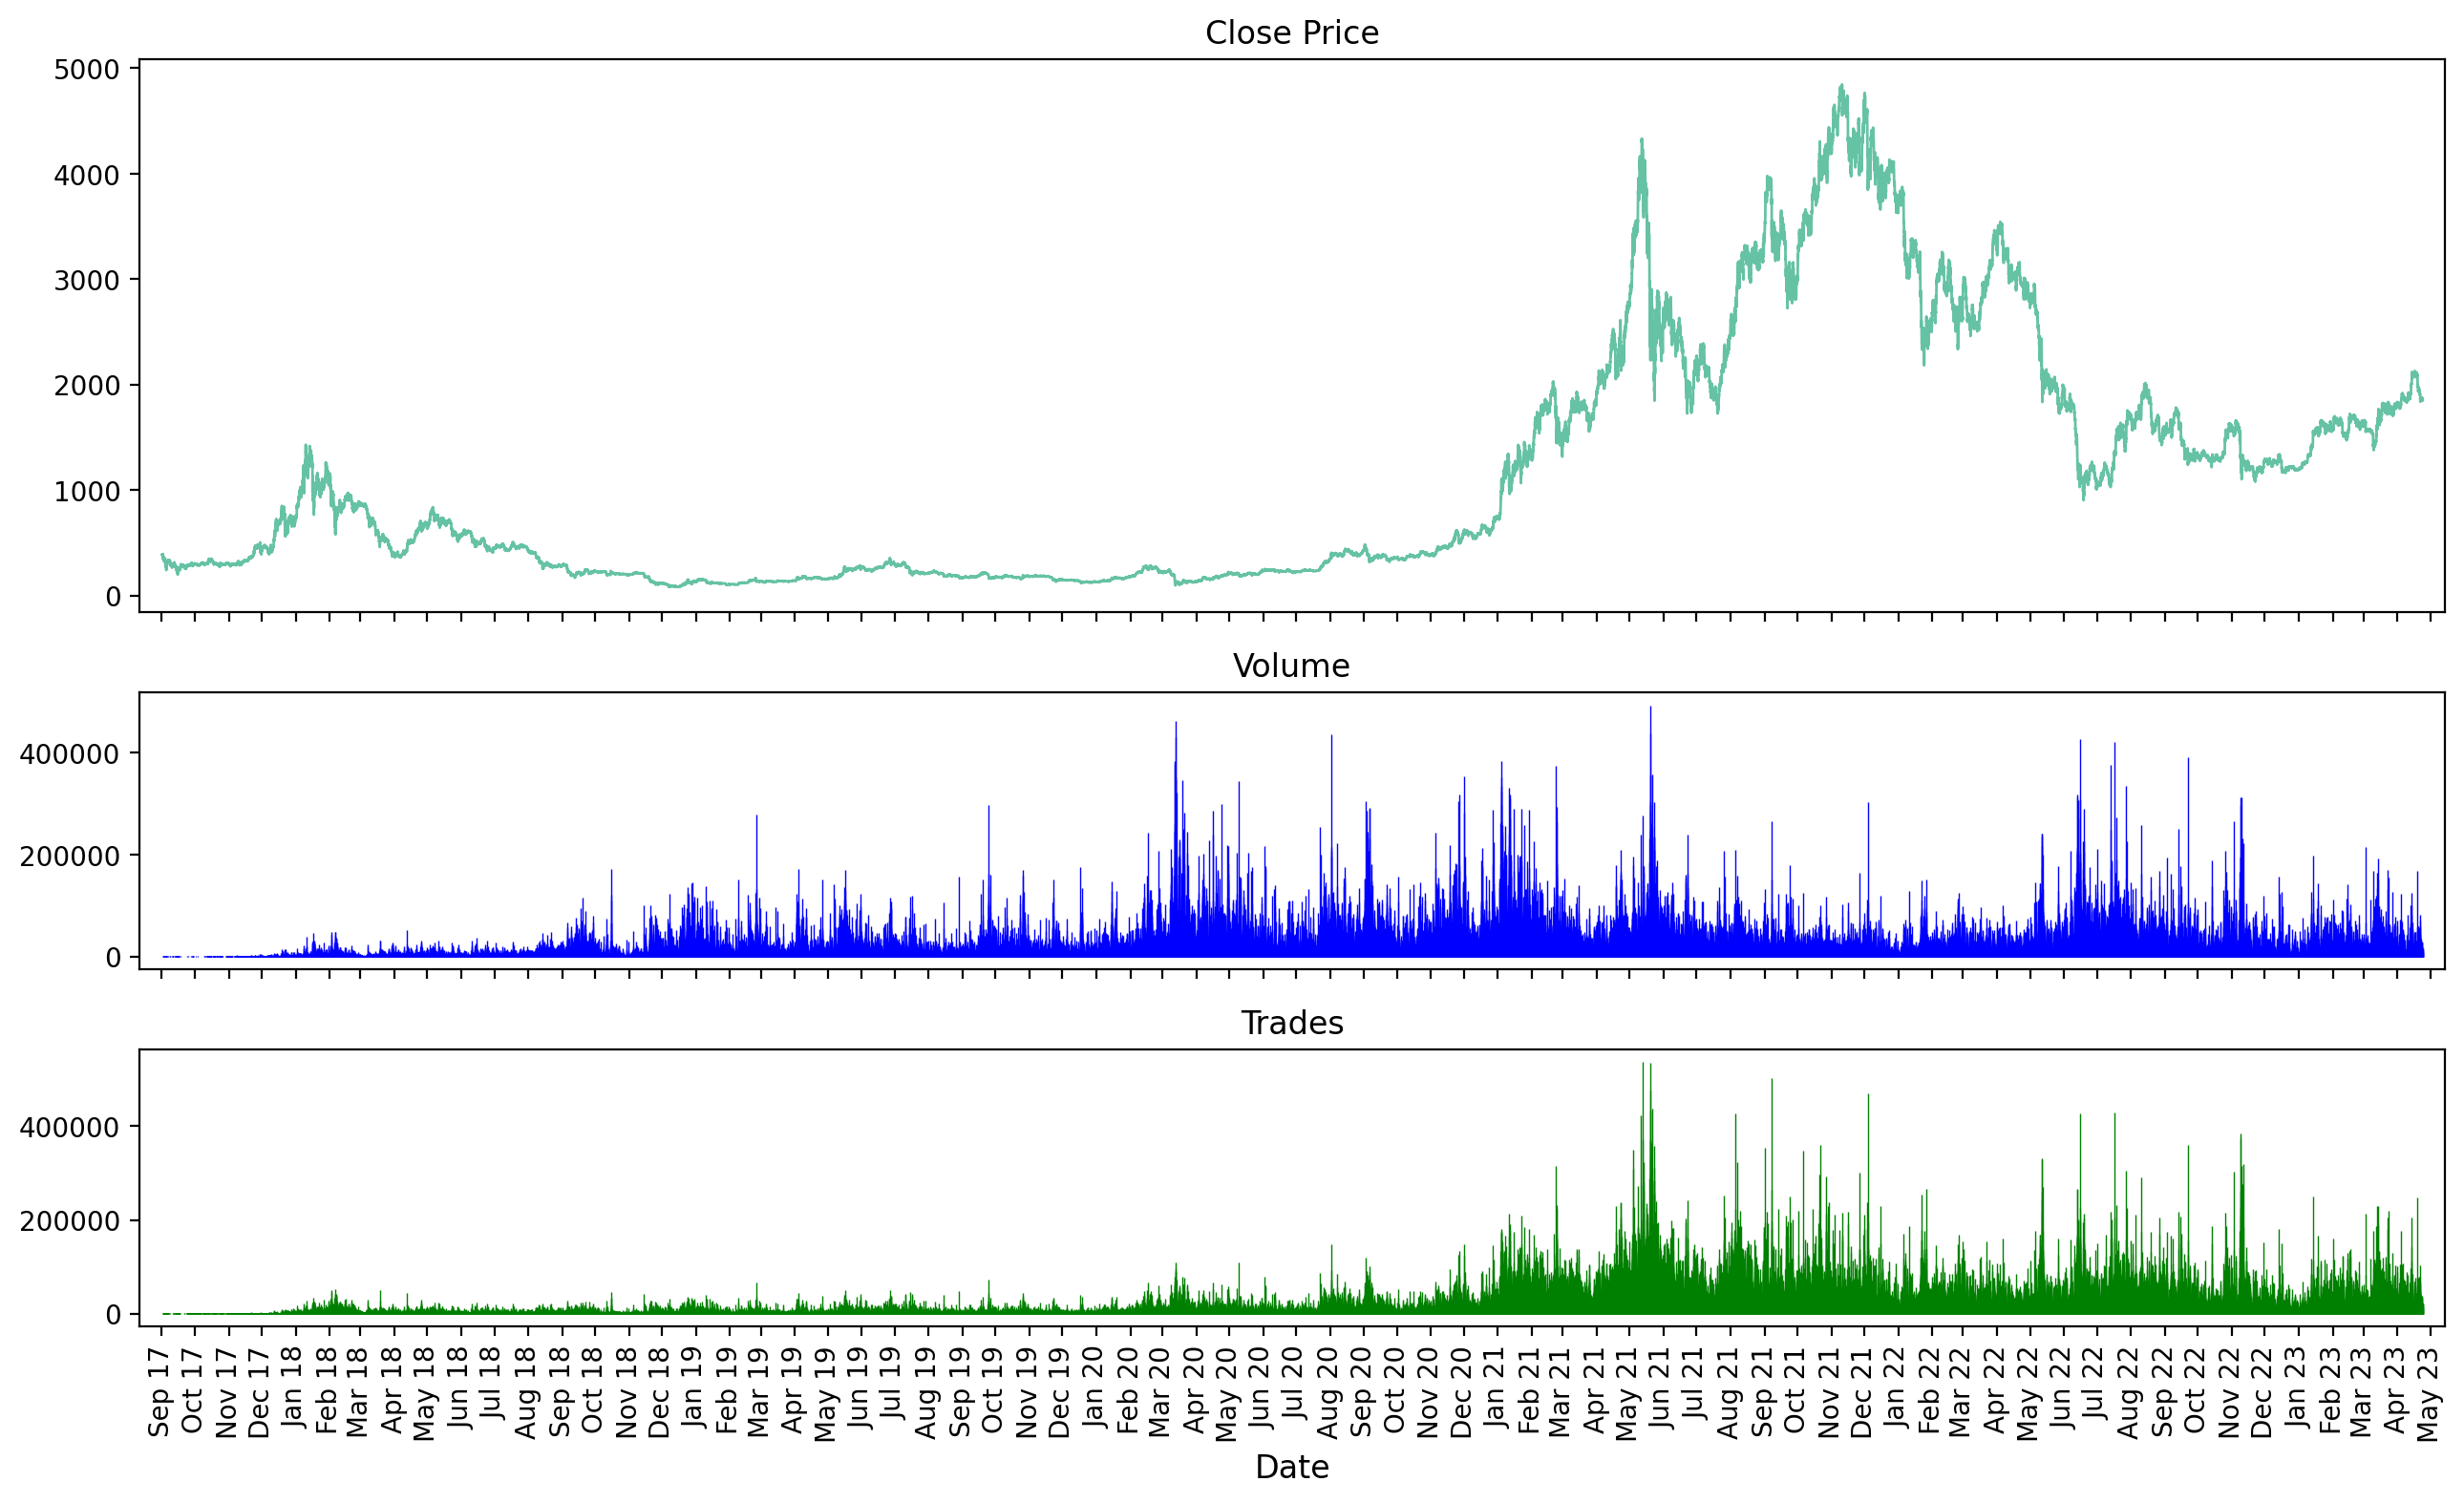

In [8]:
plot_chart(df)

На графике видно, что до 18 года объемов и сделок практически нет.

Торговля на бирже данным фьючерсом началась в сентябре 17 года и первые месяцы инструмент рассторговывался.

Этот период малорепрезентативен. Первые пол года в последстивии, после добавления технических индикаторов удалю.

# Обработка пропусков

In [9]:
pd.DataFrame({"% NaN": df.isnull().mean() * 100, "Num NaN": df.isnull().sum()})

% NaN  Num NaN
Open    0.256752      127
High    0.256752      127
Low     0.256752      127
Close   0.256752      127
Volume  0.256752      127
Trades  0.256752      127

Количество пропусков 0.26% и всего 127 наблюдений

Создаю датафрейм состоящий только из пропусков для более детального анализа

In [10]:
nan_mask = df.isna().any(axis=1)
nan_df = df[nan_mask].copy()
nan_df.reset_index(inplace=True)

nan_df

Datetime  Open  High  Low  Close  Volume  Trades
0   2017-09-06 16:00:00   NaN   NaN  NaN    NaN     NaN     NaN
1   2017-09-06 17:00:00   NaN   NaN  NaN    NaN     NaN     NaN
2   2017-09-06 18:00:00   NaN   NaN  NaN    NaN     NaN     NaN
3   2017-09-06 19:00:00   NaN   NaN  NaN    NaN     NaN     NaN
4   2017-09-06 20:00:00   NaN   NaN  NaN    NaN     NaN     NaN
..                  ...   ...   ...  ...    ...     ...     ...
122 2021-08-13 04:00:00   NaN   NaN  NaN    NaN     NaN     NaN
123 2021-08-13 05:00:00   NaN   NaN  NaN    NaN     NaN     NaN
124 2021-09-29 07:00:00   NaN   NaN  NaN    NaN     NaN     NaN
125 2021-09-29 08:00:00   NaN   NaN  NaN    NaN     NaN     NaN
126 2023-03-24 13:00:00   NaN   NaN  NaN    NaN     NaN     NaN

[127 rows x 7 columns]

Произвожу группировку по датам что бы понять сколько групп(кластеров) пропусков и какой они продолжительности по времени

In [11]:
nan_df["Date"] = nan_df["Datetime"].dt.date

nan_group_df = (
    nan_df.groupby(by="Date")
    .agg({"Datetime": "first", "Date": "count"})
    .reset_index(drop=True)
)
nan_group_df.columns = ["Begin NaN period", "Duration Hours"]

nan_group_df

Begin NaN period  Duration Hours
0  2017-09-06 16:00:00               7
1  2018-01-04 04:00:00               1
2  2018-02-08 01:00:00              23
3  2018-02-09 00:00:00               9
4  2018-06-26 02:00:00              10
5  2018-06-27 13:00:00               1
6  2018-07-04 01:00:00               7
7  2018-10-19 06:00:00               3
8  2018-11-14 02:00:00               7
9  2019-03-12 02:00:00               6
10 2019-05-15 03:00:00              10
11 2019-08-15 02:00:00               8
12 2019-11-13 02:00:00               2
13 2019-11-25 02:00:00               2
14 2020-02-09 02:00:00               1
15 2020-02-19 12:00:00               5
16 2020-03-04 10:00:00               1
17 2020-04-25 02:00:00               2
18 2020-06-28 02:00:00               3
19 2020-11-30 06:00:00               1
20 2020-12-21 15:00:00               3
21 2020-12-25 02:00:00               1
22 2021-02-11 04:00:00               1
23 2021-03-06 02:00:00               1
24 2021-04-20 02:00:00               2
25 2021-04-25 05:00:00               3
26 2021-08-13 02:00:00               4
27 2021-09-29 07:00:00               2
28 2023-03-24 13:00:00               1

In [12]:
nan_group_df.describe()

Begin NaN period  Duration Hours
count                             29       29.000000
mean   2019-12-14 04:04:08.275862016        4.379310
min              2017-09-06 16:00:00        1.000000
25%              2018-10-19 06:00:00        1.000000
50%              2020-02-09 02:00:00        3.000000
75%              2020-12-25 02:00:00        7.000000
max              2023-03-24 13:00:00       23.000000
std                              NaN        4.655364

- Всего 29 кластеров где были пропуски (не было торгов на Binance по какой-либо причине)
- Продолжительность пропусков от 1 до 23 часов

### Визуализирую несколько пропусков на графиках в окружении

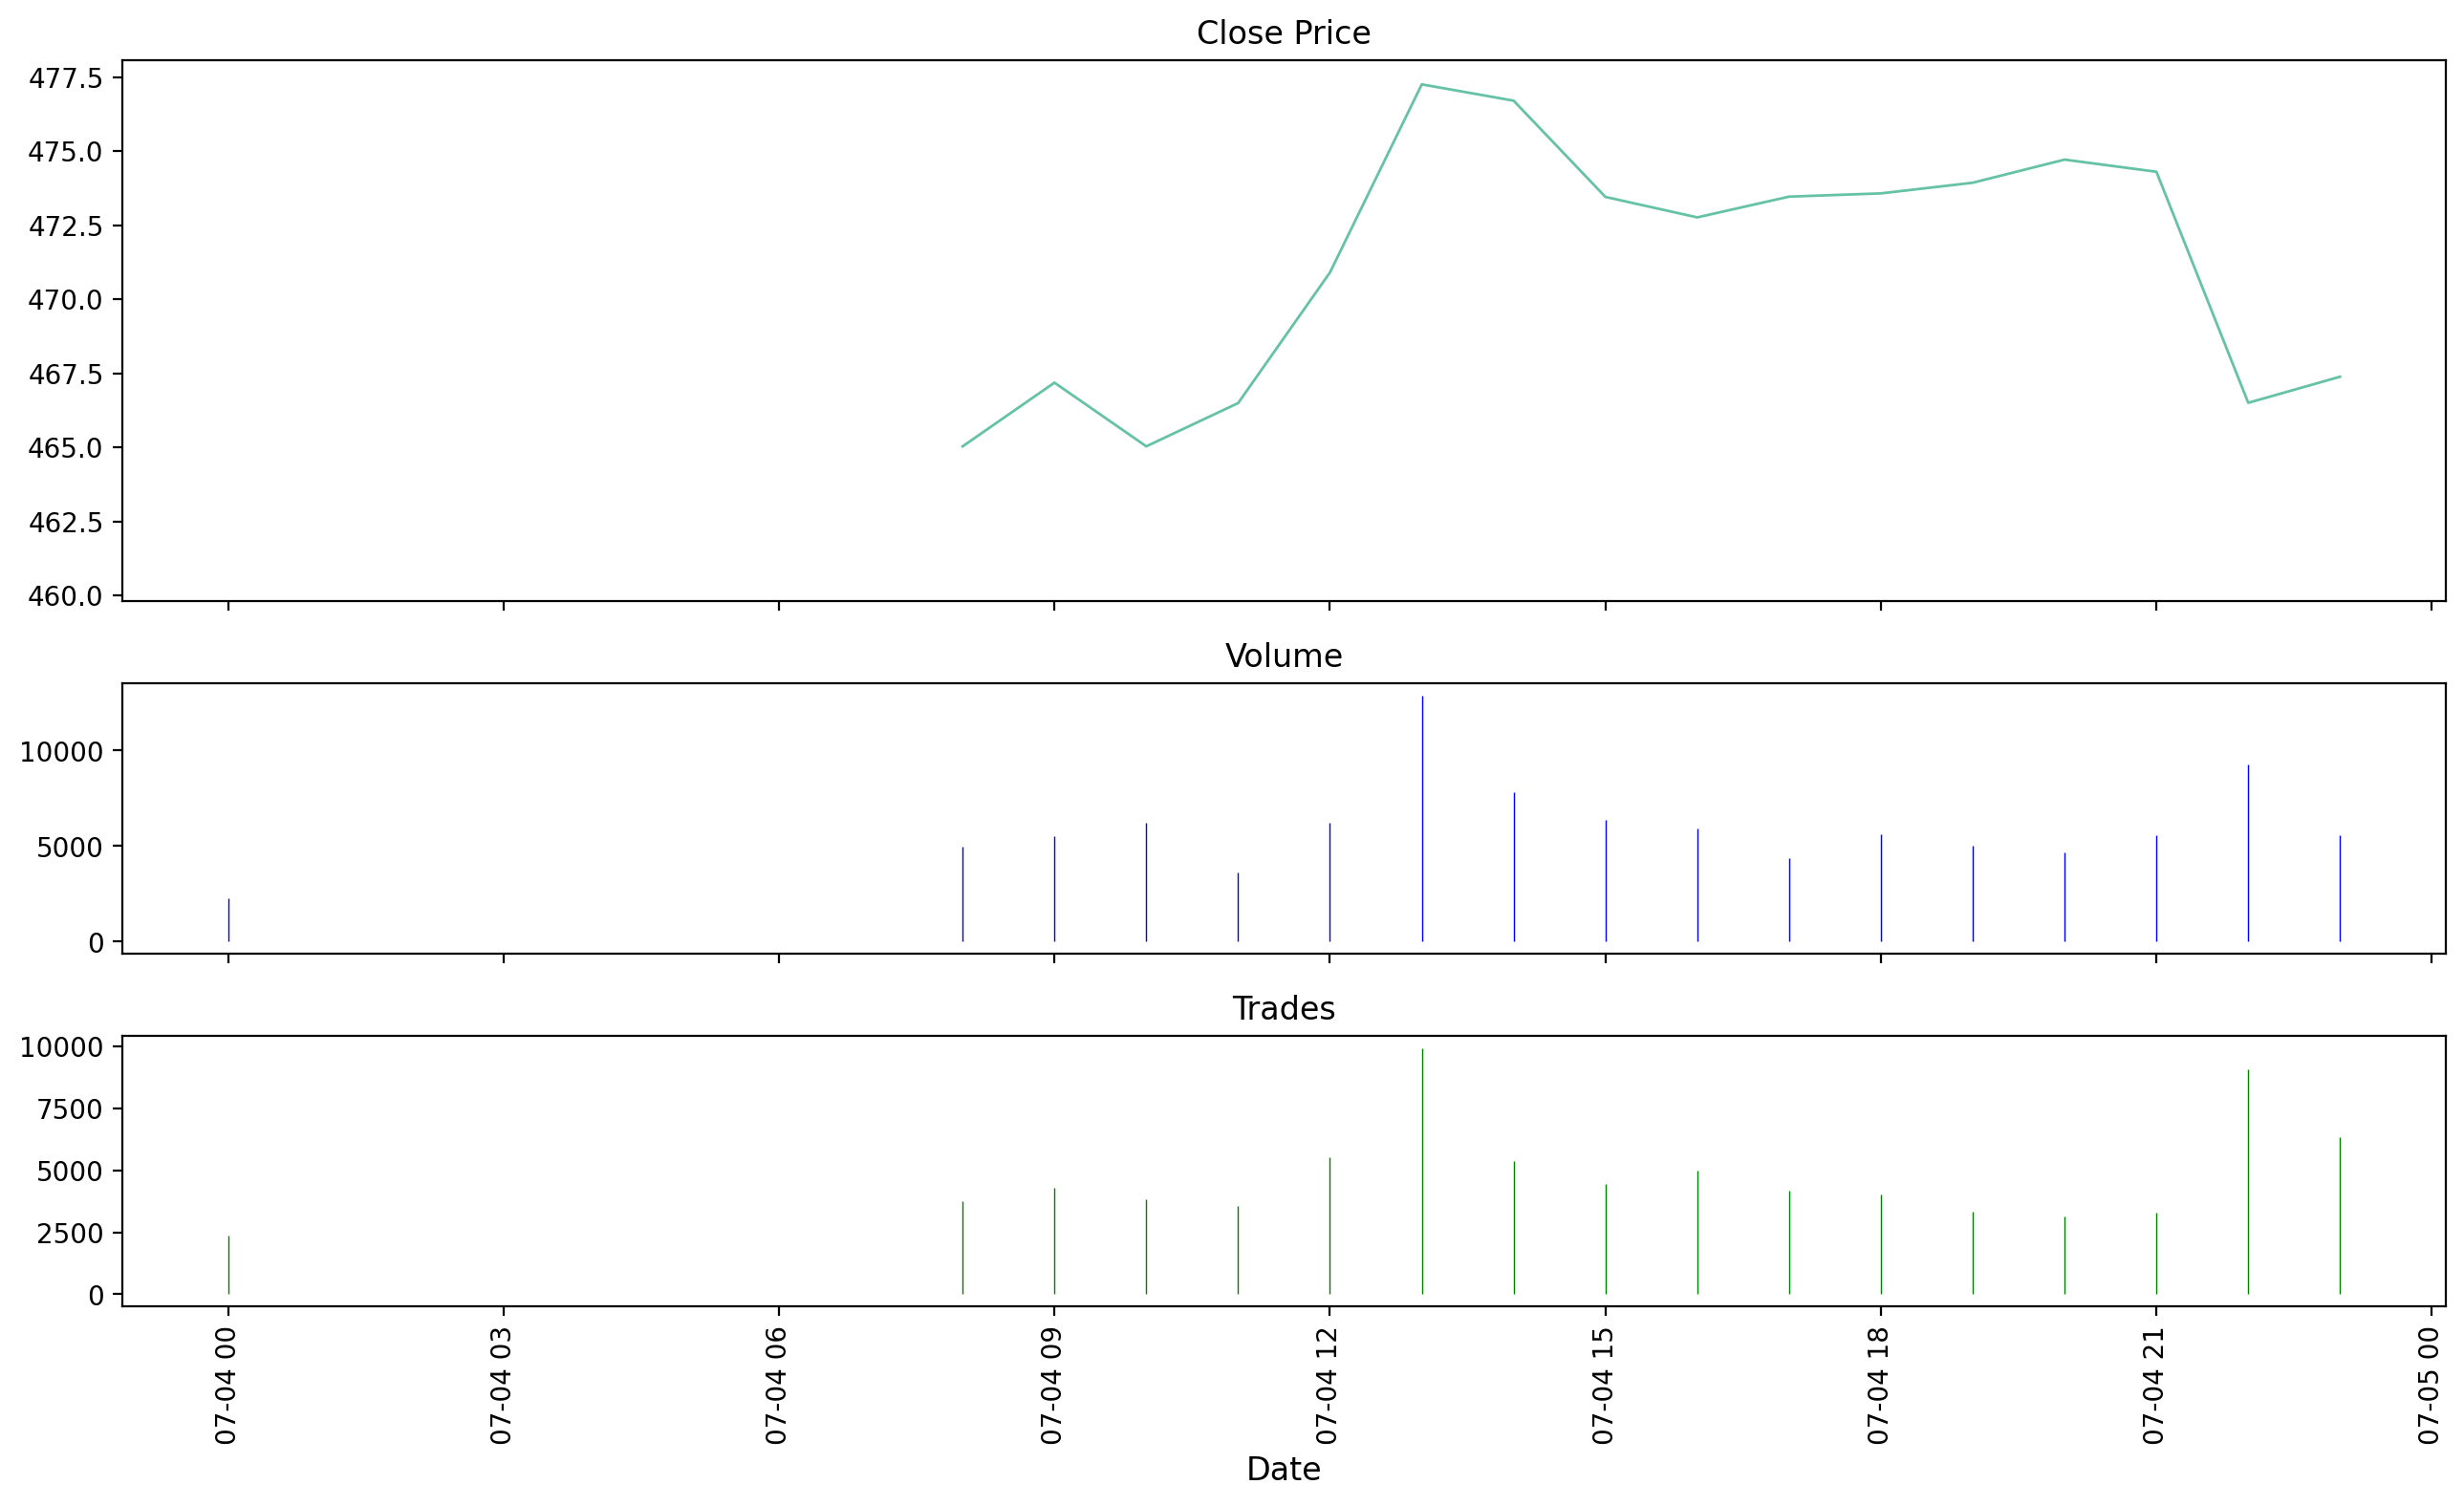

In [13]:
plot_chart(df, "2018-07-04", 24, False)

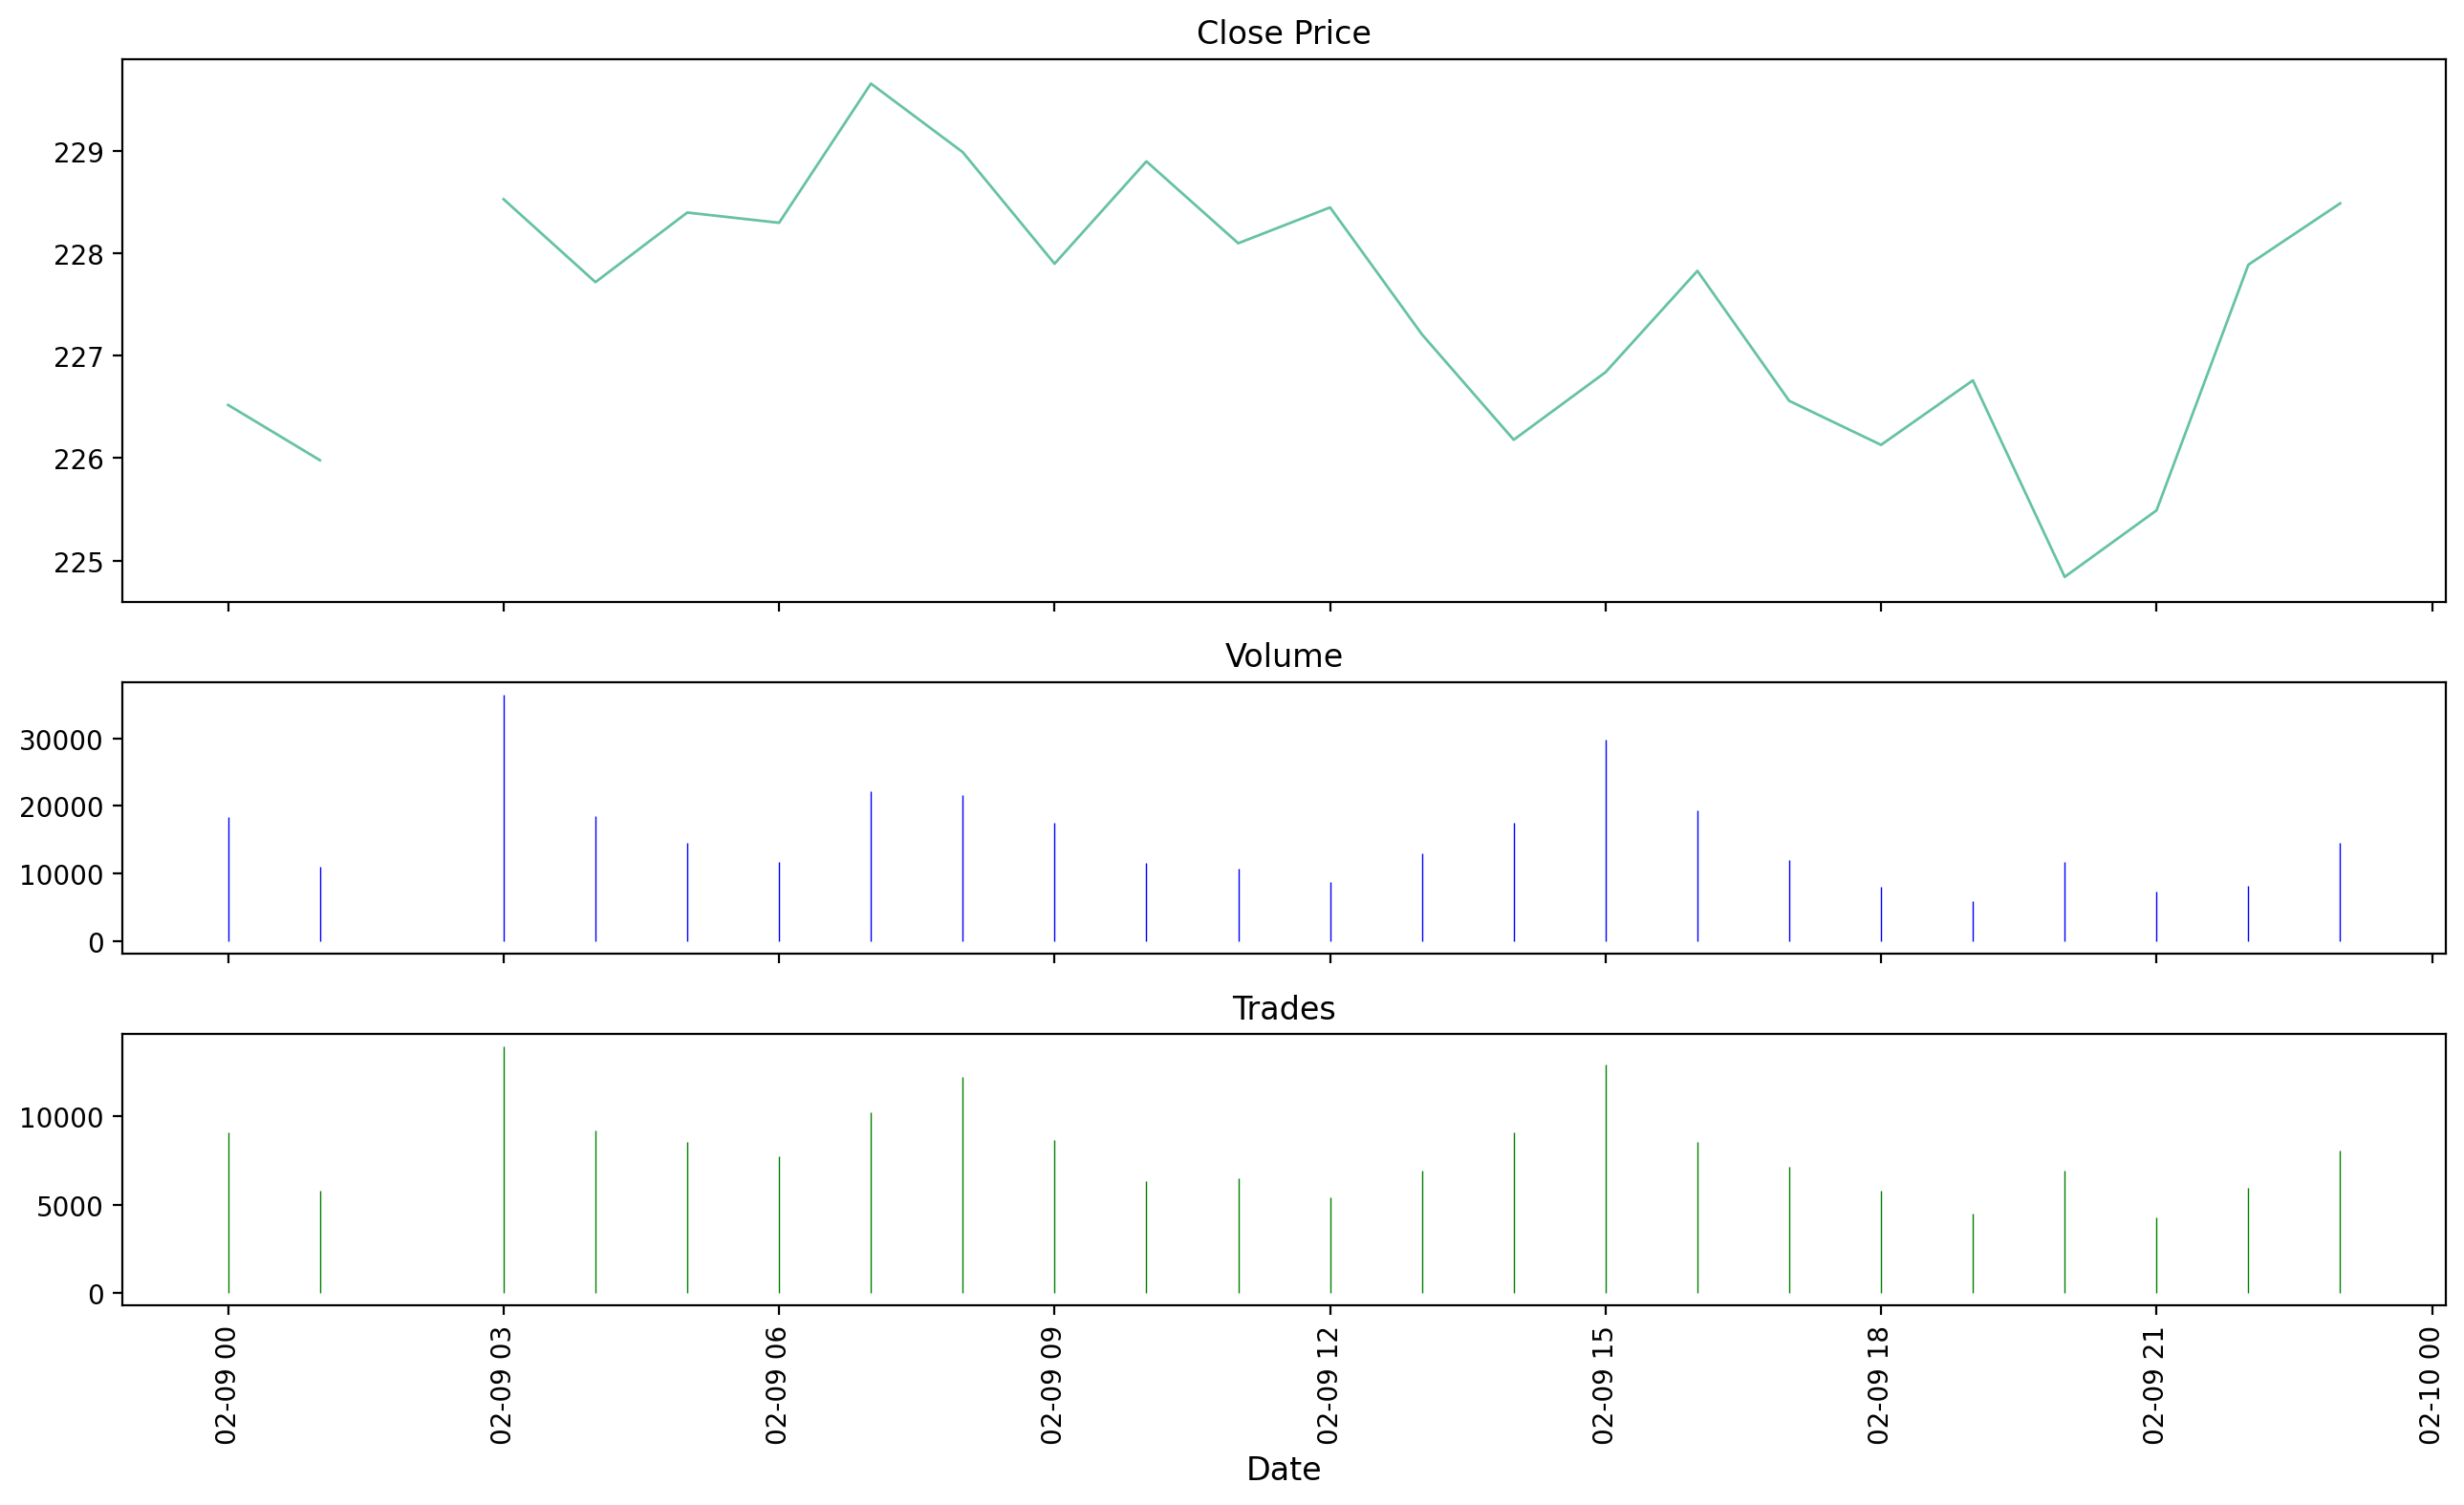

In [14]:
plot_chart(df, "2020-02-09", 24, False)

Полагаю, что самый правильный вариант заполнения пропусков - это обогащение датасета скоректированными кусками истории с других бирж, где в это время шла торговля.

Но данный вариант достаточно времязатратный и в связи с крошечным количеством пропусков не принесет существенных улучшений.

### Заполнение пропусков с помощью интерполяции
- ценовые признаки заполняю чистой интерполяцией
- признаки объемов заполняю средним значением до и после пропуска

In [15]:
def fillna_in_df(df):
    """
    Fill missing values in the DataFrame.

    For price columns ('Open', 'High', 'Low', 'Close'), it uses linear interpolation.
    For volume columns ('Volume', 'Trades'), it fills NaN values with an average of
    the forward fill and backward fill.

    Parameters:
    -----------
    df : DataFrame
        Input DataFrame with price and volume columns.

    Returns:
    --------
    DataFrame
        DataFrame with missing values filled.
    """

    # Columns to fill using interpolation
    prices_cols = ["Open", "High", "Low", "Close"]

    # Columns to fill using an average of forward fill and backward fill
    vols_cols = ["Volume", "Trades"]

    # Check if the dataframe contains the necessary columns
    for col_list in [prices_cols, vols_cols]:
        for col in col_list:
            if col not in df.columns:
                raise ValueError(f"DataFrame doesn't contain the column '{col}'")

    def fill_mean_before_after(feature_series):
        """Utility function to fill NaN values using the average of forward and backward fill."""
        # Forward fill NaN values
        ffilled = feature_series.fillna(method="ffill")

        # Backward fill NaN values
        bfilled = feature_series.fillna(method="bfill")

        # Average the two filled series
        return (ffilled + bfilled) / 2

    # Fill missing values using linear interpolation for price columns
    df[prices_cols] = df[prices_cols].interpolate(method="linear")

    # Apply the utility function for volume columns
    for col in vols_cols:
        df[col] = fill_mean_before_after(df[col])

    return df

In [16]:
df = fillna_in_df(df)

### Проверяю есть ли пропуски
Визуально на отдельных кластерах

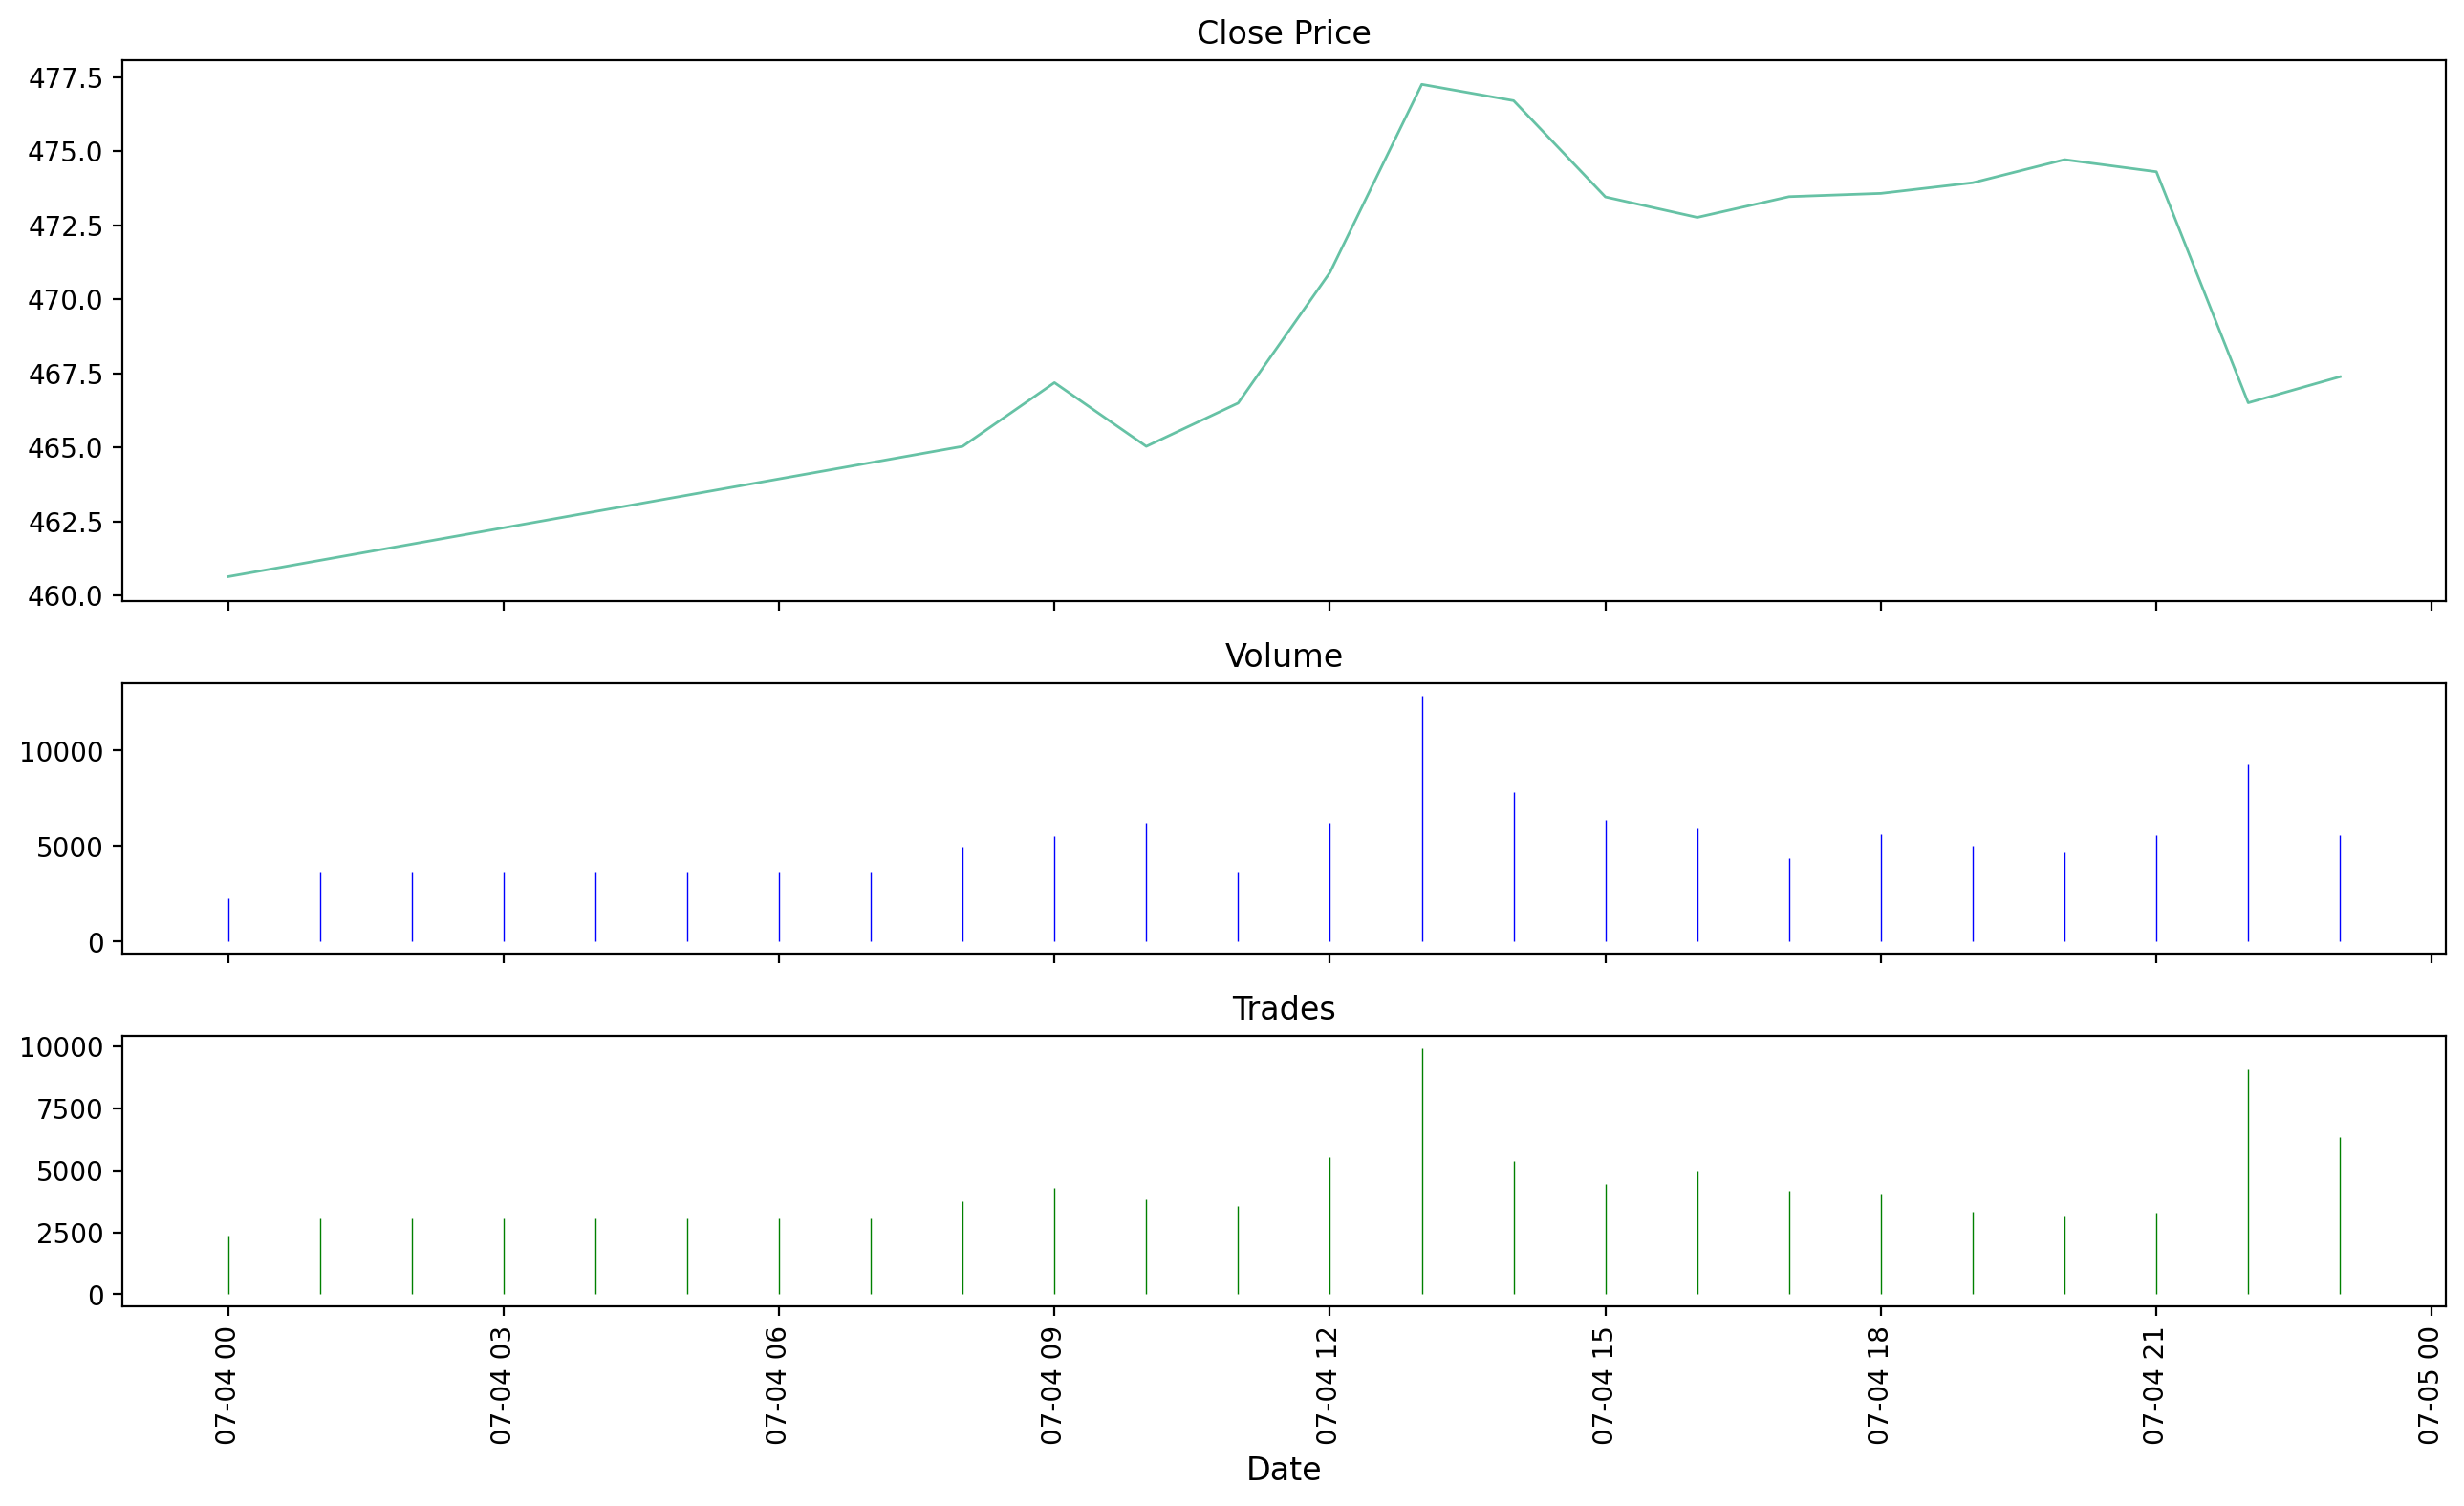

In [16]:
plot_chart(df, "2018-07-04", 24, False)

И кодом, полностью на всем датафрейме

In [20]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Trades    0
dtype: int64

Пропусков больше нет

# Статистические тесты
### Провека признаков на стационарность

In [22]:
for col in df.columns:
    print("Column Name : ", col)
    hd.adf(df[col].values)
    print()

Column Name :  Open
Test-Statistic: -1.4964268036462294
P-Value: 0.5352782016787097
Time series is non-stationary

Column Name :  High
Test-Statistic: -1.4839251988828863
P-Value: 0.5414477978453791
Time series is non-stationary

Column Name :  Low
Test-Statistic: -1.4994398057813991
P-Value: 0.5337884407564848
Time series is non-stationary

Column Name :  Close
Test-Statistic: -1.4990928496803395
P-Value: 0.5339600453769041
Time series is non-stationary

Column Name :  Volume
Test-Statistic: -11.769000357678316
P-Value: 1.1013924079238046e-21
Time series is stationary!

Column Name :  Trades
Test-Statistic: -8.492948827509238
P-Value: 1.298573943118501e-13
Time series is stationary!



Volume, Trades стационарны. А ценовые признаки обязательно нужно перобразовывать.

### Изучение распределений признаков

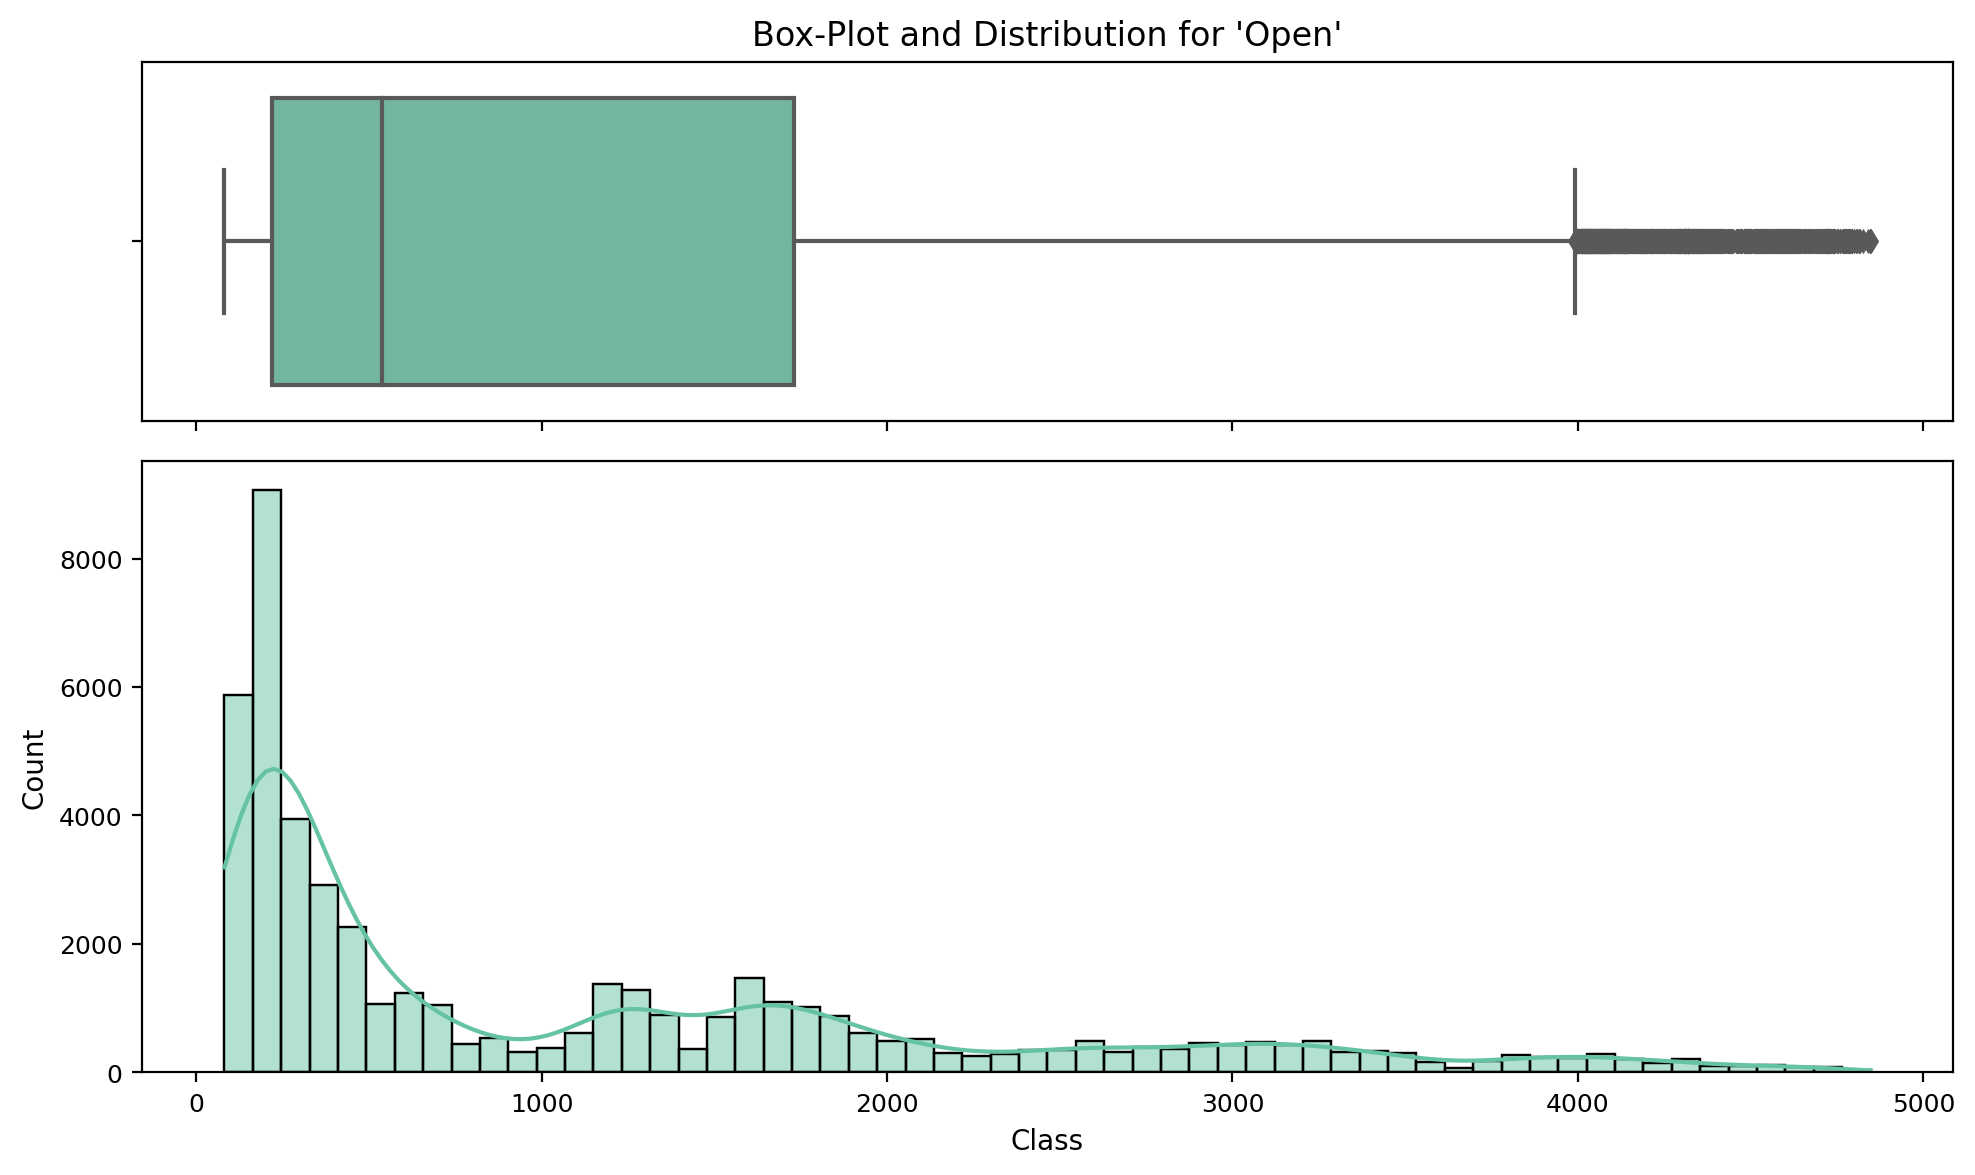

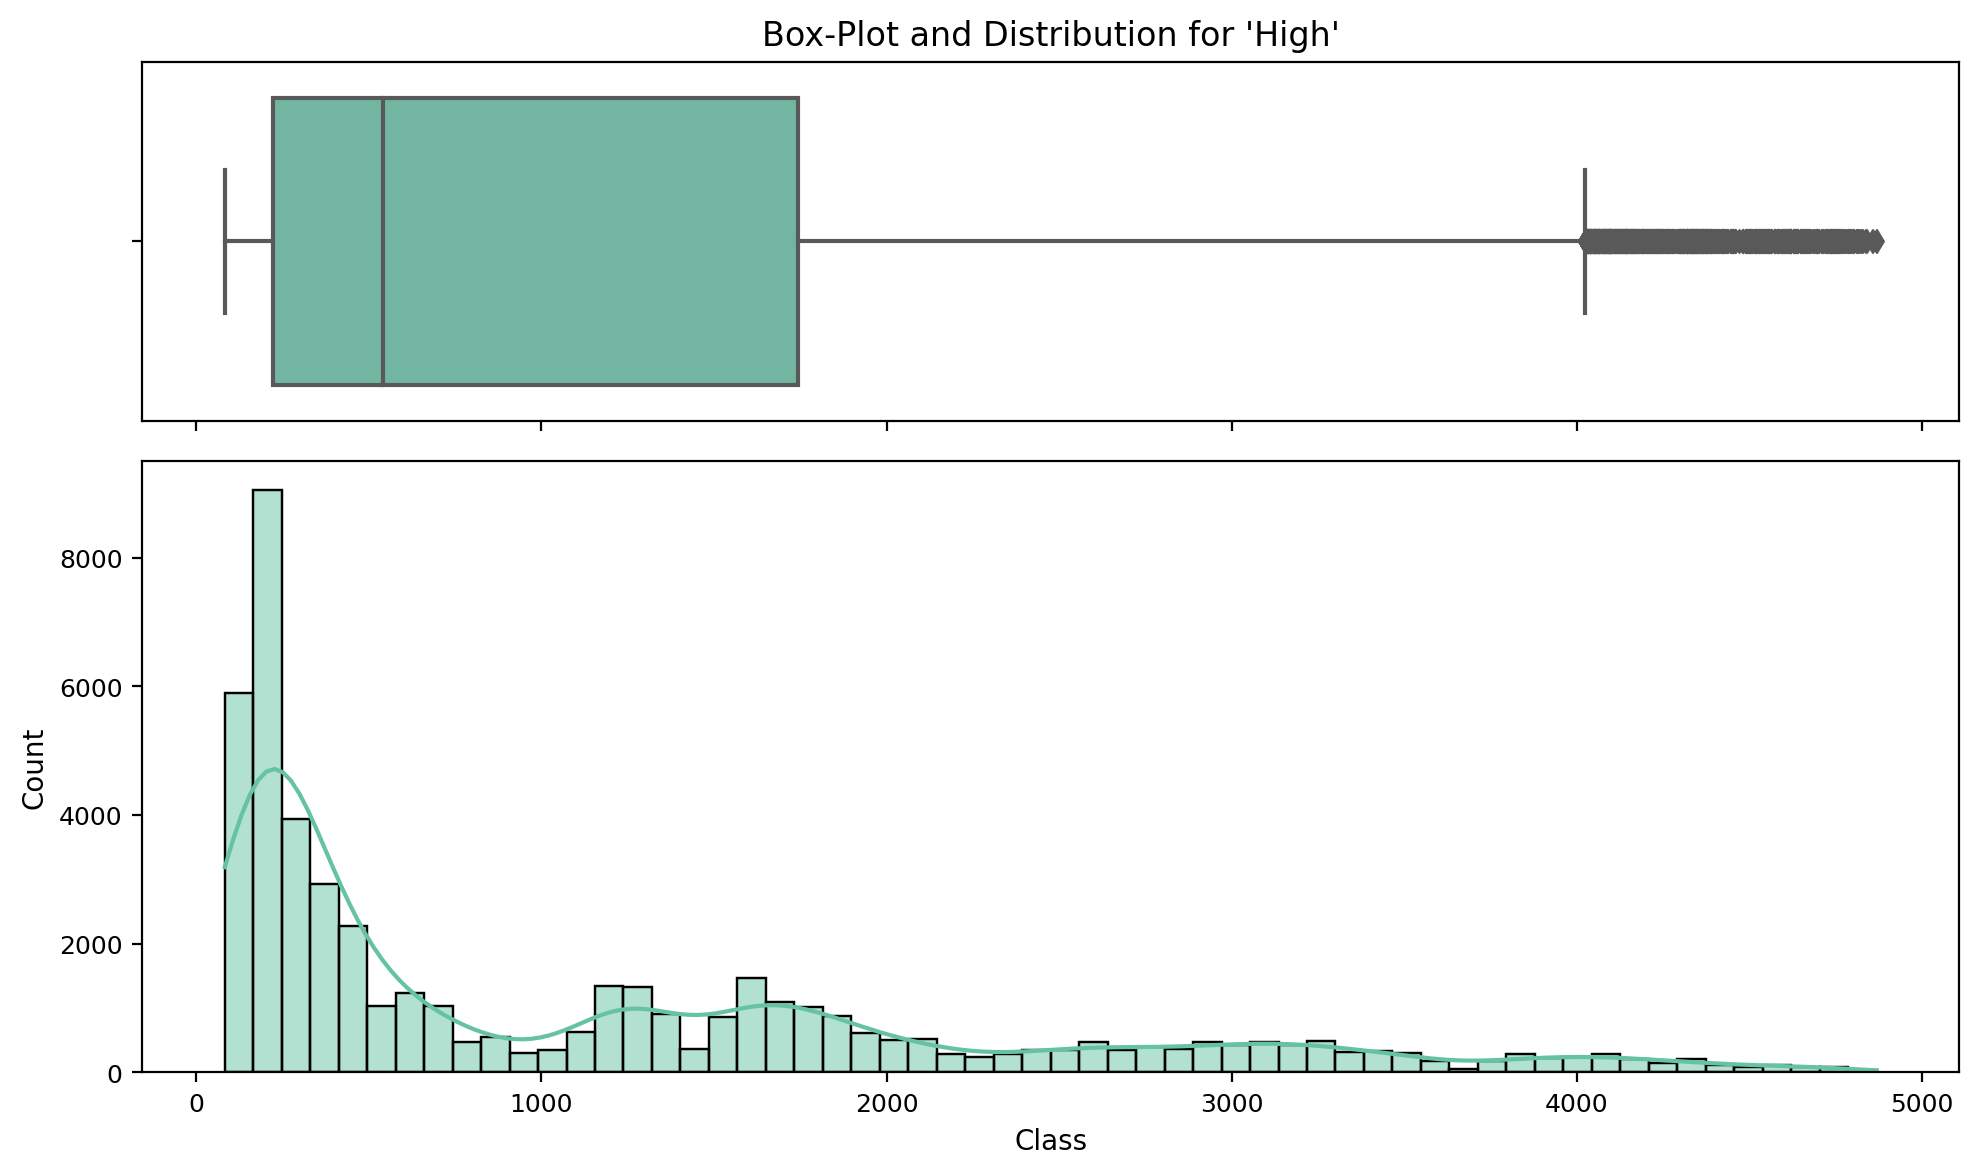

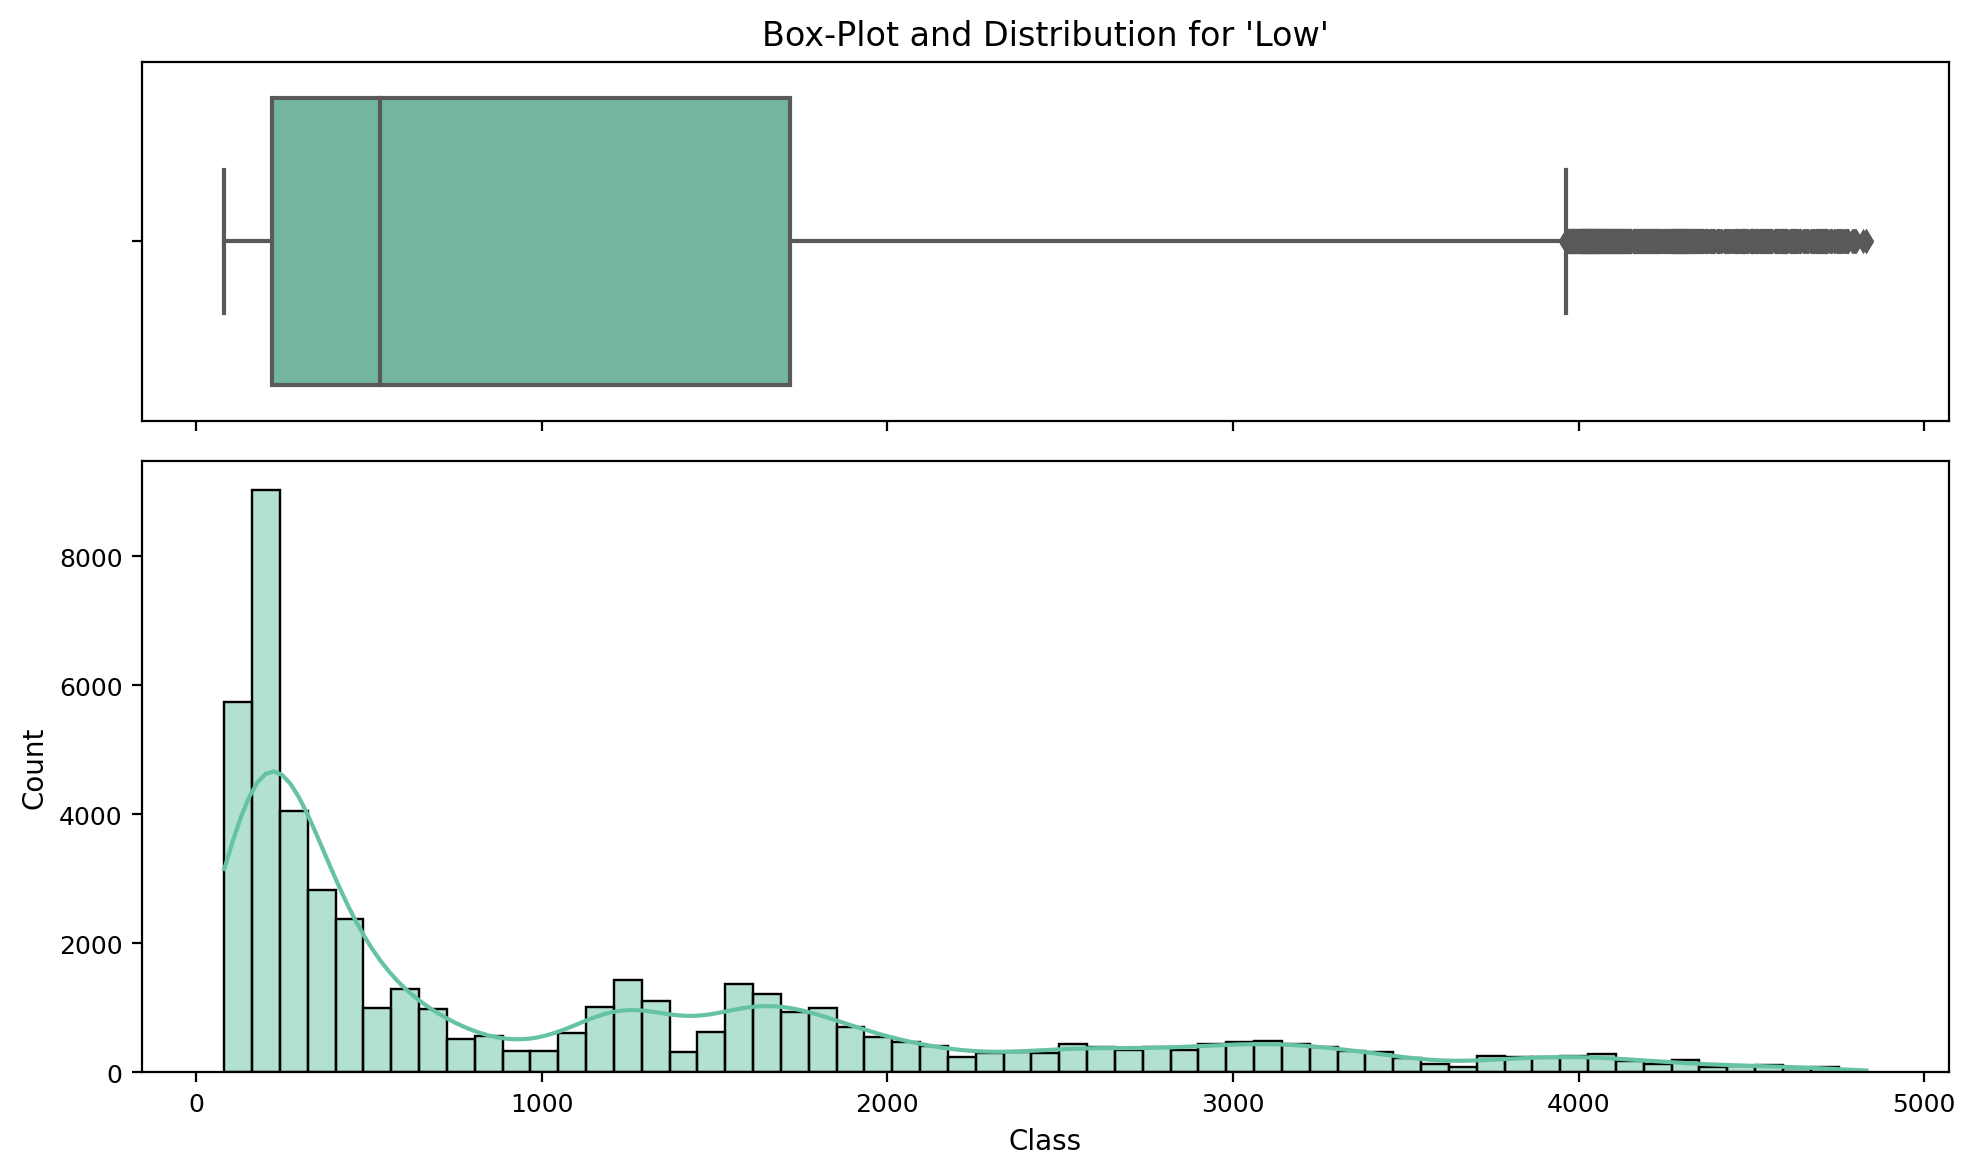

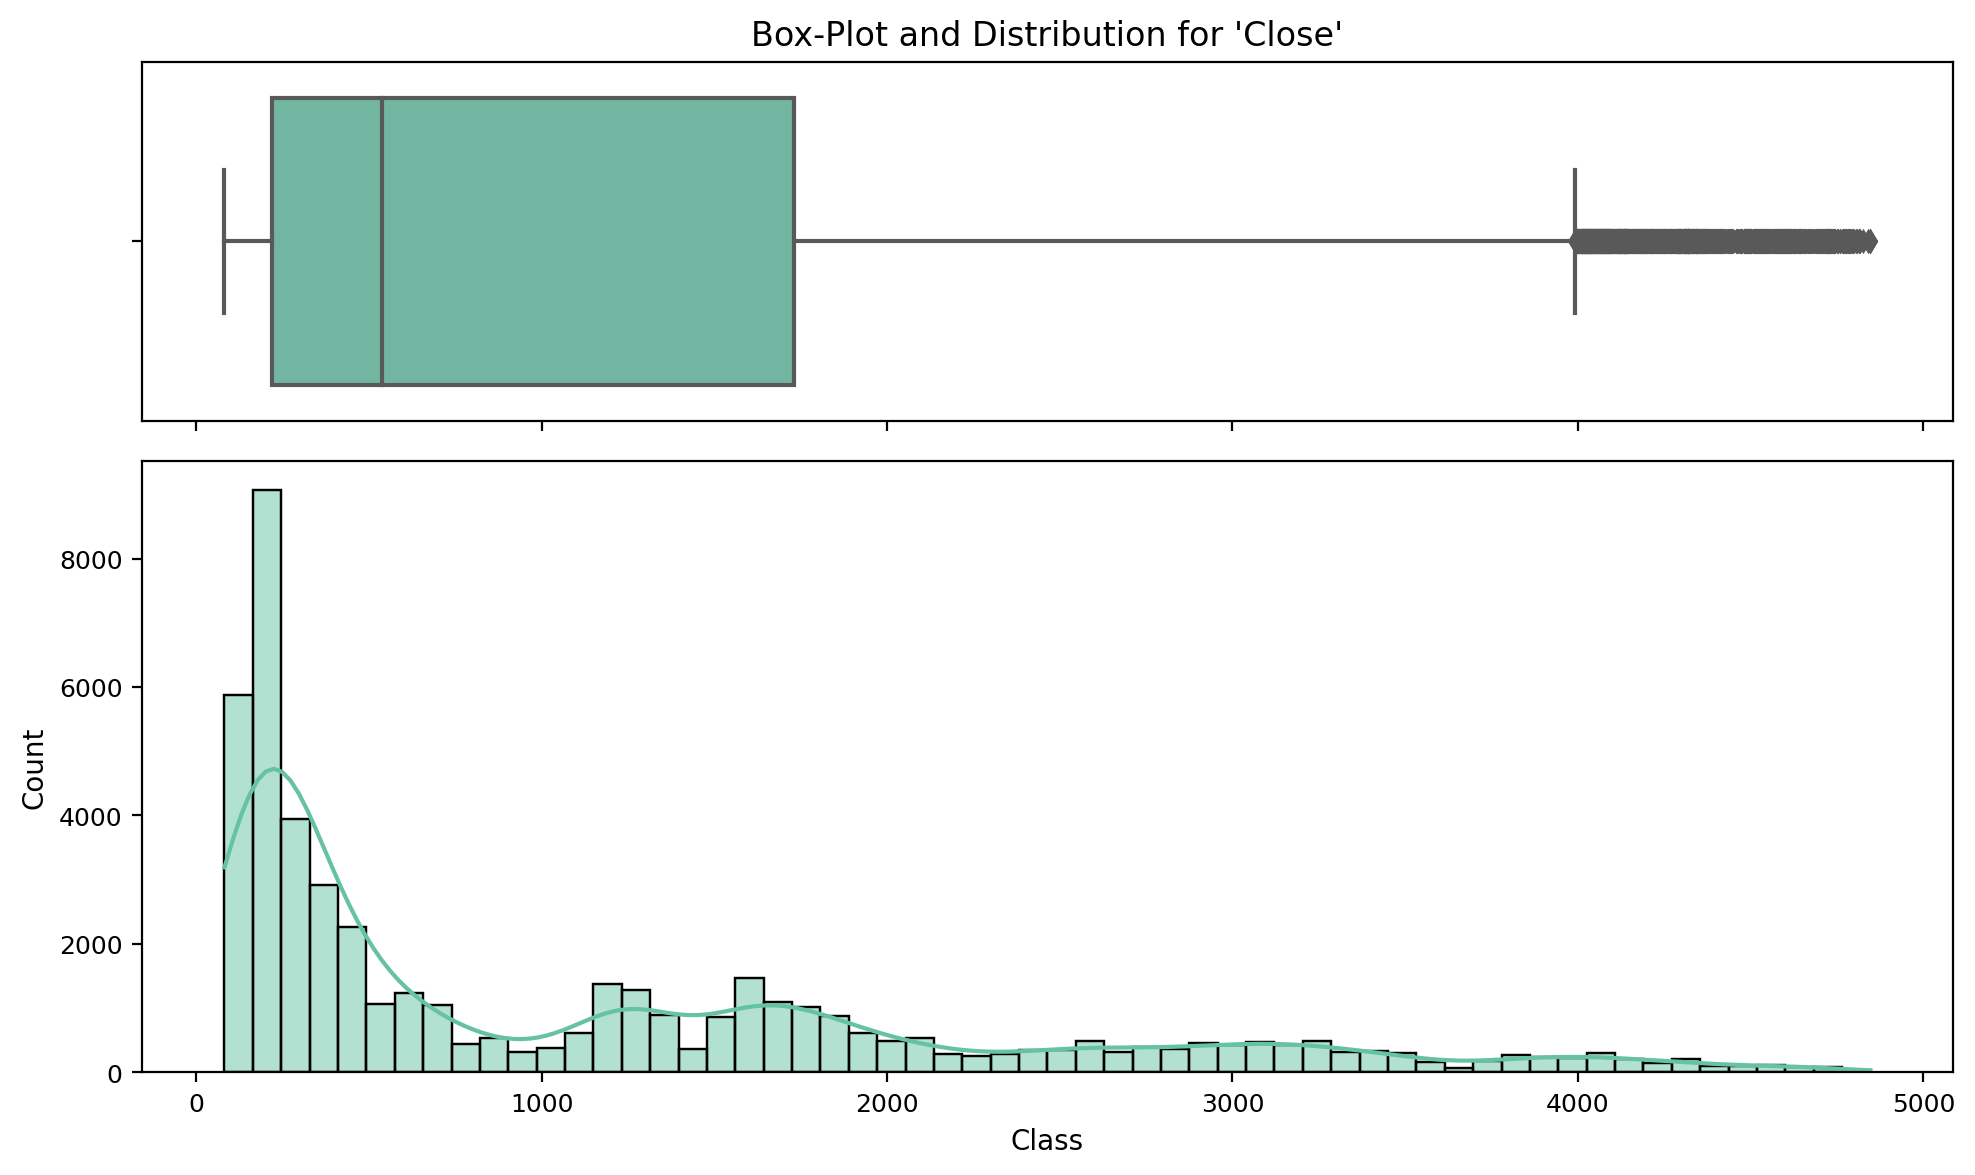

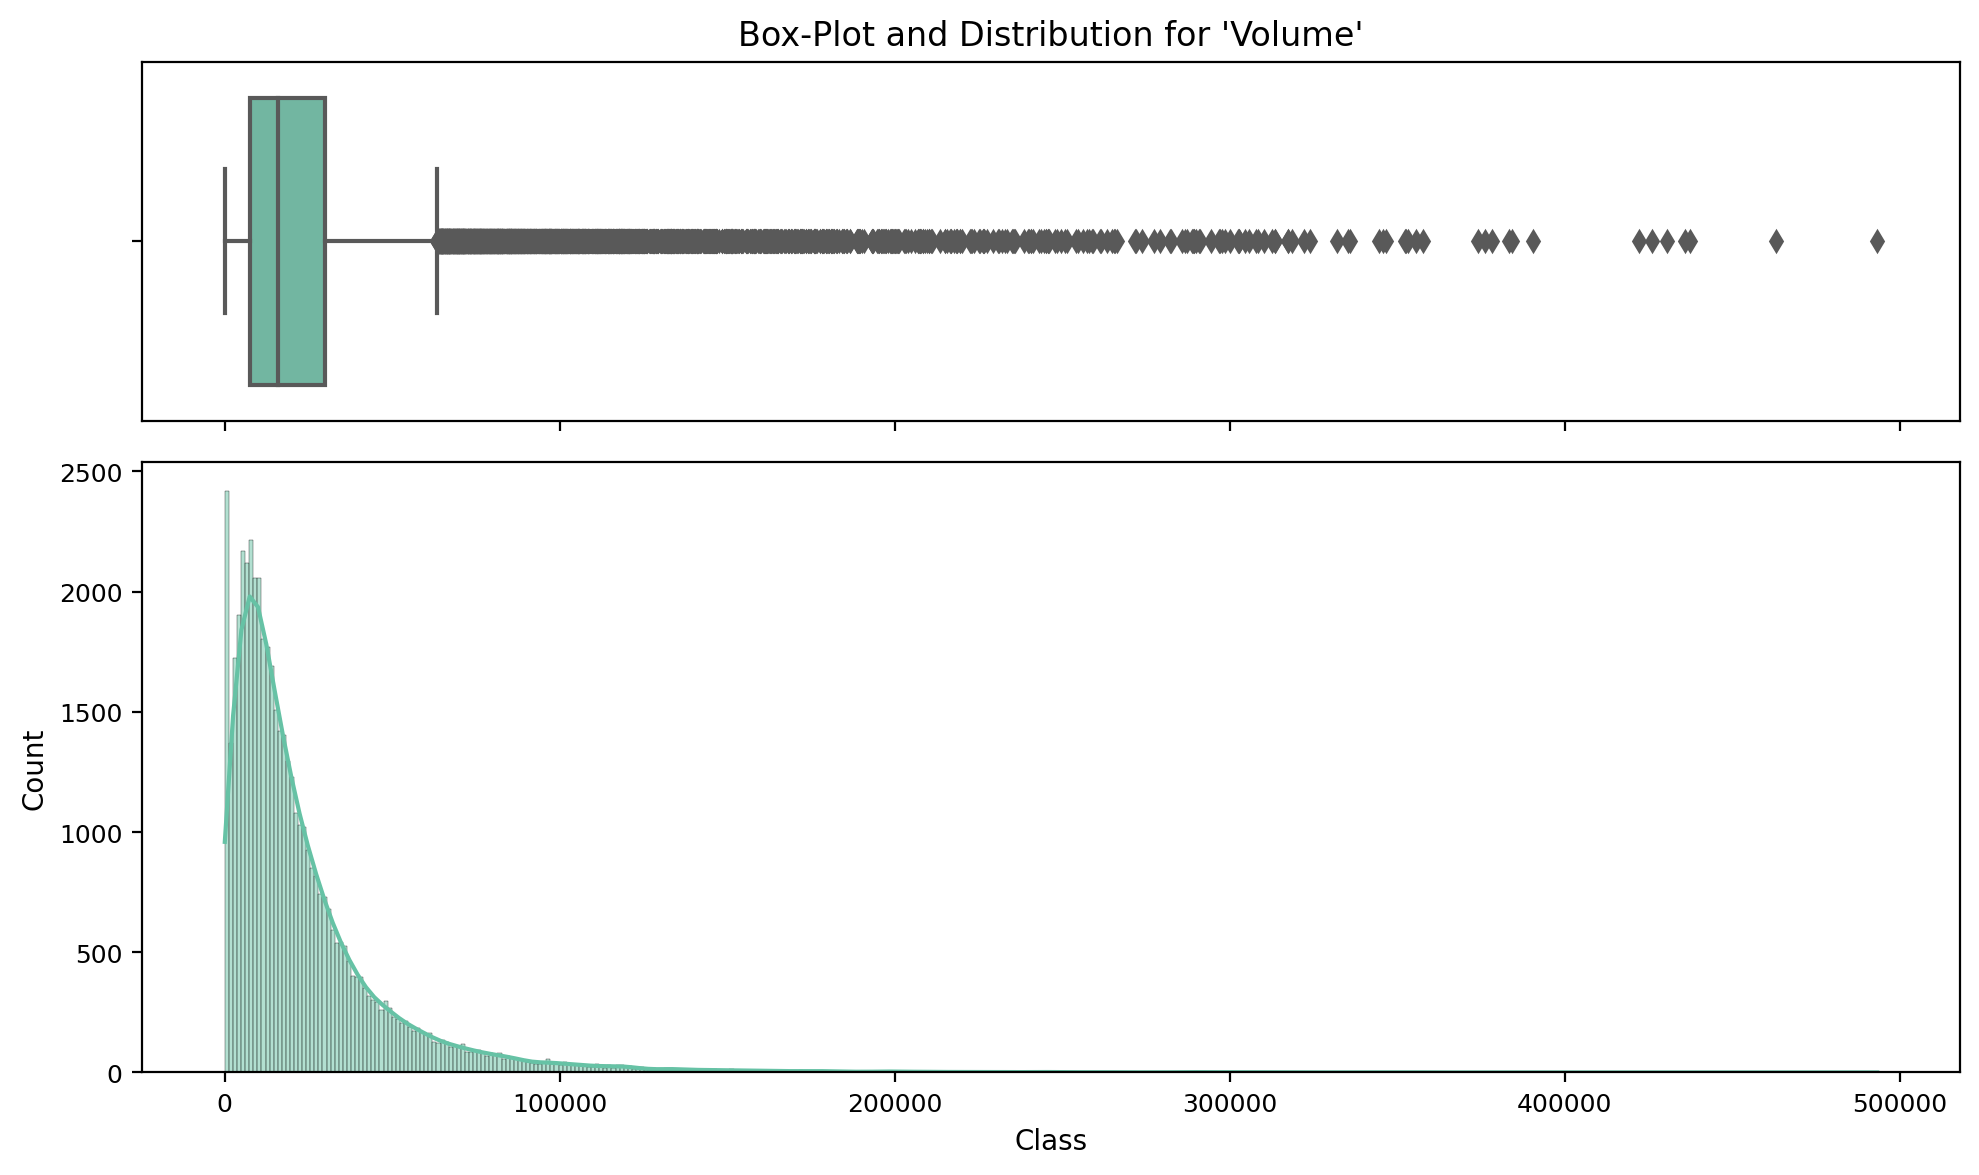

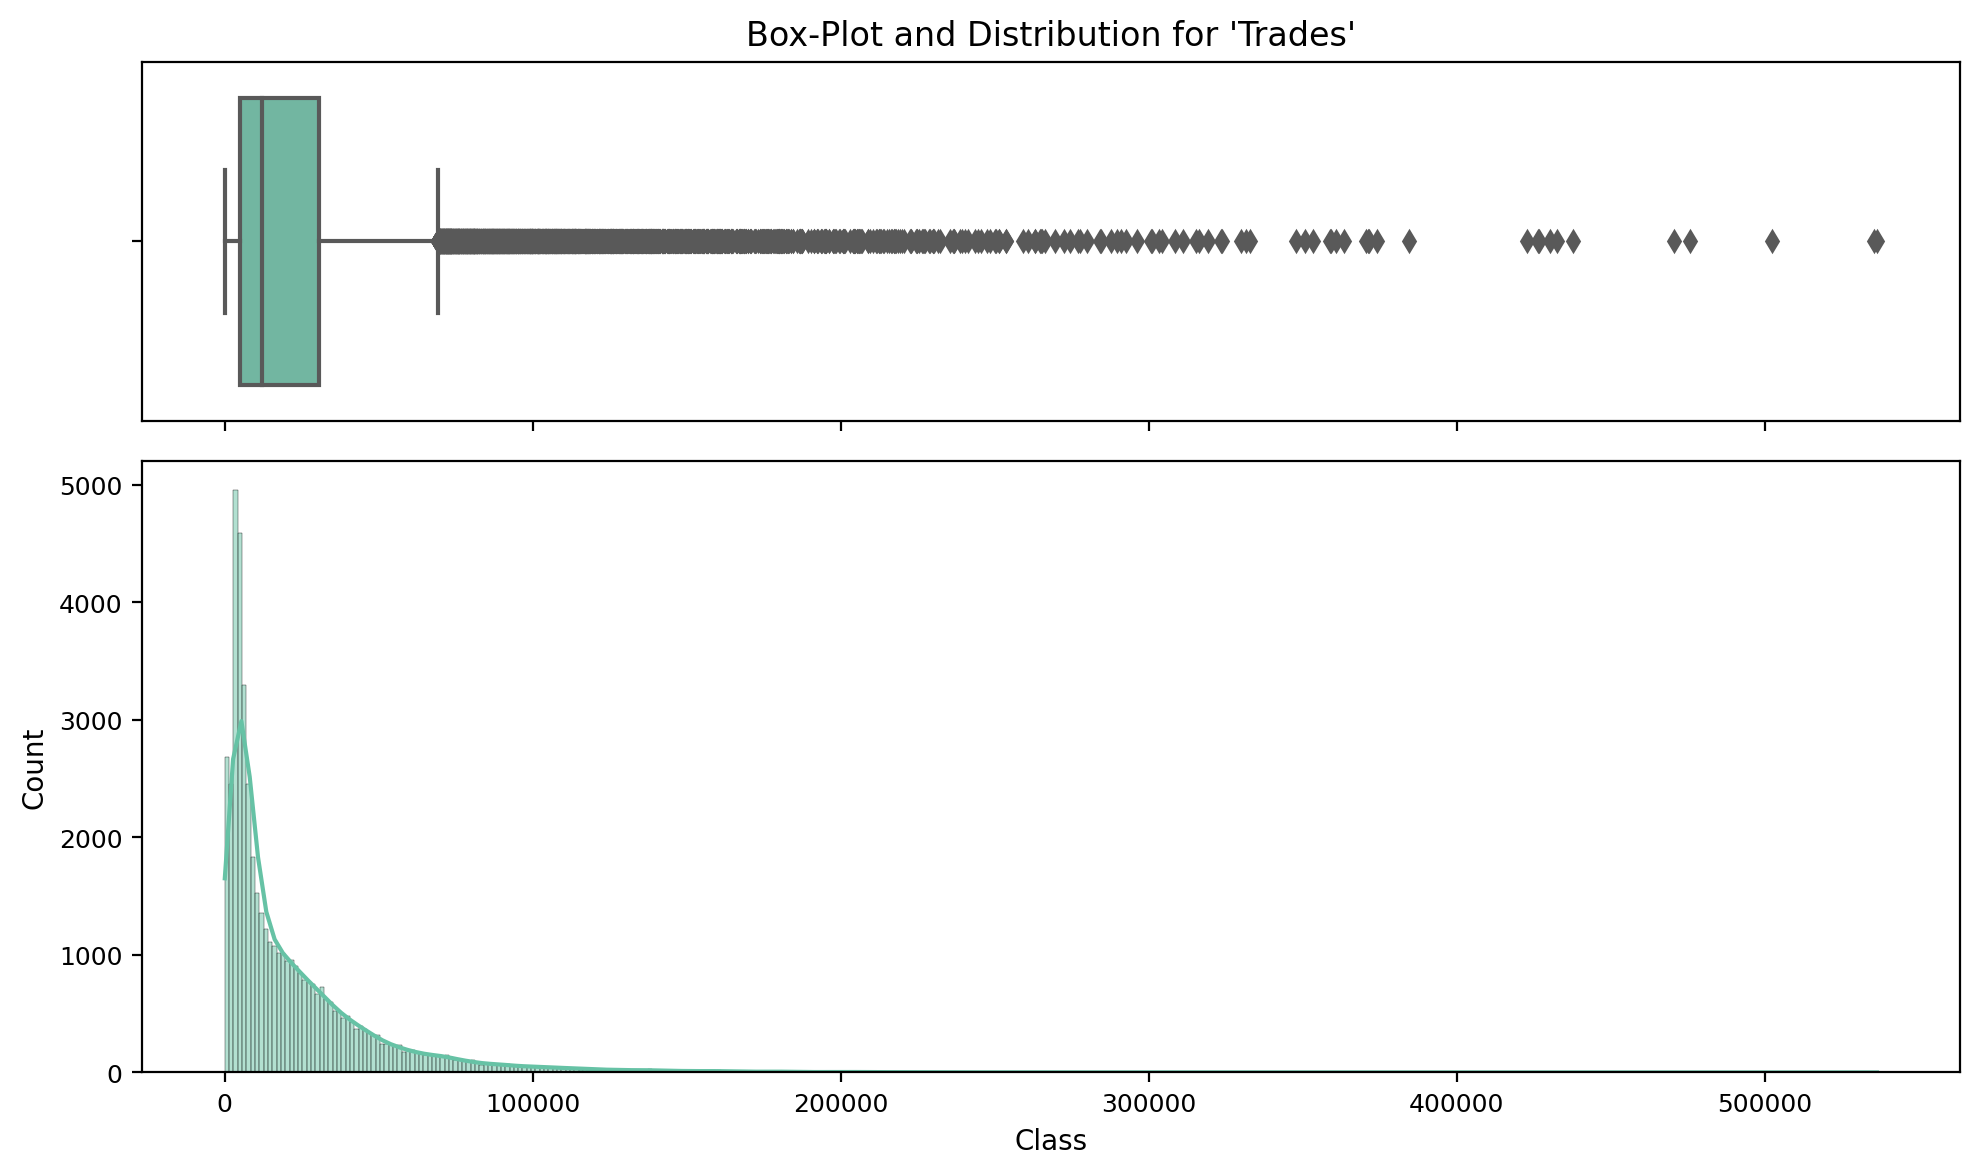

In [23]:
for col in df.columns:
    hd.box_and_hist_plots(df, col)

Визуально видно, что признаки далеки от нормального распределения:
- Много выбросов за пределами усов справа, следовательно имеем правостороннюю ассимитрию
- Гистограммы лог-нормальные

Провожу статистические тесты на нормальность

In [24]:
for col in df.columns:
    print("Column Name : ", col)
    hd.pirson_normal_test(df[col].values)
    print()

Column Name :  Open
Test on normal distribution: 7848.593767343349
P-Value: 0.0
NOT a normal distribution!

Column Name :  High
Test on normal distribution: 7820.927743763346
P-Value: 0.0
NOT a normal distribution!

Column Name :  Low
Test on normal distribution: 7877.044091858985
P-Value: 0.0
NOT a normal distribution!

Column Name :  Close
Test on normal distribution: 7847.491840532787
P-Value: 0.0
NOT a normal distribution!

Column Name :  Volume
Test on normal distribution: 42978.97280884985
P-Value: 0.0
NOT a normal distribution!

Column Name :  Trades
Test on normal distribution: 40701.47212068965
P-Value: 0.0
NOT a normal distribution!



Статистические тесты так же говорят о том, что признаки не распределены нормально.

### Логарифмирую все признаки

In [17]:
def create_log_features(df, cols_to_log=["Open", "High", "Low", "Close", "Volume", "Trades"]):
    """
    Log-transform specified columns of the DataFrame in place.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame. Note: This DataFrame will be modified in place.
    cols_to_log : list of str, default ["Open", "High", "Low", "Close", "Volume", "Trades"]
        The columns of the DataFrame to be log-transformed.
    
    Raises:
    -------
    ValueError
        - If any specified column doesn't exist in the DataFrame.
        - If any specified column contains non-positive values.
    """
    
    # Check existence and value constraints of columns
    for col in cols_to_log:
        if col not in df.columns:
            raise ValueError(f"DataFrame doesn't contain the column '{col}'")

        if (df[col] <= 0).any():
            raise ValueError(
                f"Column '{col}' contains non-positive values, which can't be log-transformed."
            )

        # Compute the logarithm and store in a new column
        df[col + "_log"] = np.log(df[col])

    return df

In [18]:
df = create_log_features(df)

Изучаю логарифмированные признаки

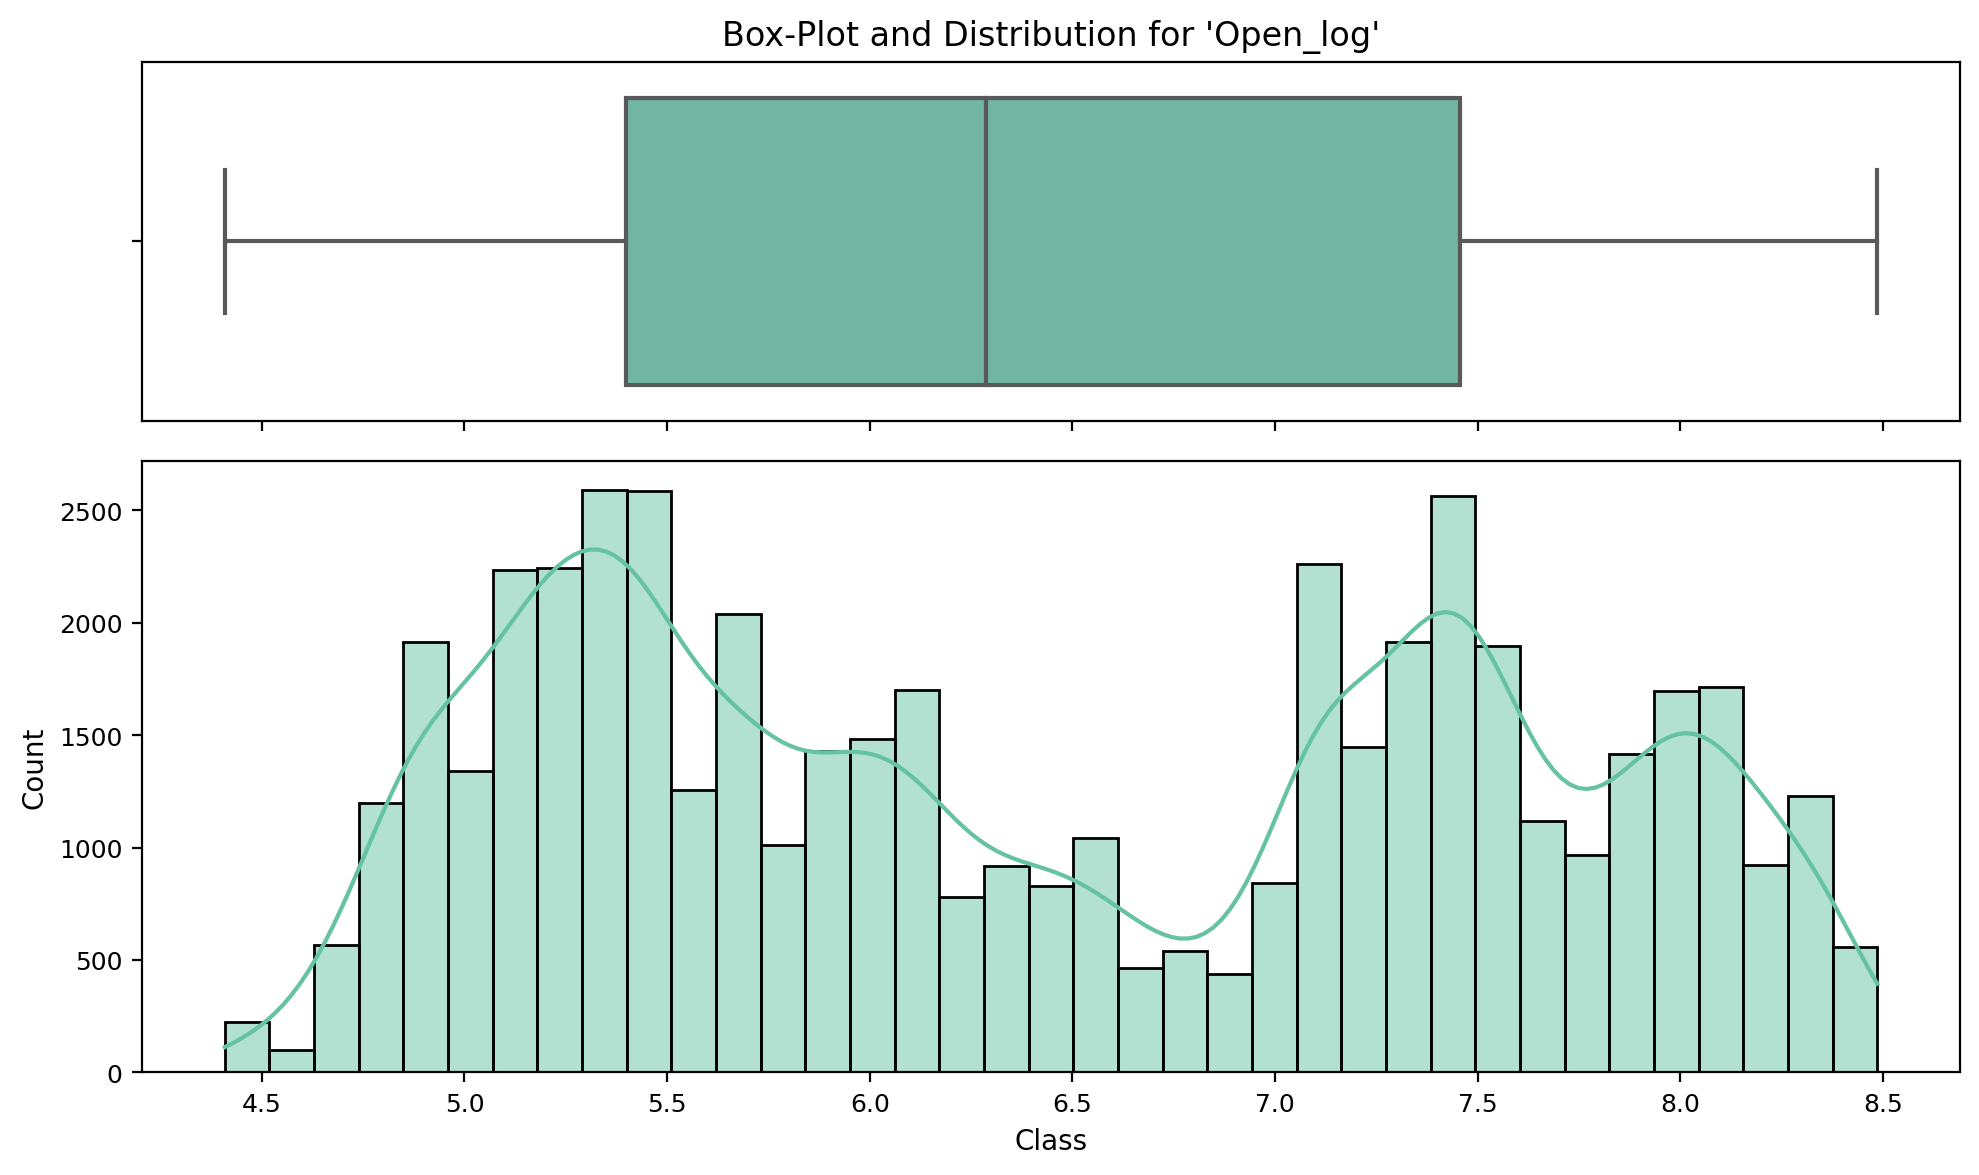

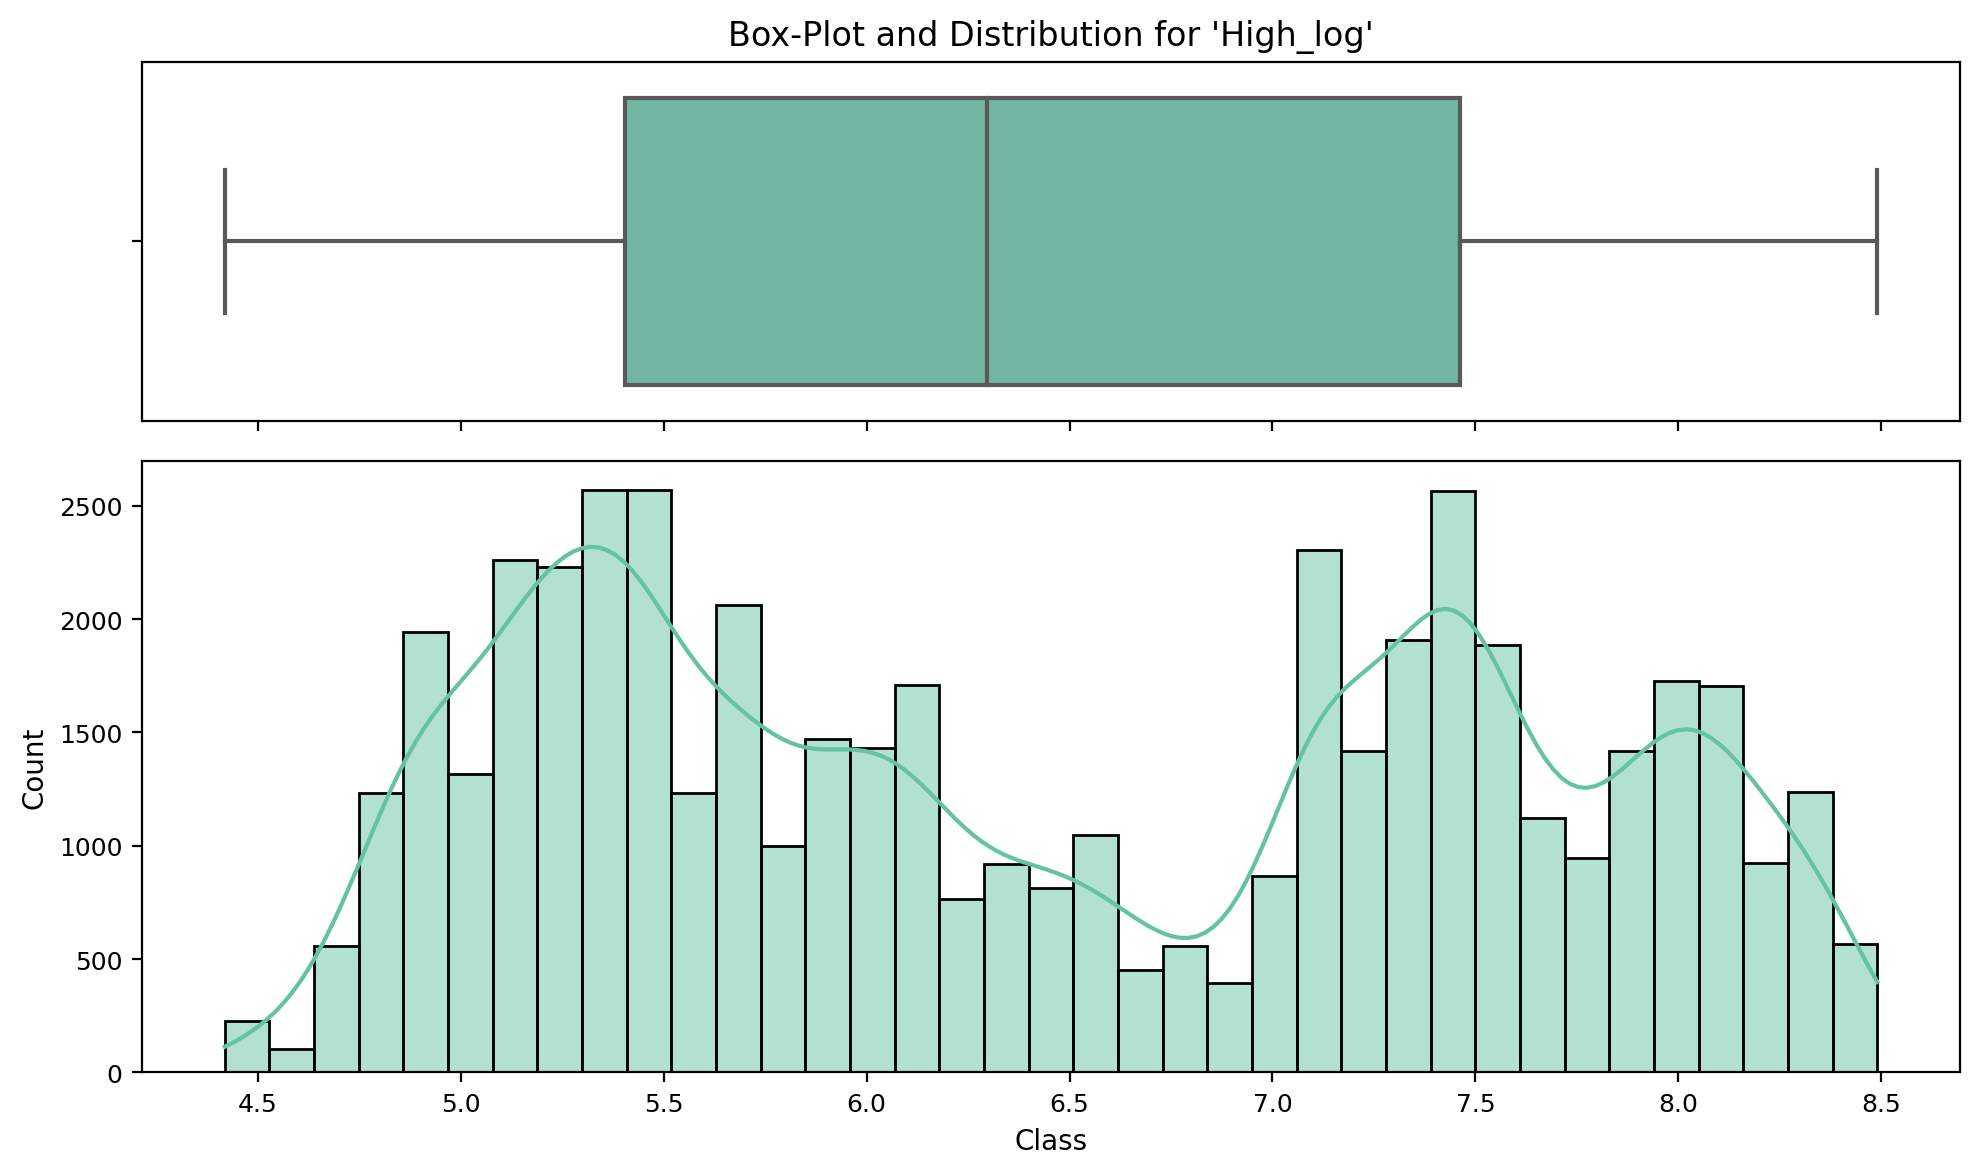

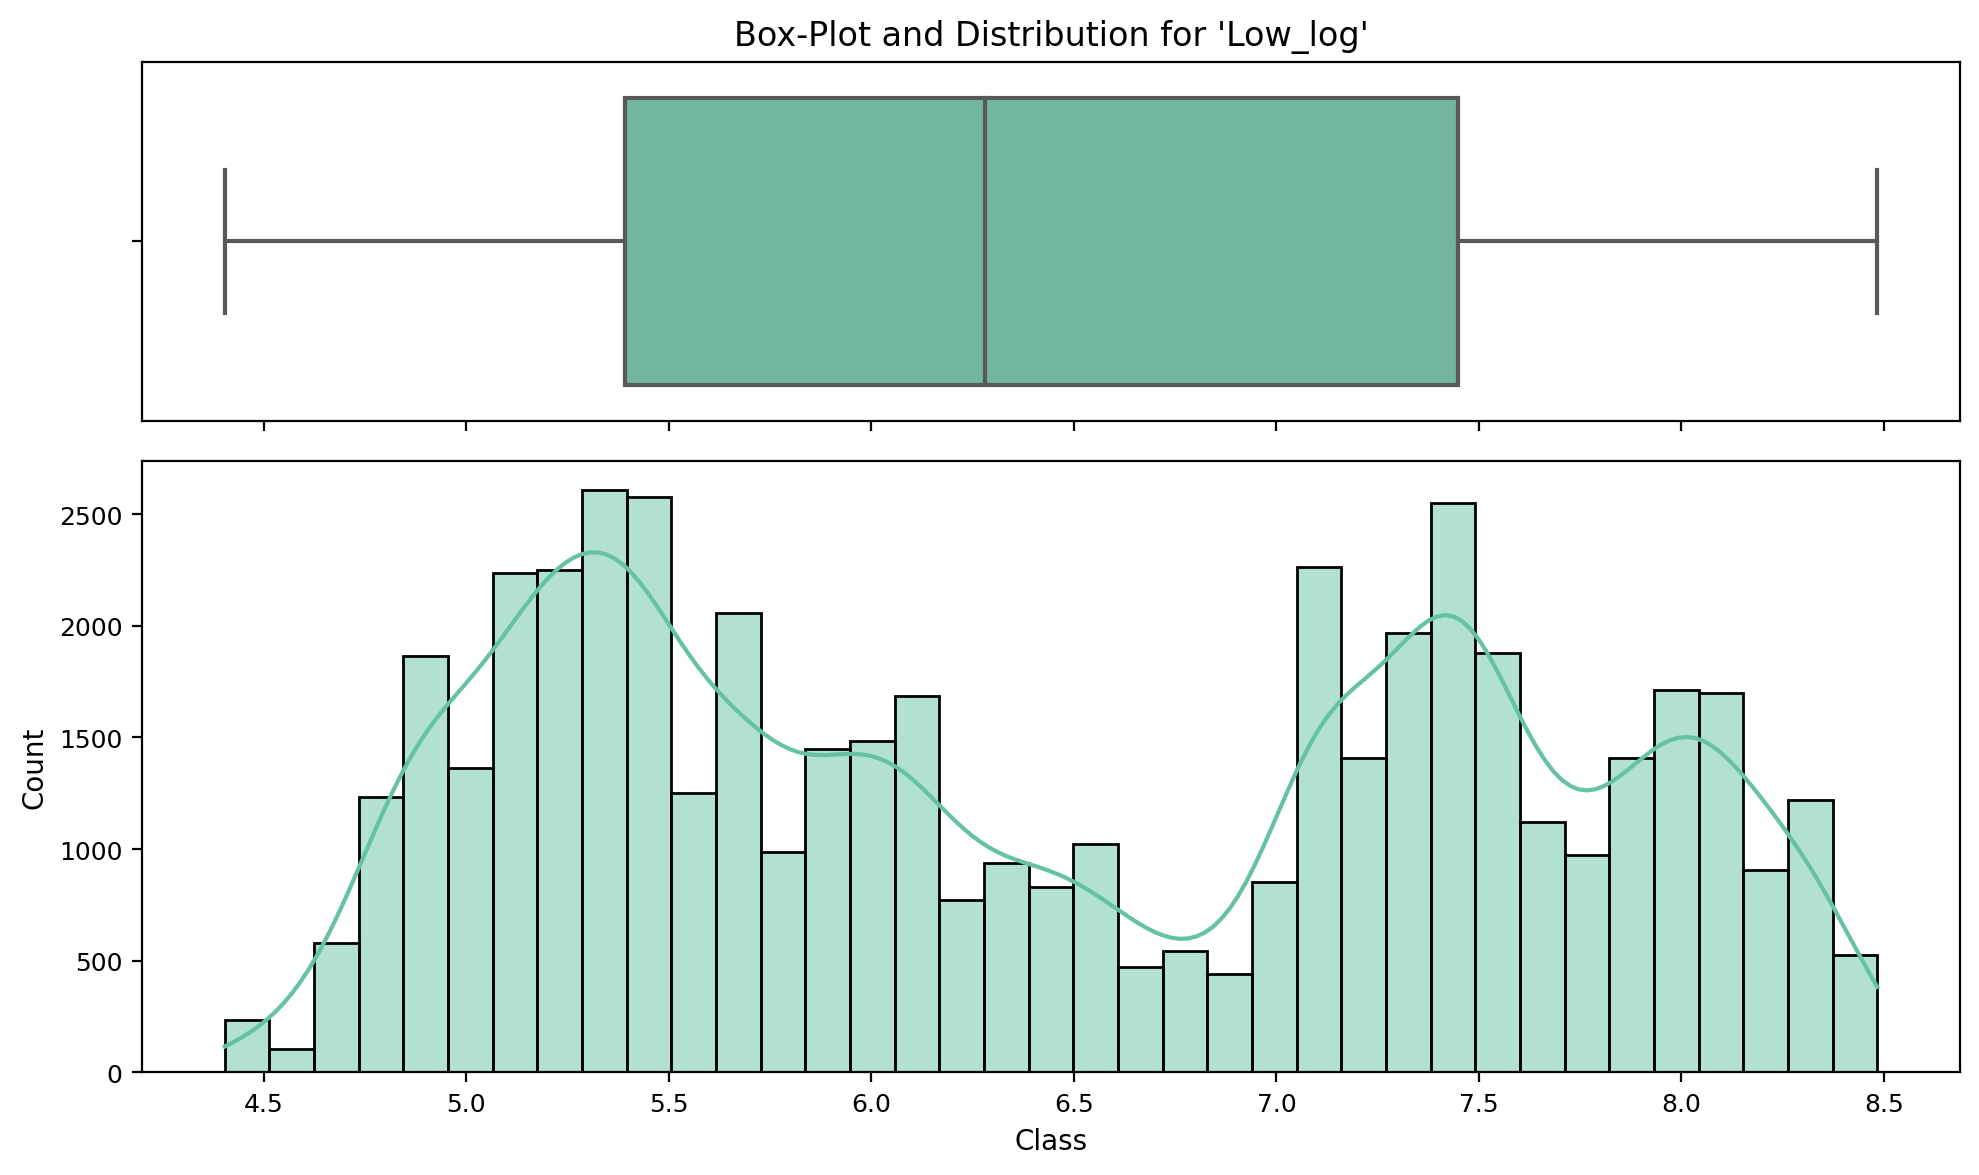

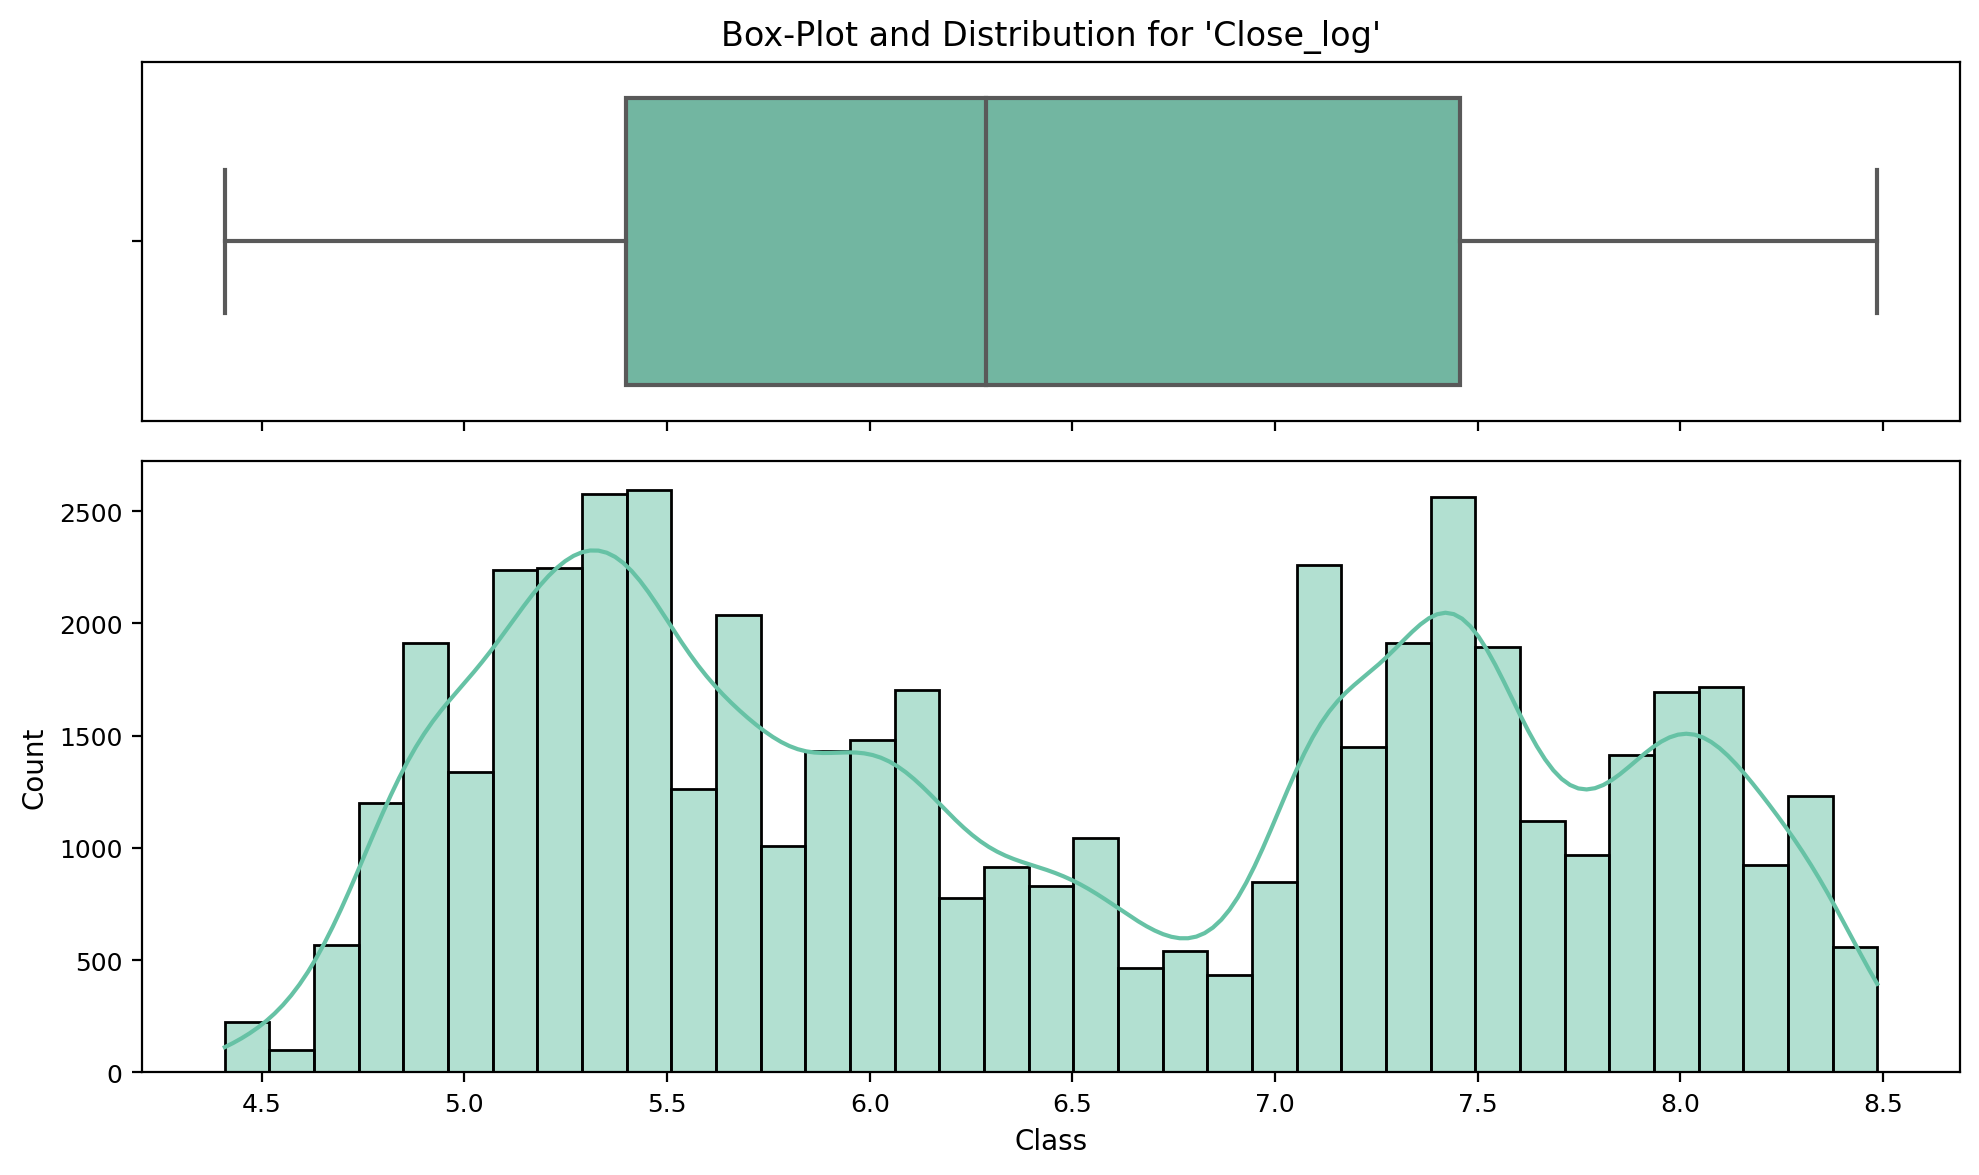

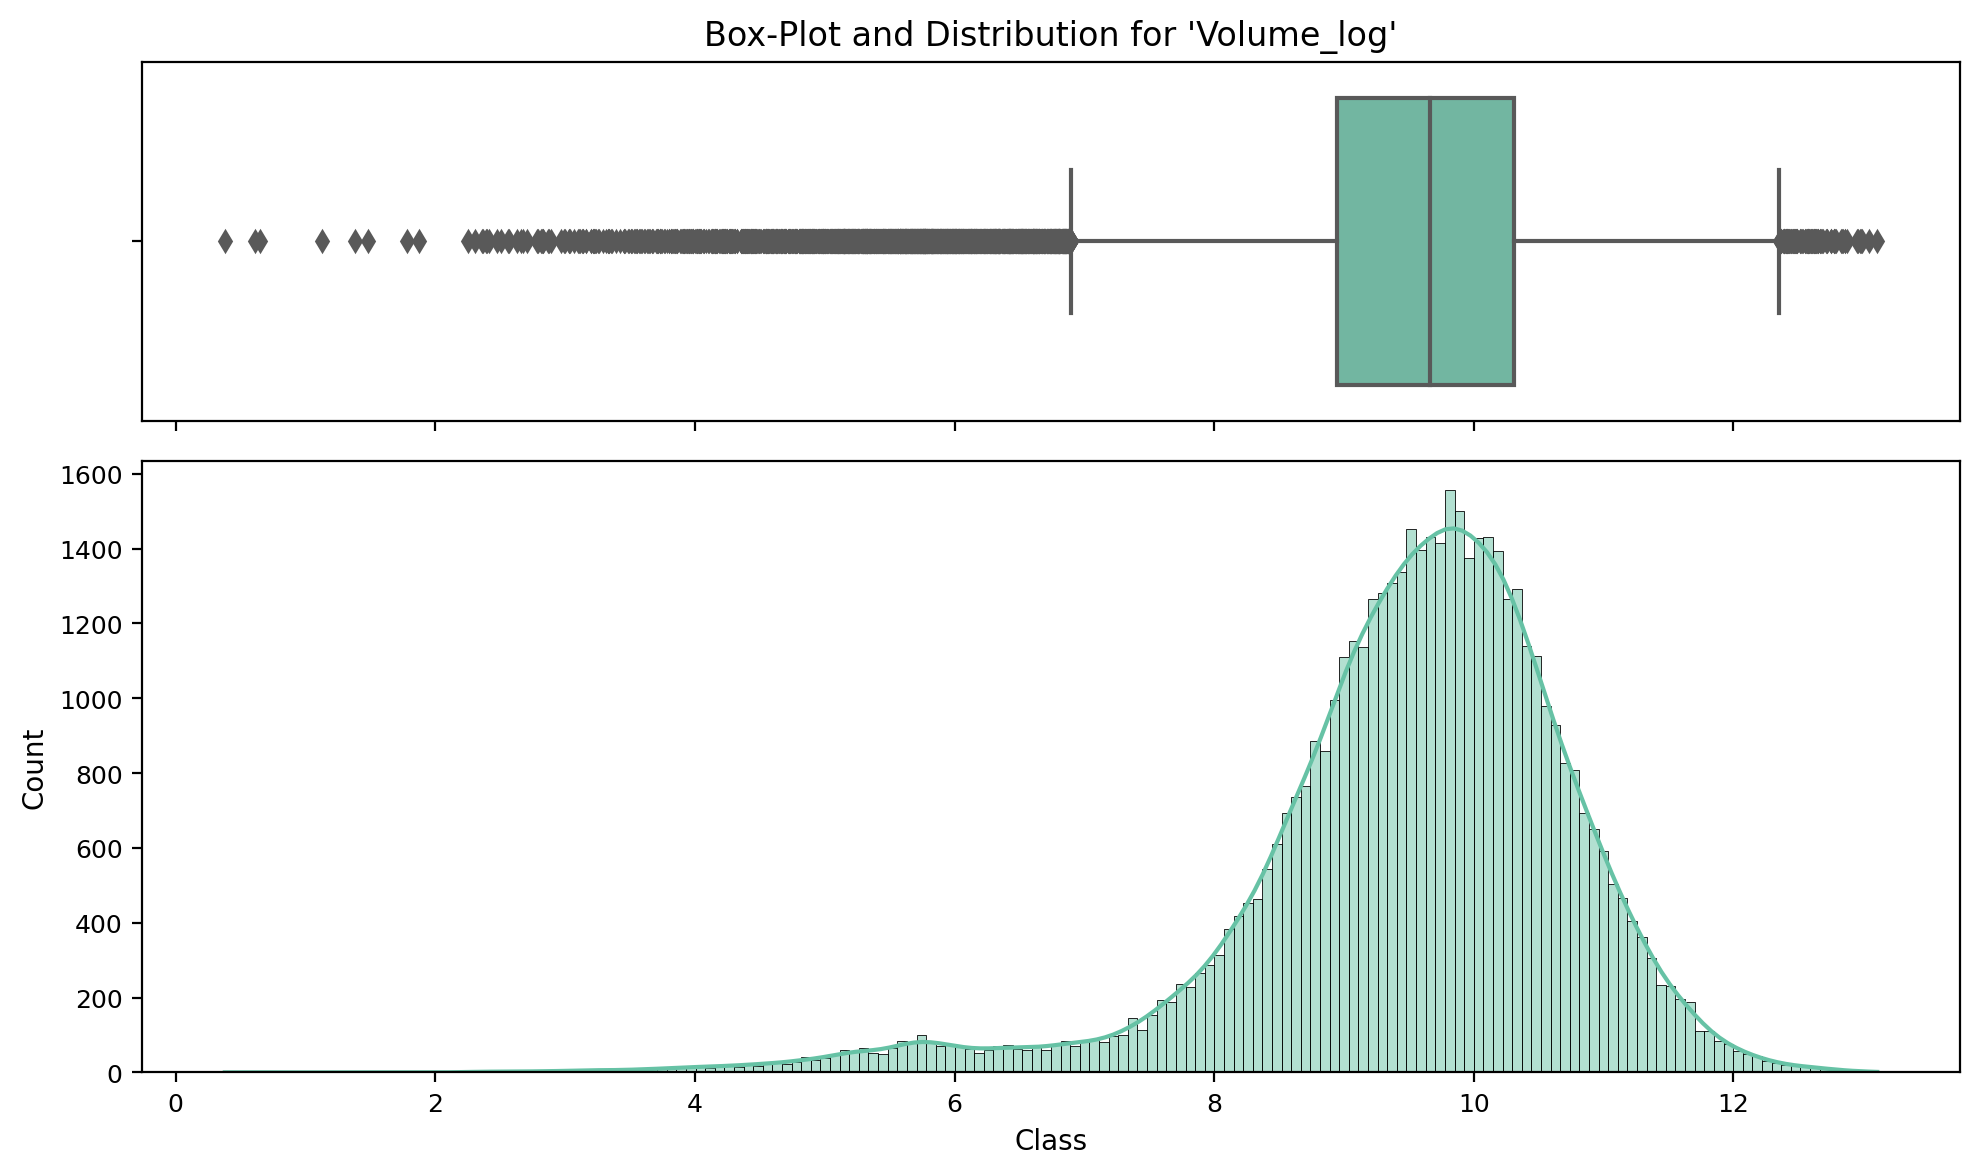

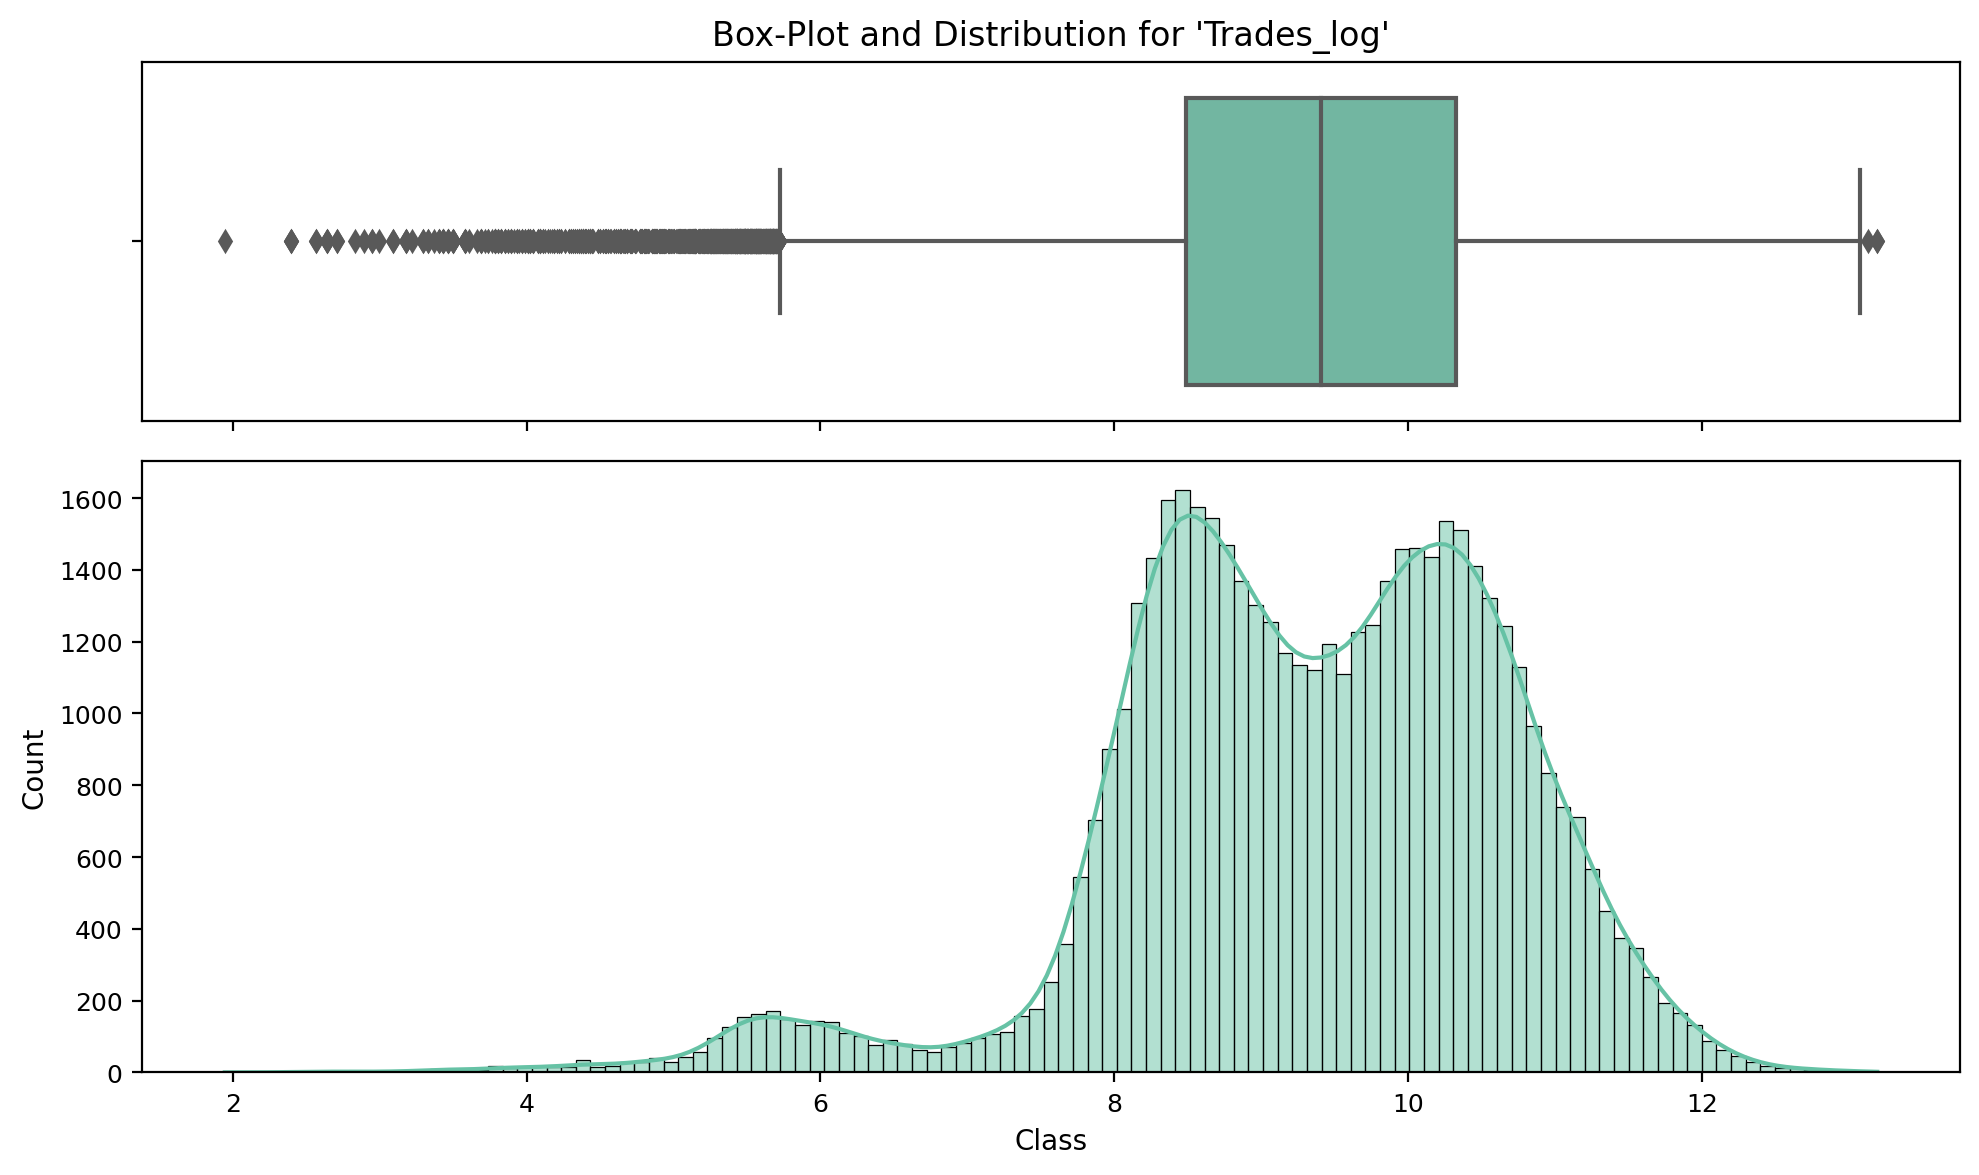

In [27]:
log_cols = ['Open_log', 'High_log', 'Low_log', 'Close_log', 'Volume_log','Trades_log']
for col in log_cols:
    hd.box_and_hist_plots(df, col)

У большинства признаков теперь ярко выраженное бимодальное распределение.

In [28]:
for col in log_cols:
    print("Column Name : ", col)
    hd.adf(df[col].values)
    print()

Column Name :  Open_log
Test-Statistic: -0.8644232035733913
P-Value: 0.799462548445314
Time series is non-stationary

Column Name :  High_log
Test-Statistic: -0.8486019185743207
P-Value: 0.8044272827659791
Time series is non-stationary

Column Name :  Low_log
Test-Statistic: -0.8955824385889669
P-Value: 0.7894237027058137
Time series is non-stationary

Column Name :  Close_log
Test-Statistic: -0.8622502949973395
P-Value: 0.8001496944331916
Time series is non-stationary

Column Name :  Volume_log
Test-Statistic: -6.651999727439755
P-Value: 5.093274280205379e-09
Time series is stationary!

Column Name :  Trades_log
Test-Statistic: -5.1317008908253
P-Value: 1.2100870992496234e-05
Time series is stationary!



Ценовые признаки не стали стационарными, необходимы дальнейшие преобразования.

А вот объемные признаки теперь стационарны, для них хватило логарифмирования.

In [29]:
for col in log_cols:
    print("Column Name : ", col)
    hd.pirson_normal_test(df[col].values)
    print()

Column Name :  Open_log
Test on normal distribution: 523268.22974311264
P-Value: 0.0
NOT a normal distribution!

Column Name :  High_log
Test on normal distribution: 517290.6746517298
P-Value: 0.0
NOT a normal distribution!

Column Name :  Low_log
Test on normal distribution: 529412.4710452365
P-Value: 0.0
NOT a normal distribution!

Column Name :  Close_log
Test on normal distribution: 522833.5782017592
P-Value: 0.0
NOT a normal distribution!

Column Name :  Volume_log
Test on normal distribution: 12661.794261068713
P-Value: 0.0
NOT a normal distribution!

Column Name :  Trades_log
Test on normal distribution: 5172.10580636862
P-Value: 0.0
NOT a normal distribution!



Все признаки по прежнему не отвечают нормальному распределению.

# Стационарность
- Перехожу от цены к приращению признаков на логарифмической шкале, log return
- По сути это нормированное приращения признака к предыдущему значению

In [19]:
def create_log_return_features(df, price_cols=["Open", "High", "Low", "Close"]):
    """
    Calculates the log returns for specified columns in the DataFrame.
    
    Parameters:
    - df: Input dataframe containing the price data.
    - price_cols: List of columns in df for which log returns need to be calculated. 
                  Default columns are ["Open", "High", "Low", "Close"].

    Returns:
    - DataFrame with added columns for log returns of specified price columns.

    Raises:
    - ValueError: If any of the specified price columns do not exist in the DataFrame.
    """
    
    # Ensure all specified price columns exist in the dataframe
    for col in price_cols:
        if col not in df.columns:
            raise ValueError(f"DataFrame doesn't contain the column '{col}'")

    # Calculate log returns for each specified price column
    for col in price_cols:
        # Log-transform the column
        log_col = np.log(df[col])
        # Compute the difference between successive log values to get log return
        df[col + "_log_return"] = log_col.diff()

    # Handle NaN values resulting from the diff() operation for the first row
    df.fillna(0, inplace=True)

    return df


In [20]:
df = create_log_return_features(df)

# Проверка вновь образованных признаков на стационарность

In [32]:
log_return_cols = ['Open_log_return', 'High_log_return', 'Low_log_return', 'Close_log_return']

In [33]:
for col in log_return_cols:
    print("Column Name : ", col)
    hd.adf(df[col].values)
    print()

Column Name :  Open_log_return
Test-Statistic: -30.68232531725112
P-Value: 0.0
Time series is stationary!

Column Name :  High_log_return
Test-Statistic: -30.542377556005516
P-Value: 0.0
Time series is stationary!

Column Name :  Low_log_return
Test-Statistic: -32.926388946211645
P-Value: 0.0
Time series is stationary!

Column Name :  Close_log_return
Test-Statistic: -30.718957399298525
P-Value: 0.0
Time series is stationary!



Статистические тесты показывают, что полученные после логарифмирования и дифференцирования признаки стационарны

### Визуализирую данные ценовые признаки

In [23]:
def plot_return_chart(
    df, start_from_date=None, limit_rows_to_show=None, format_xlabel=True, linewidth=1
):
    """
    Plot log returns for Open, High, Low, and Close prices.

    Parameters:
    - df (DataFrame): DataFrame containing log returns with datetime index.
    - start_from_date (str or datetime): Date to start the plot from. Default is None.
    - limit_rows_to_show (int): Number of rows to show in the plot. Default is None. Show all rows.
    - format_xlabel (bool): Whether to format the x-axis label. Default is True.
    - linewidth (int): Width of the line. Default is 1.

    Returns:
    - None
    """

    # Filter data starting from 'start_from_date' if specified
    if start_from_date is None:
        data = df
    else:
        data = df[df.index >= start_from_date]

    # Limit the number of rows displayed if 'limit_rows_to_show' is specified
    if limit_rows_to_show is not None:
        data = data.iloc[:limit_rows_to_show]

    # Initialize the plot
    fig, ax = plt.subplots(
        4, 1, figsize=(14, 8), gridspec_kw={"height_ratios": [1, 1, 1, 1]}, sharex=True
    )

    ind = data.index  # Extract index (dates)

    # Plot Open_log_return
    ax[0].vlines(ind, 0, data["Open_log_return"], color="green", linewidth=linewidth)
    ax[0].set_title("Open_log_return")

    # Plot High_log_return
    ax[1].vlines(ind, 0, data["High_log_return"], color="green", linewidth=linewidth)
    ax[1].set_title("High_log_return")

    # Plot Low_log_return
    ax[2].vlines(ind, 0, data["Low_log_return"], color="green", linewidth=linewidth)
    ax[2].set_title("Low_log_return")

    # Plot Close_log_return
    ax[3].vlines(ind, 0, data["Close_log_return"], color="green", linewidth=linewidth)
    ax[3].set_title("Close_log_return")

    # Rotate x-axis labels
    ax[3].tick_params(axis="x", rotation=90)

    # Optionally, format x-axis labels
    if format_xlabel:
        ax[3].xaxis.set_major_locator(mdates.MonthLocator())
        ax[3].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

        date_range = ind.max() - ind.min()
        buffer = date_range * 0.01  # Calculate 1% buffer
        adjusted_start_date = ind.min() - buffer
        adjusted_end_date = ind.max() + buffer

        # Apply adjusted x-axis limits for each subplot
        for axis in ax:
            axis.set_xlim(adjusted_start_date, adjusted_end_date)

    plt.xlabel("Date", fontsize=12)
    plt.tight_layout()
    plt.show()

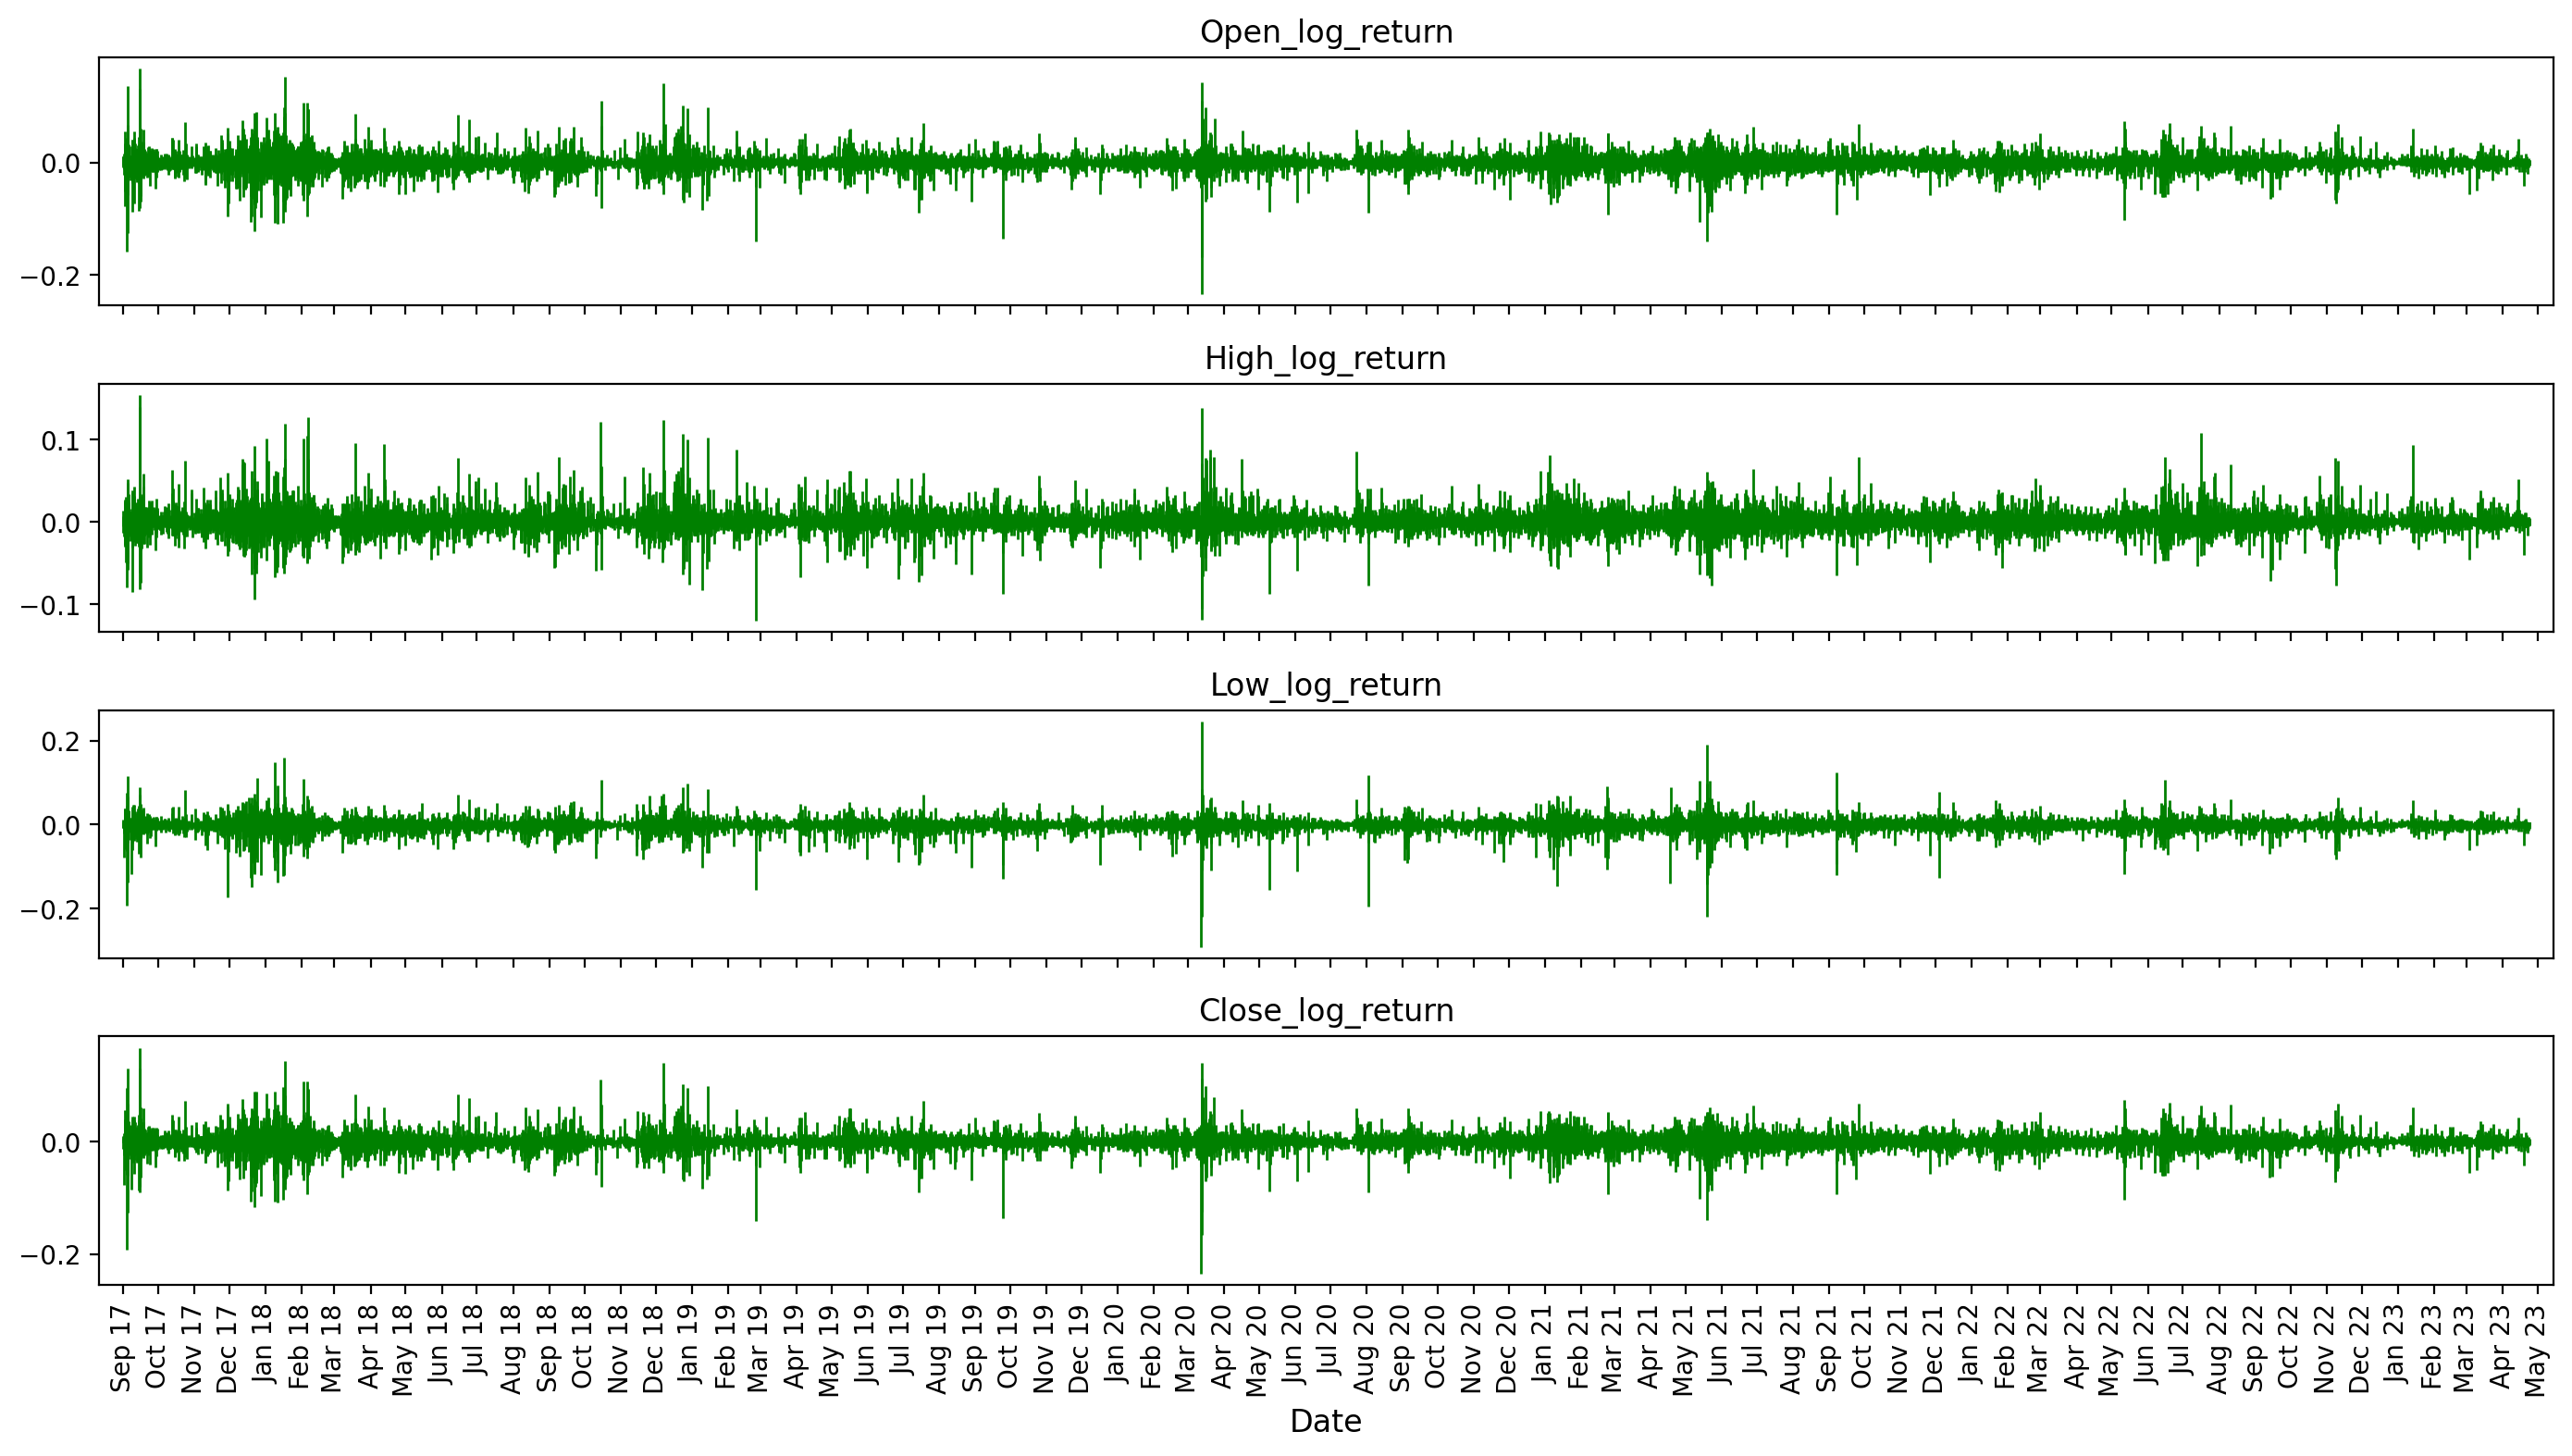

In [24]:
plot_return_chart(df)

Видно, что теперь признаки колеблятся в достаточно узком диапазоне. Тренды отсутствуют.

### Проверка на нормальность

In [39]:
for col in log_return_cols:
    print("Column Name : ", col)
    hd.pirson_normal_test(df[col].values)
    print()

Column Name :  Open_log_return
Test on normal distribution: 14723.541707326774
P-Value: 0.0
NOT a normal distribution!

Column Name :  High_log_return
Test on normal distribution: 16096.406798287793
P-Value: 0.0
NOT a normal distribution!

Column Name :  Low_log_return
Test on normal distribution: 27954.372113967915
P-Value: 0.0
NOT a normal distribution!

Column Name :  Close_log_return
Test on normal distribution: 15171.629385197717
P-Value: 0.0
NOT a normal distribution!



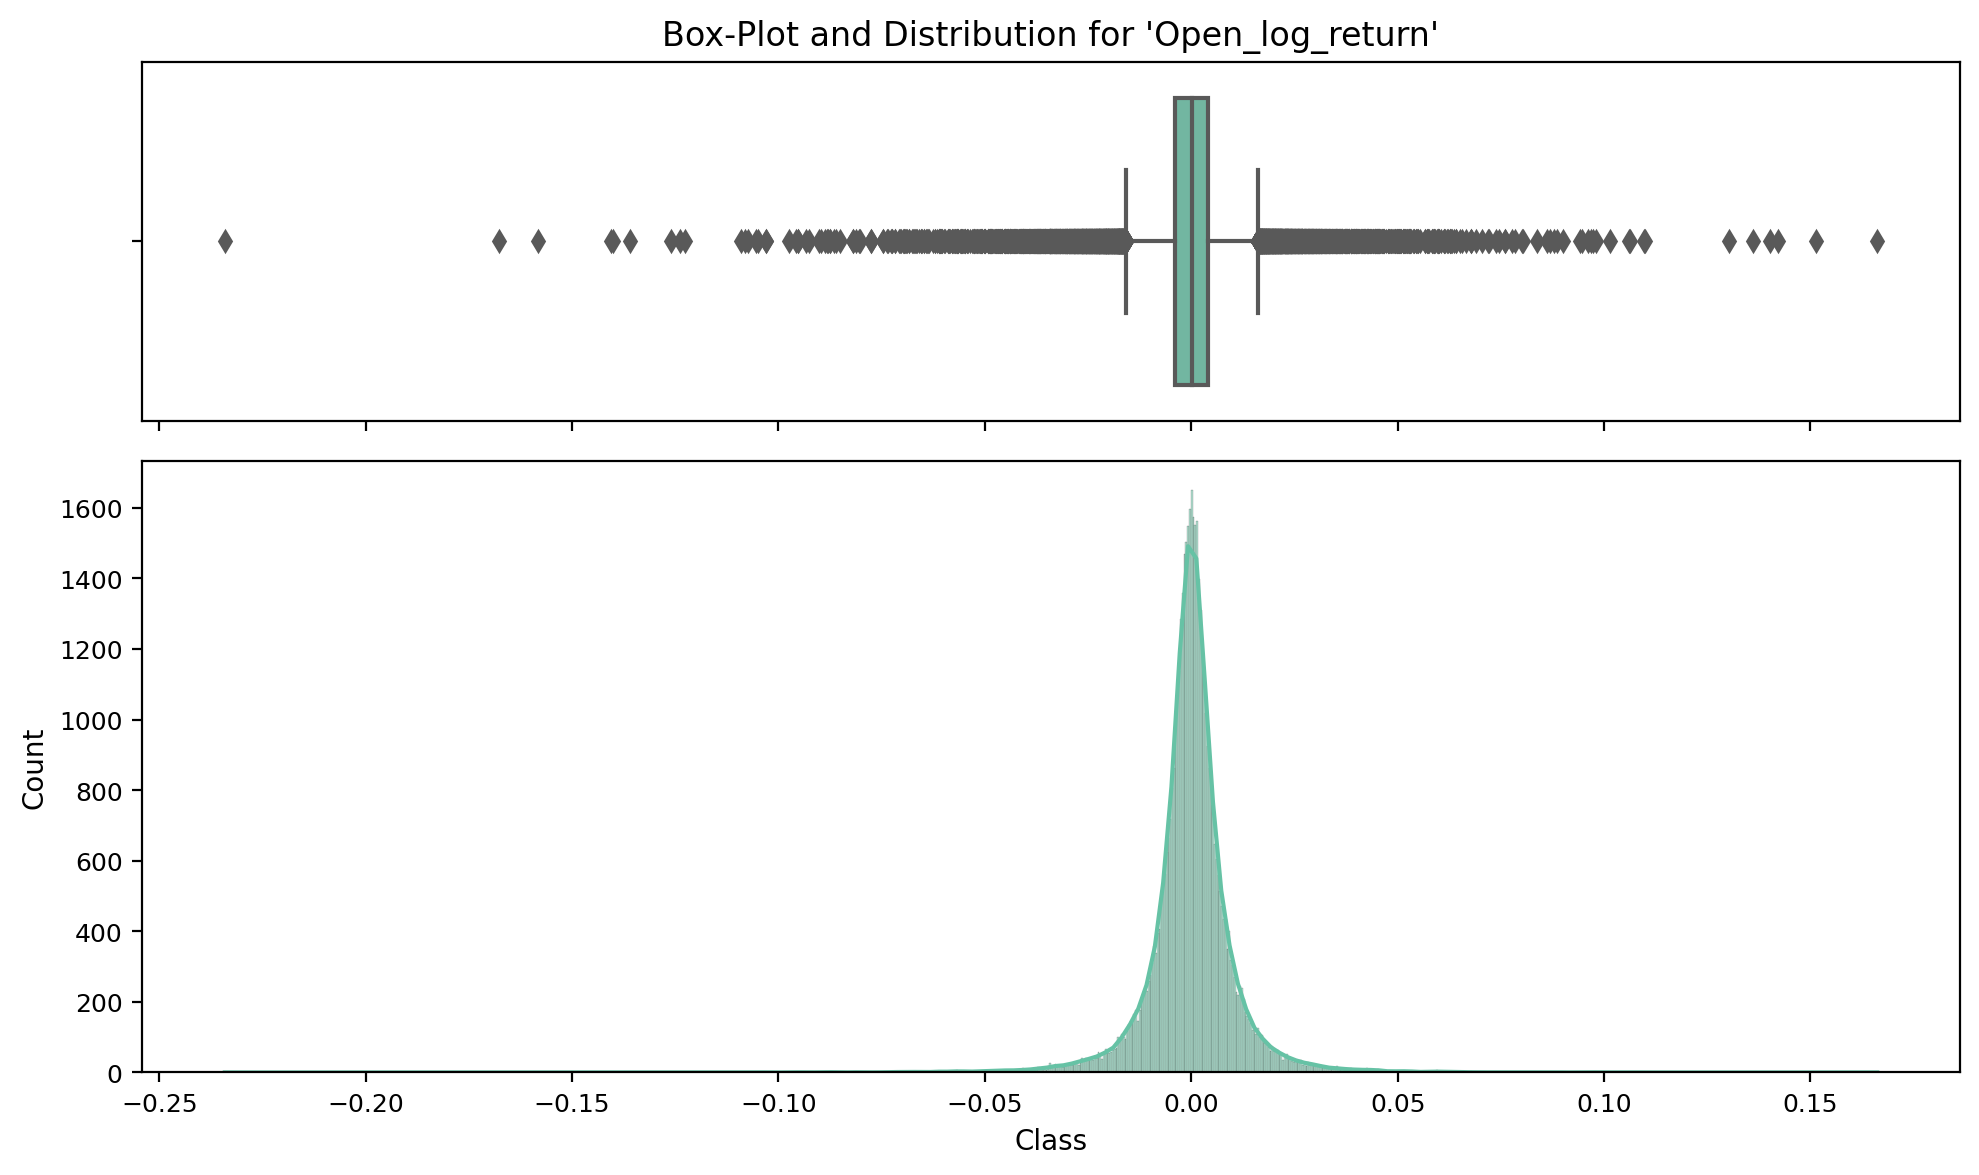

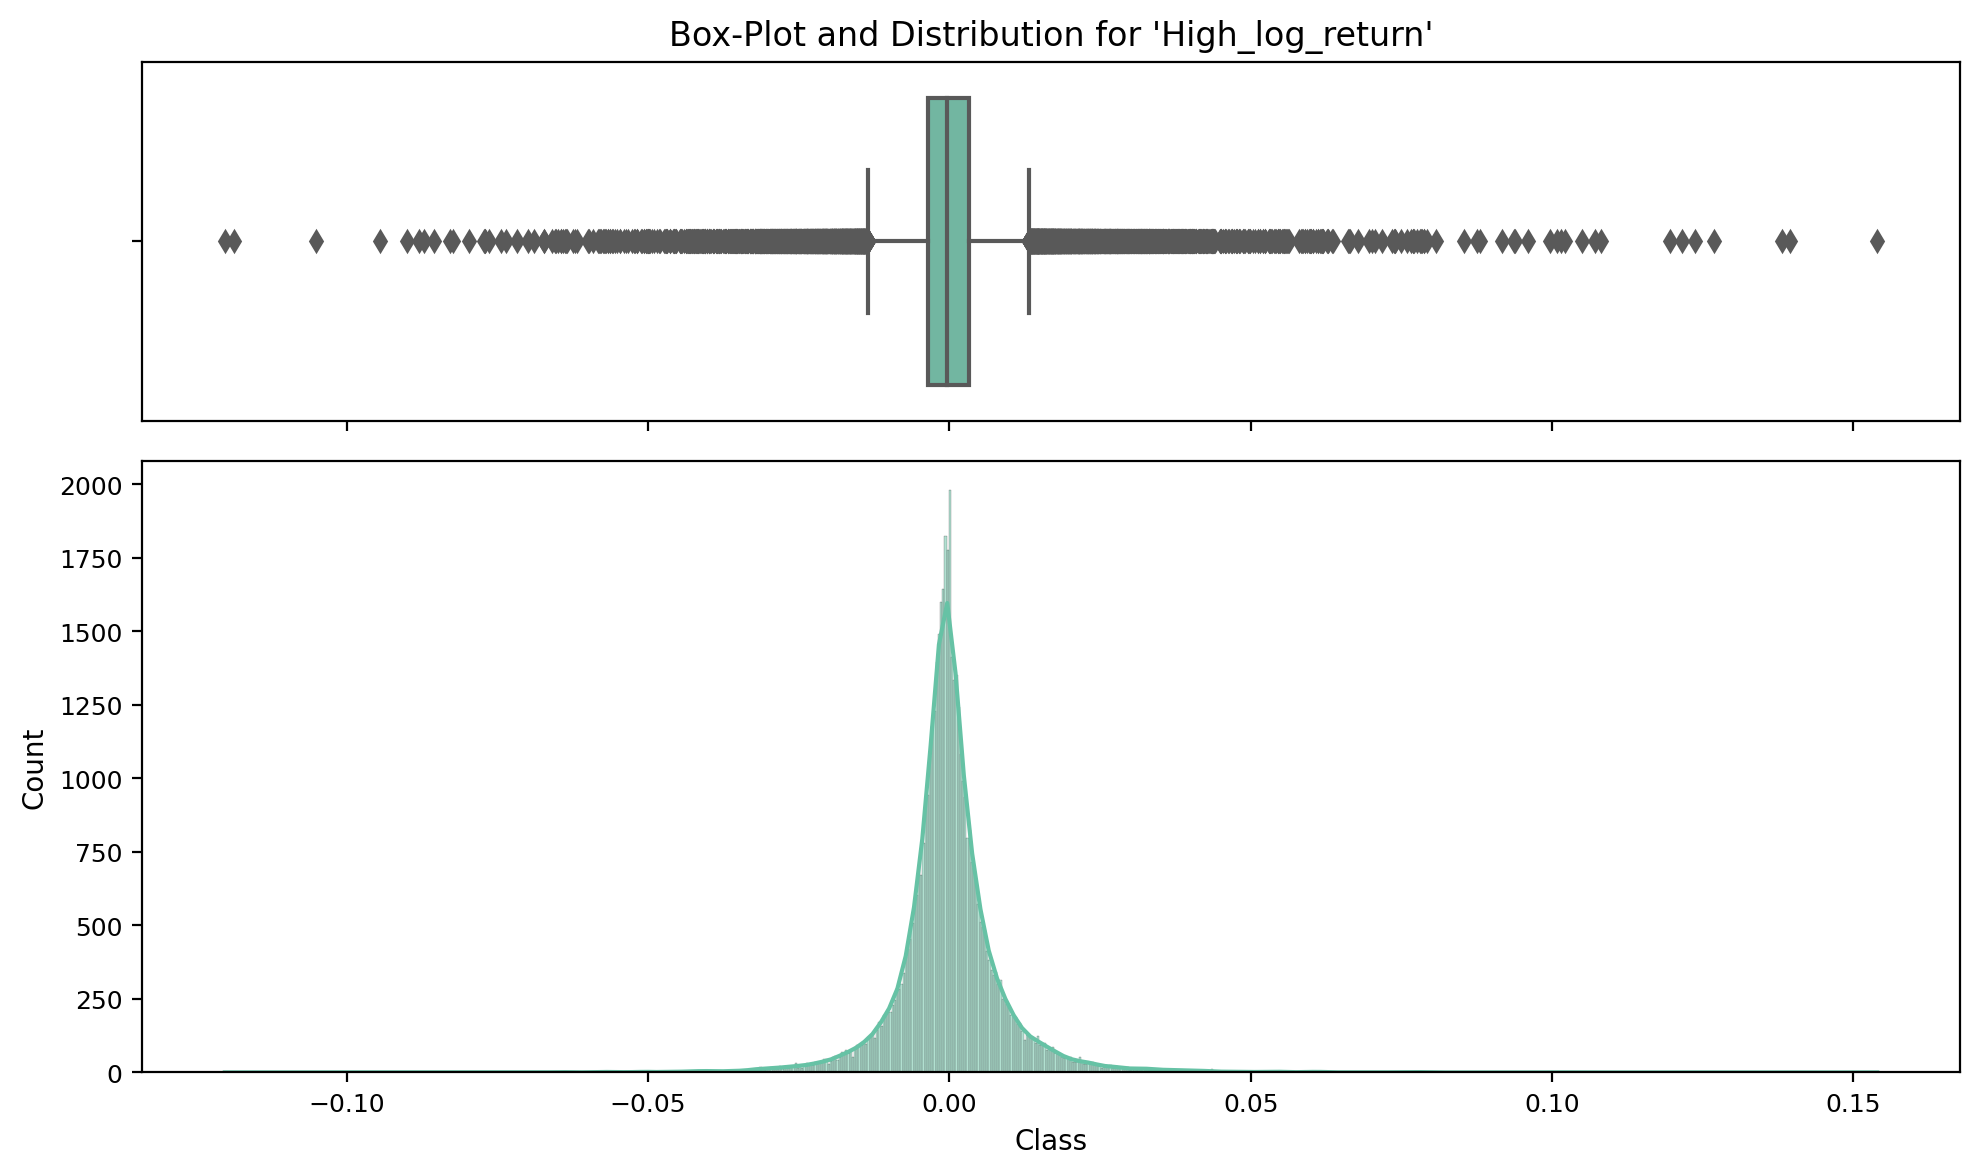

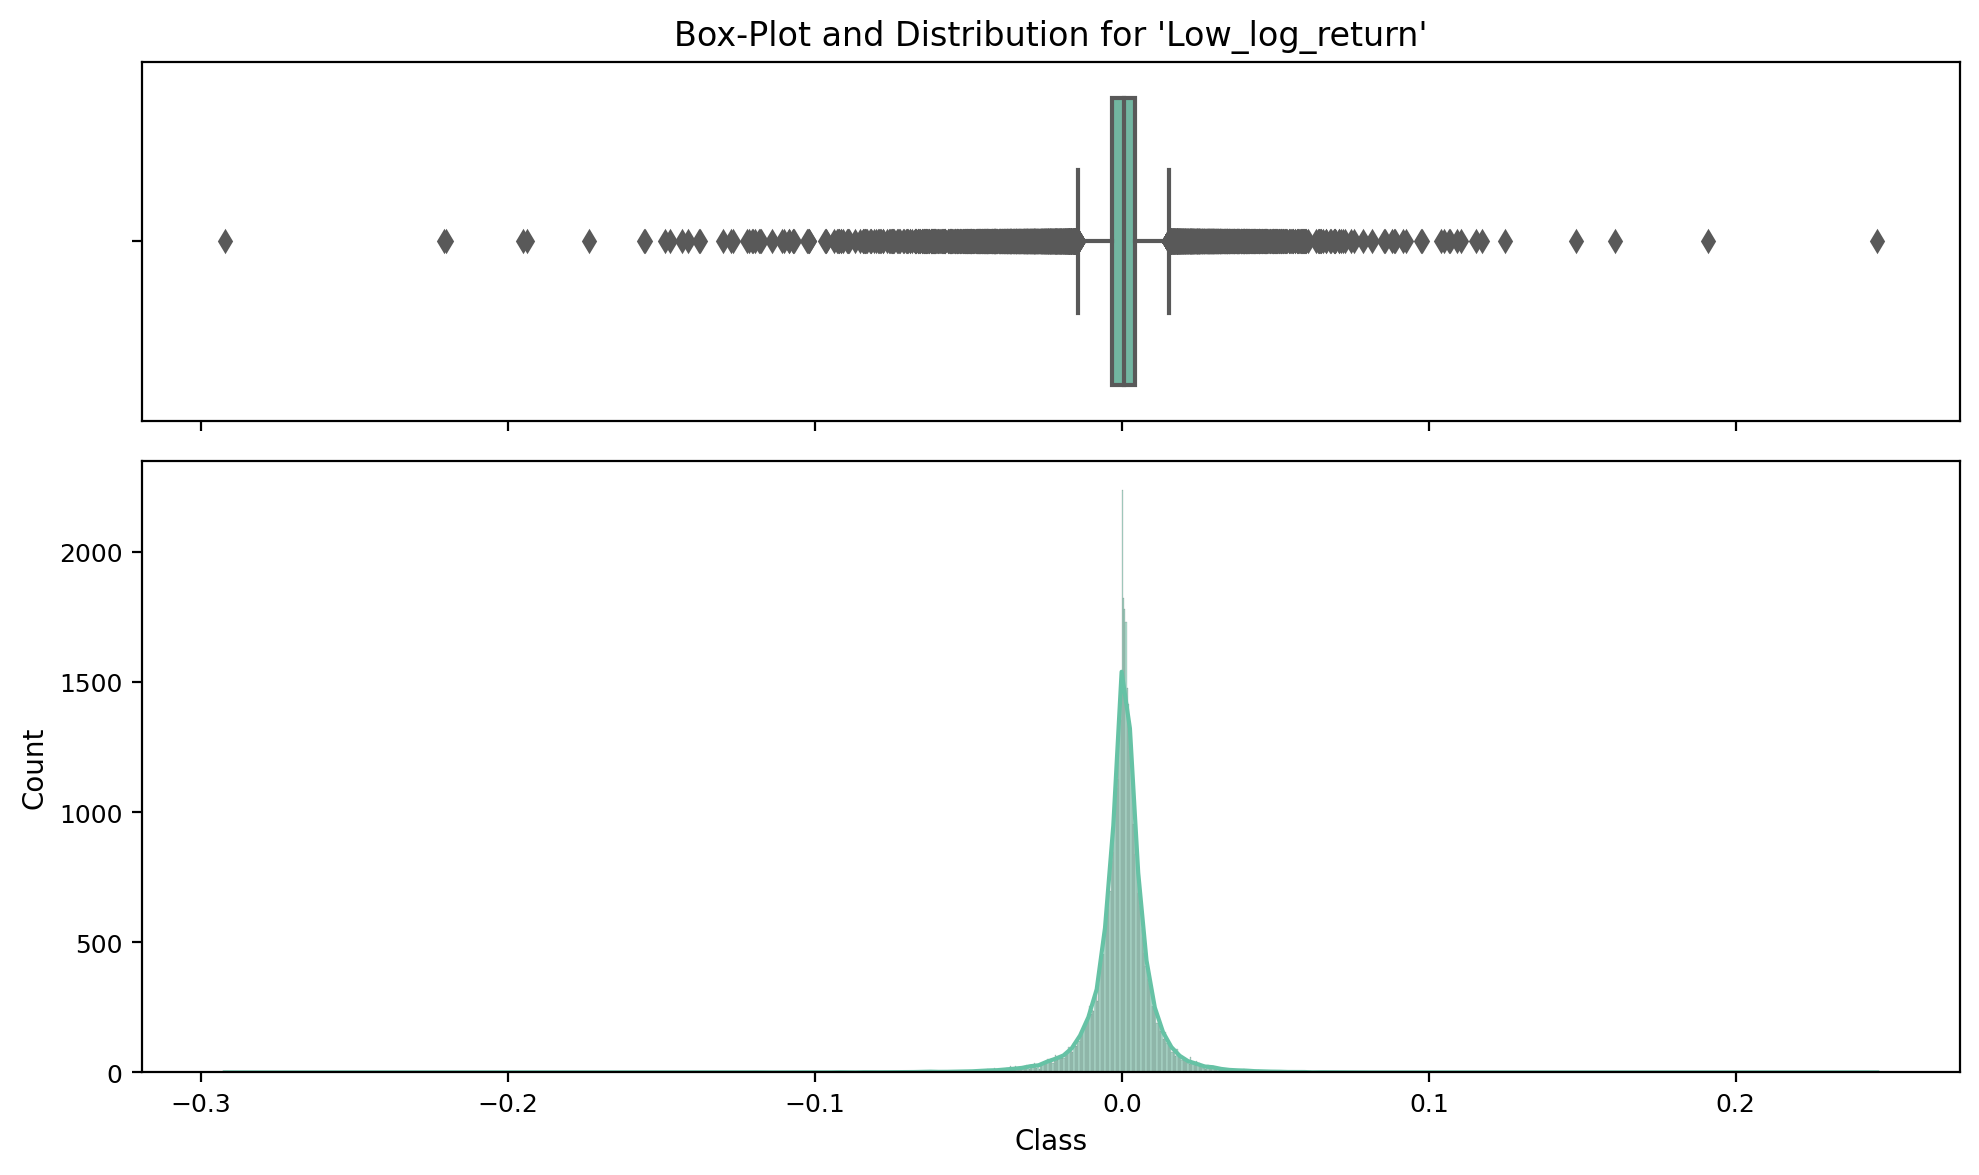

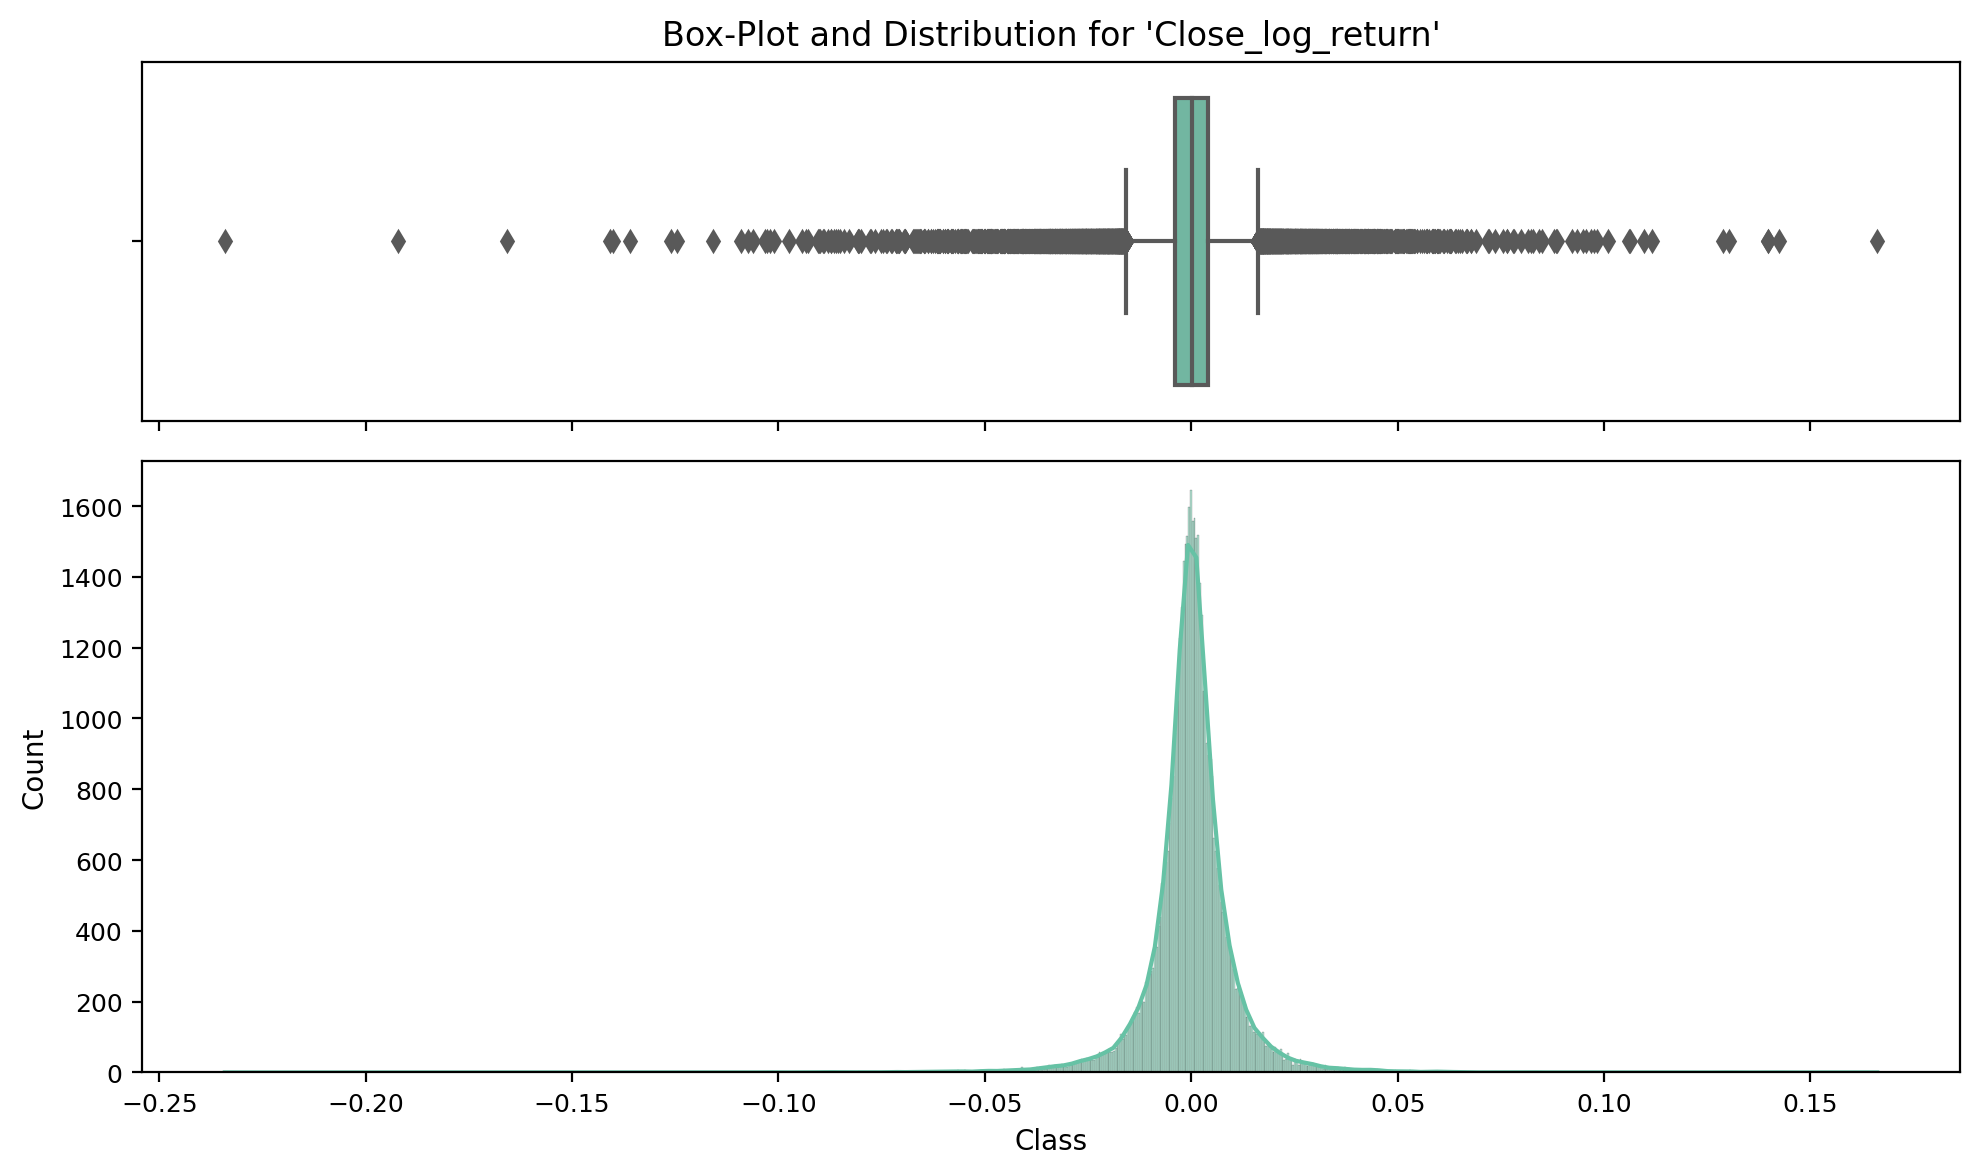

In [40]:
for col in log_return_cols:
    hd.box_and_hist_plots(df, col)

- После преобразований распределения стали колоколообразные и симметричные, но с ОЧЕНЬ длинными хвостами.
- На коробках с усами хорошо видно, что они достаточно симметричны, но выбросы огромные.

# EDA

In [25]:
# Одельные датафреймы для исходных признаков цен, логарифмических и для логарифмических приростов
price_df = df[["Open", "High", "Low", "Close"]]
log_price_df = df[["Open_log", "High_log", "Low_log", "Close_log"]]
log_return_df = df[["Open_log_return", "High_log_return", "Low_log_return", "Close_log_return"]]

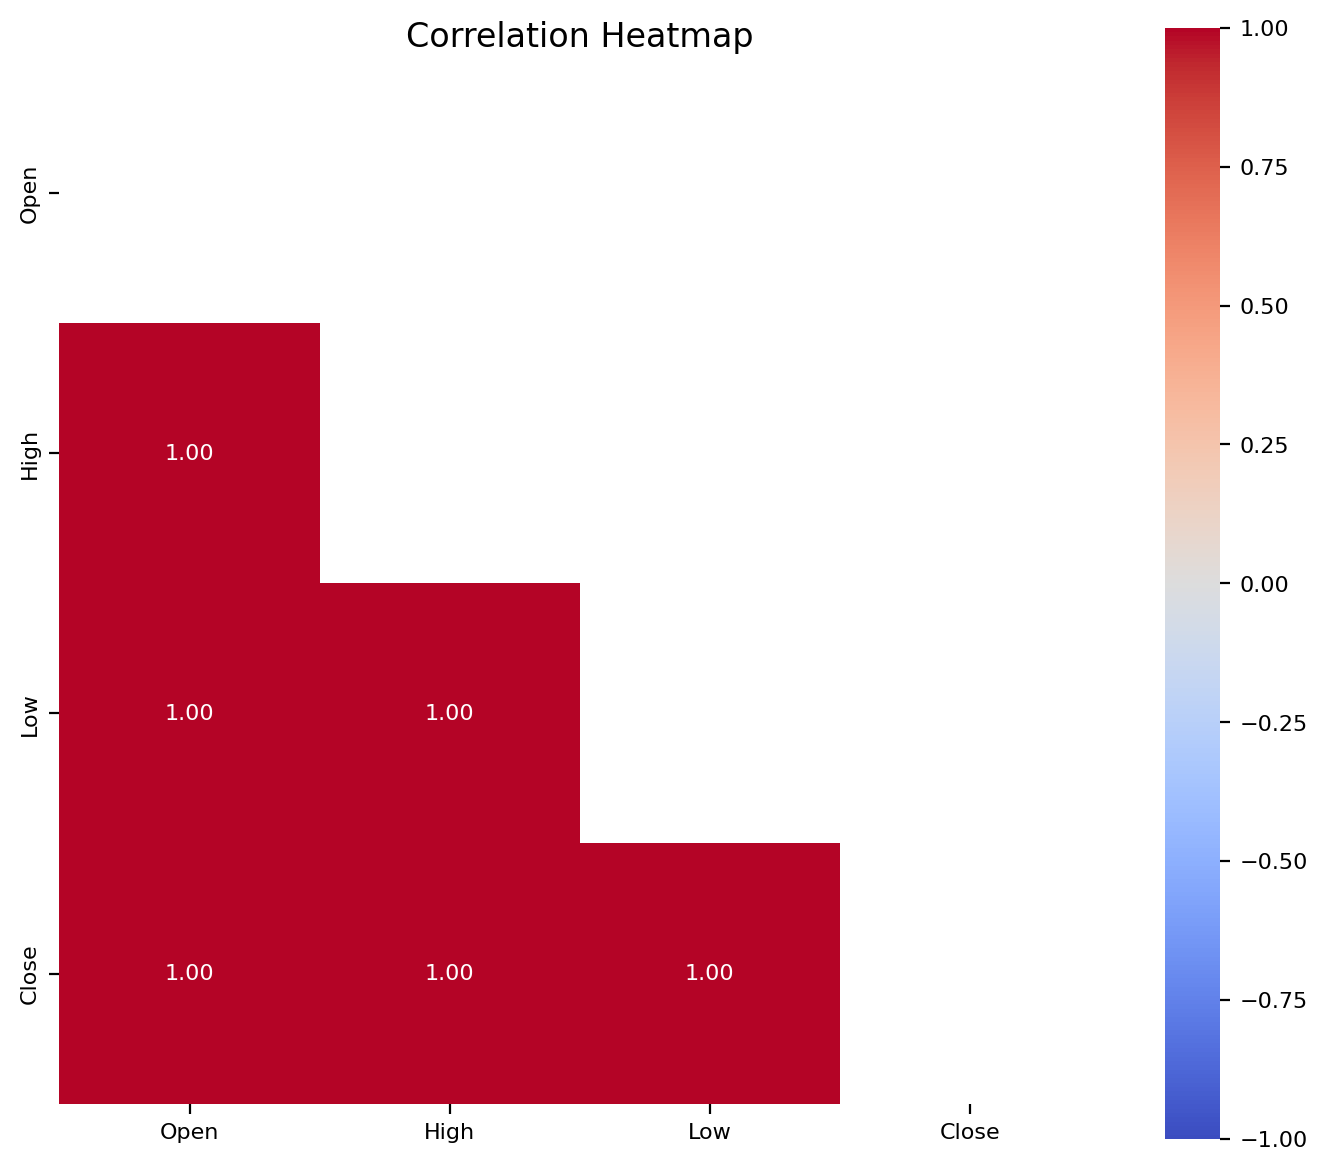

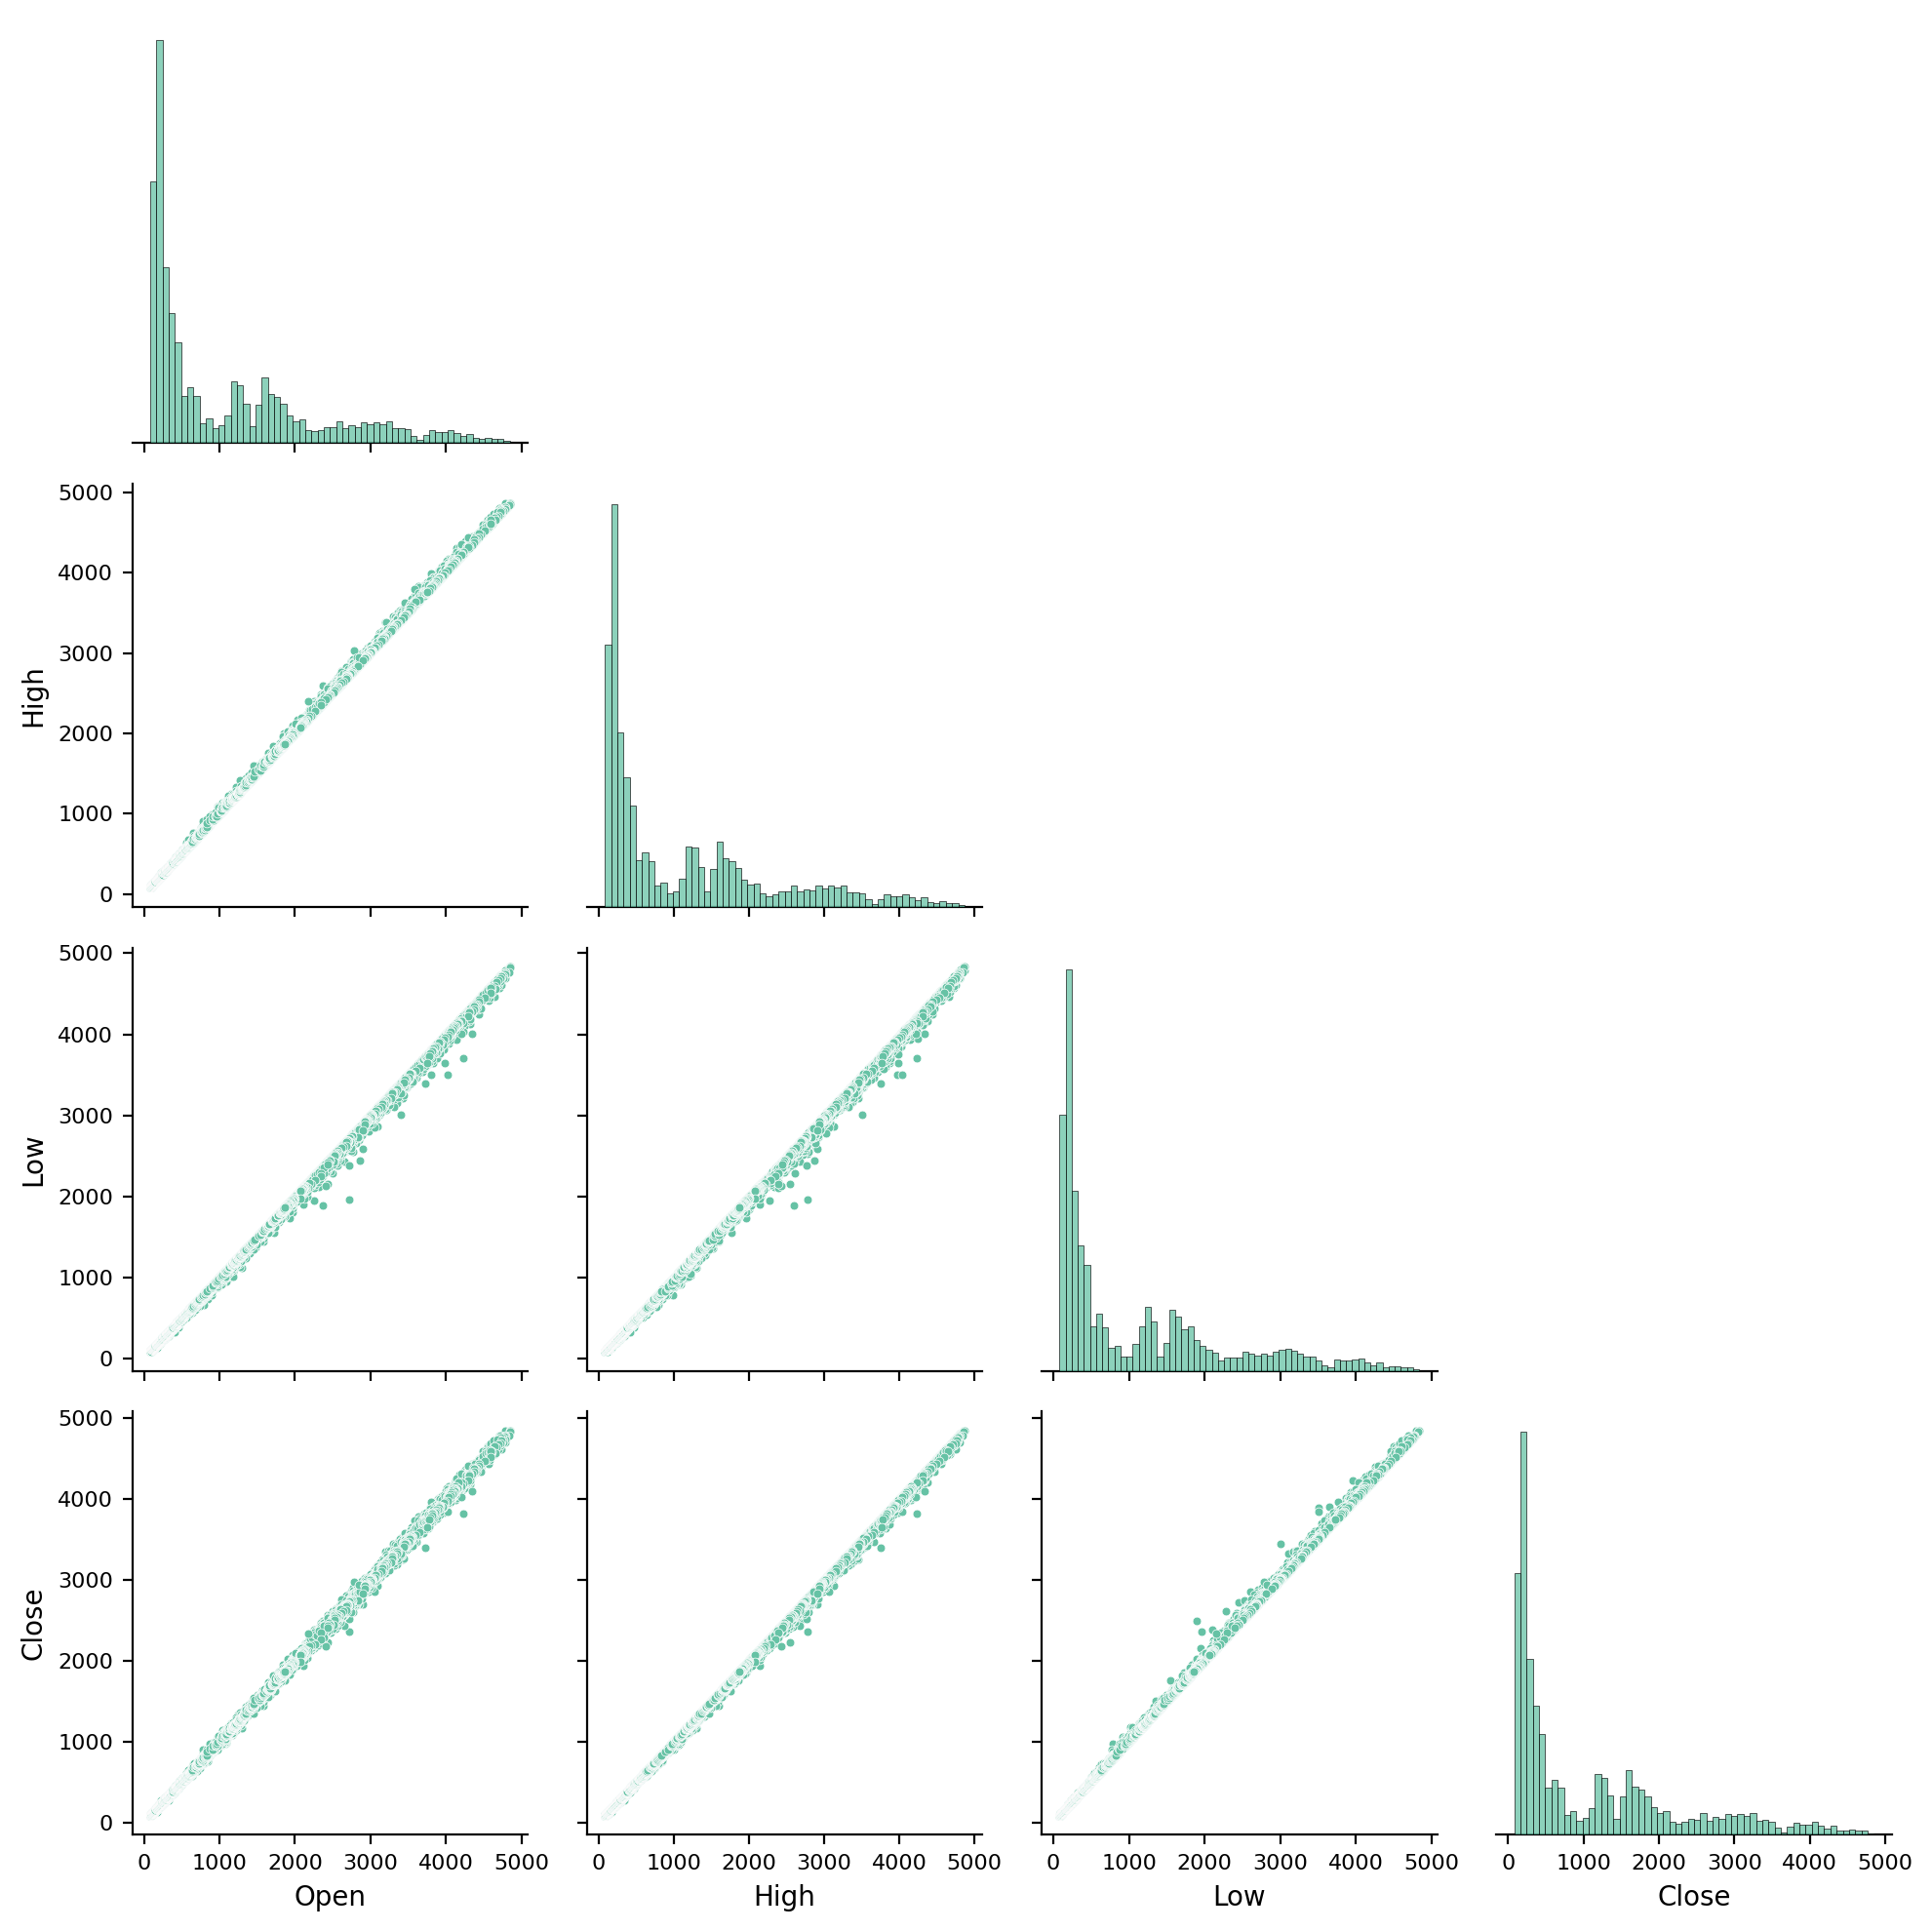

In [103]:
hd.plot_corr_heatmap(price_df)
hd.plot_pairplot(price_df)

В очередной раз убдеждаемся, что использовать исходные ценовые признаки нет смысла. 

Полная мультиколлинеарность, которая подтвержжается идеальной линейной зависимостью на скаттерплотах.

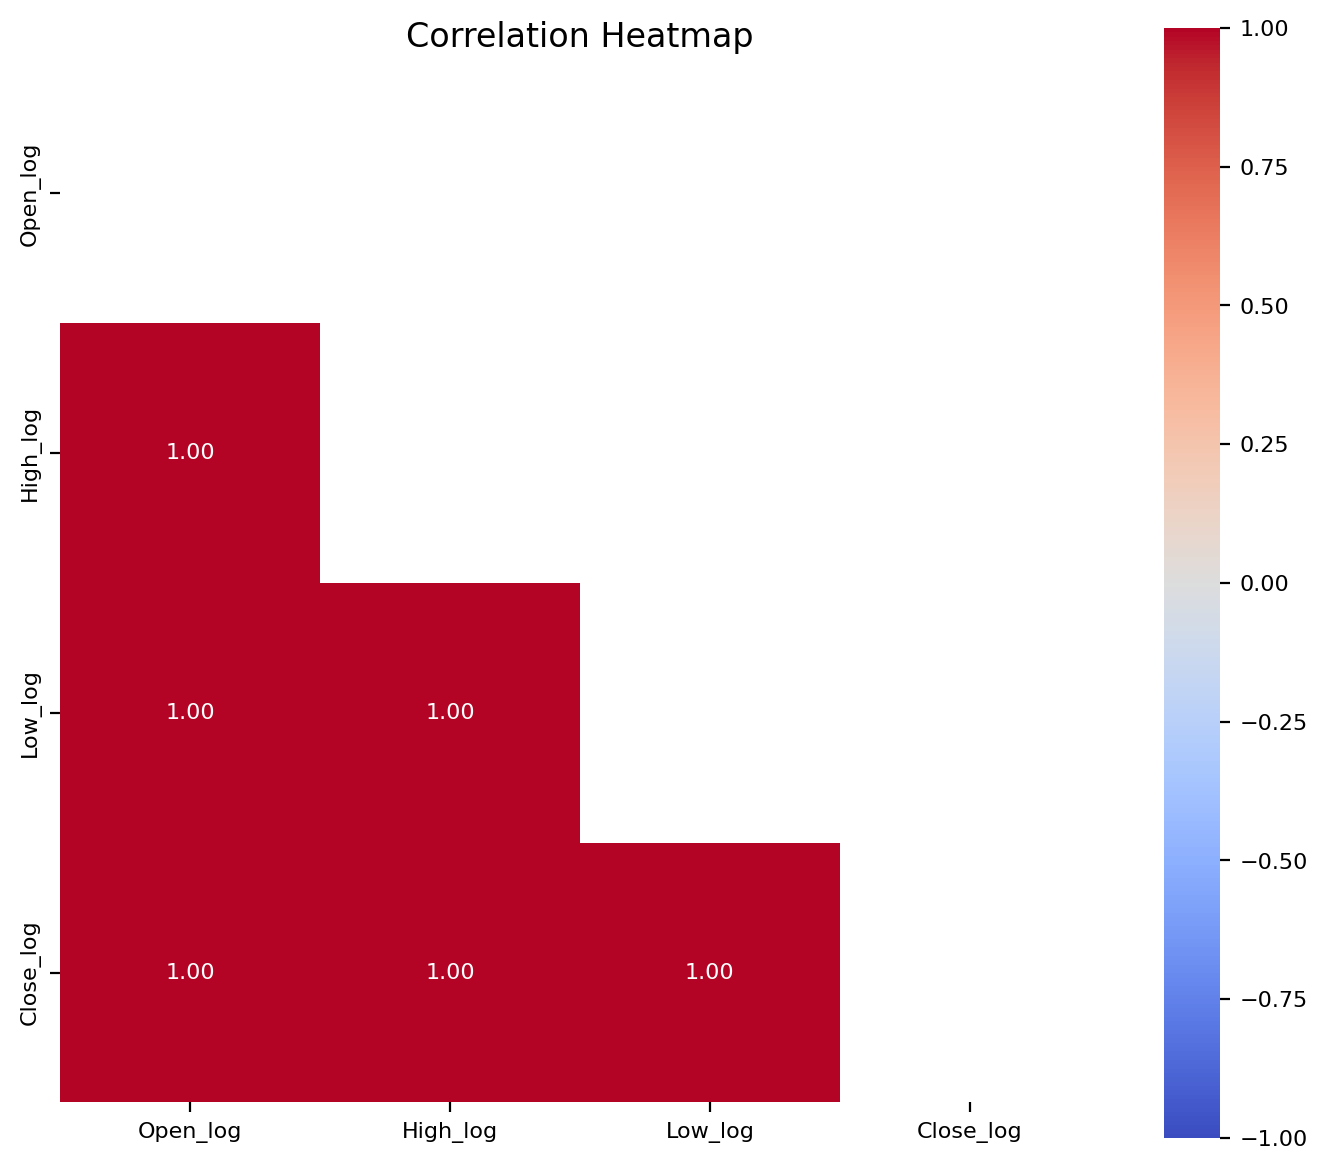

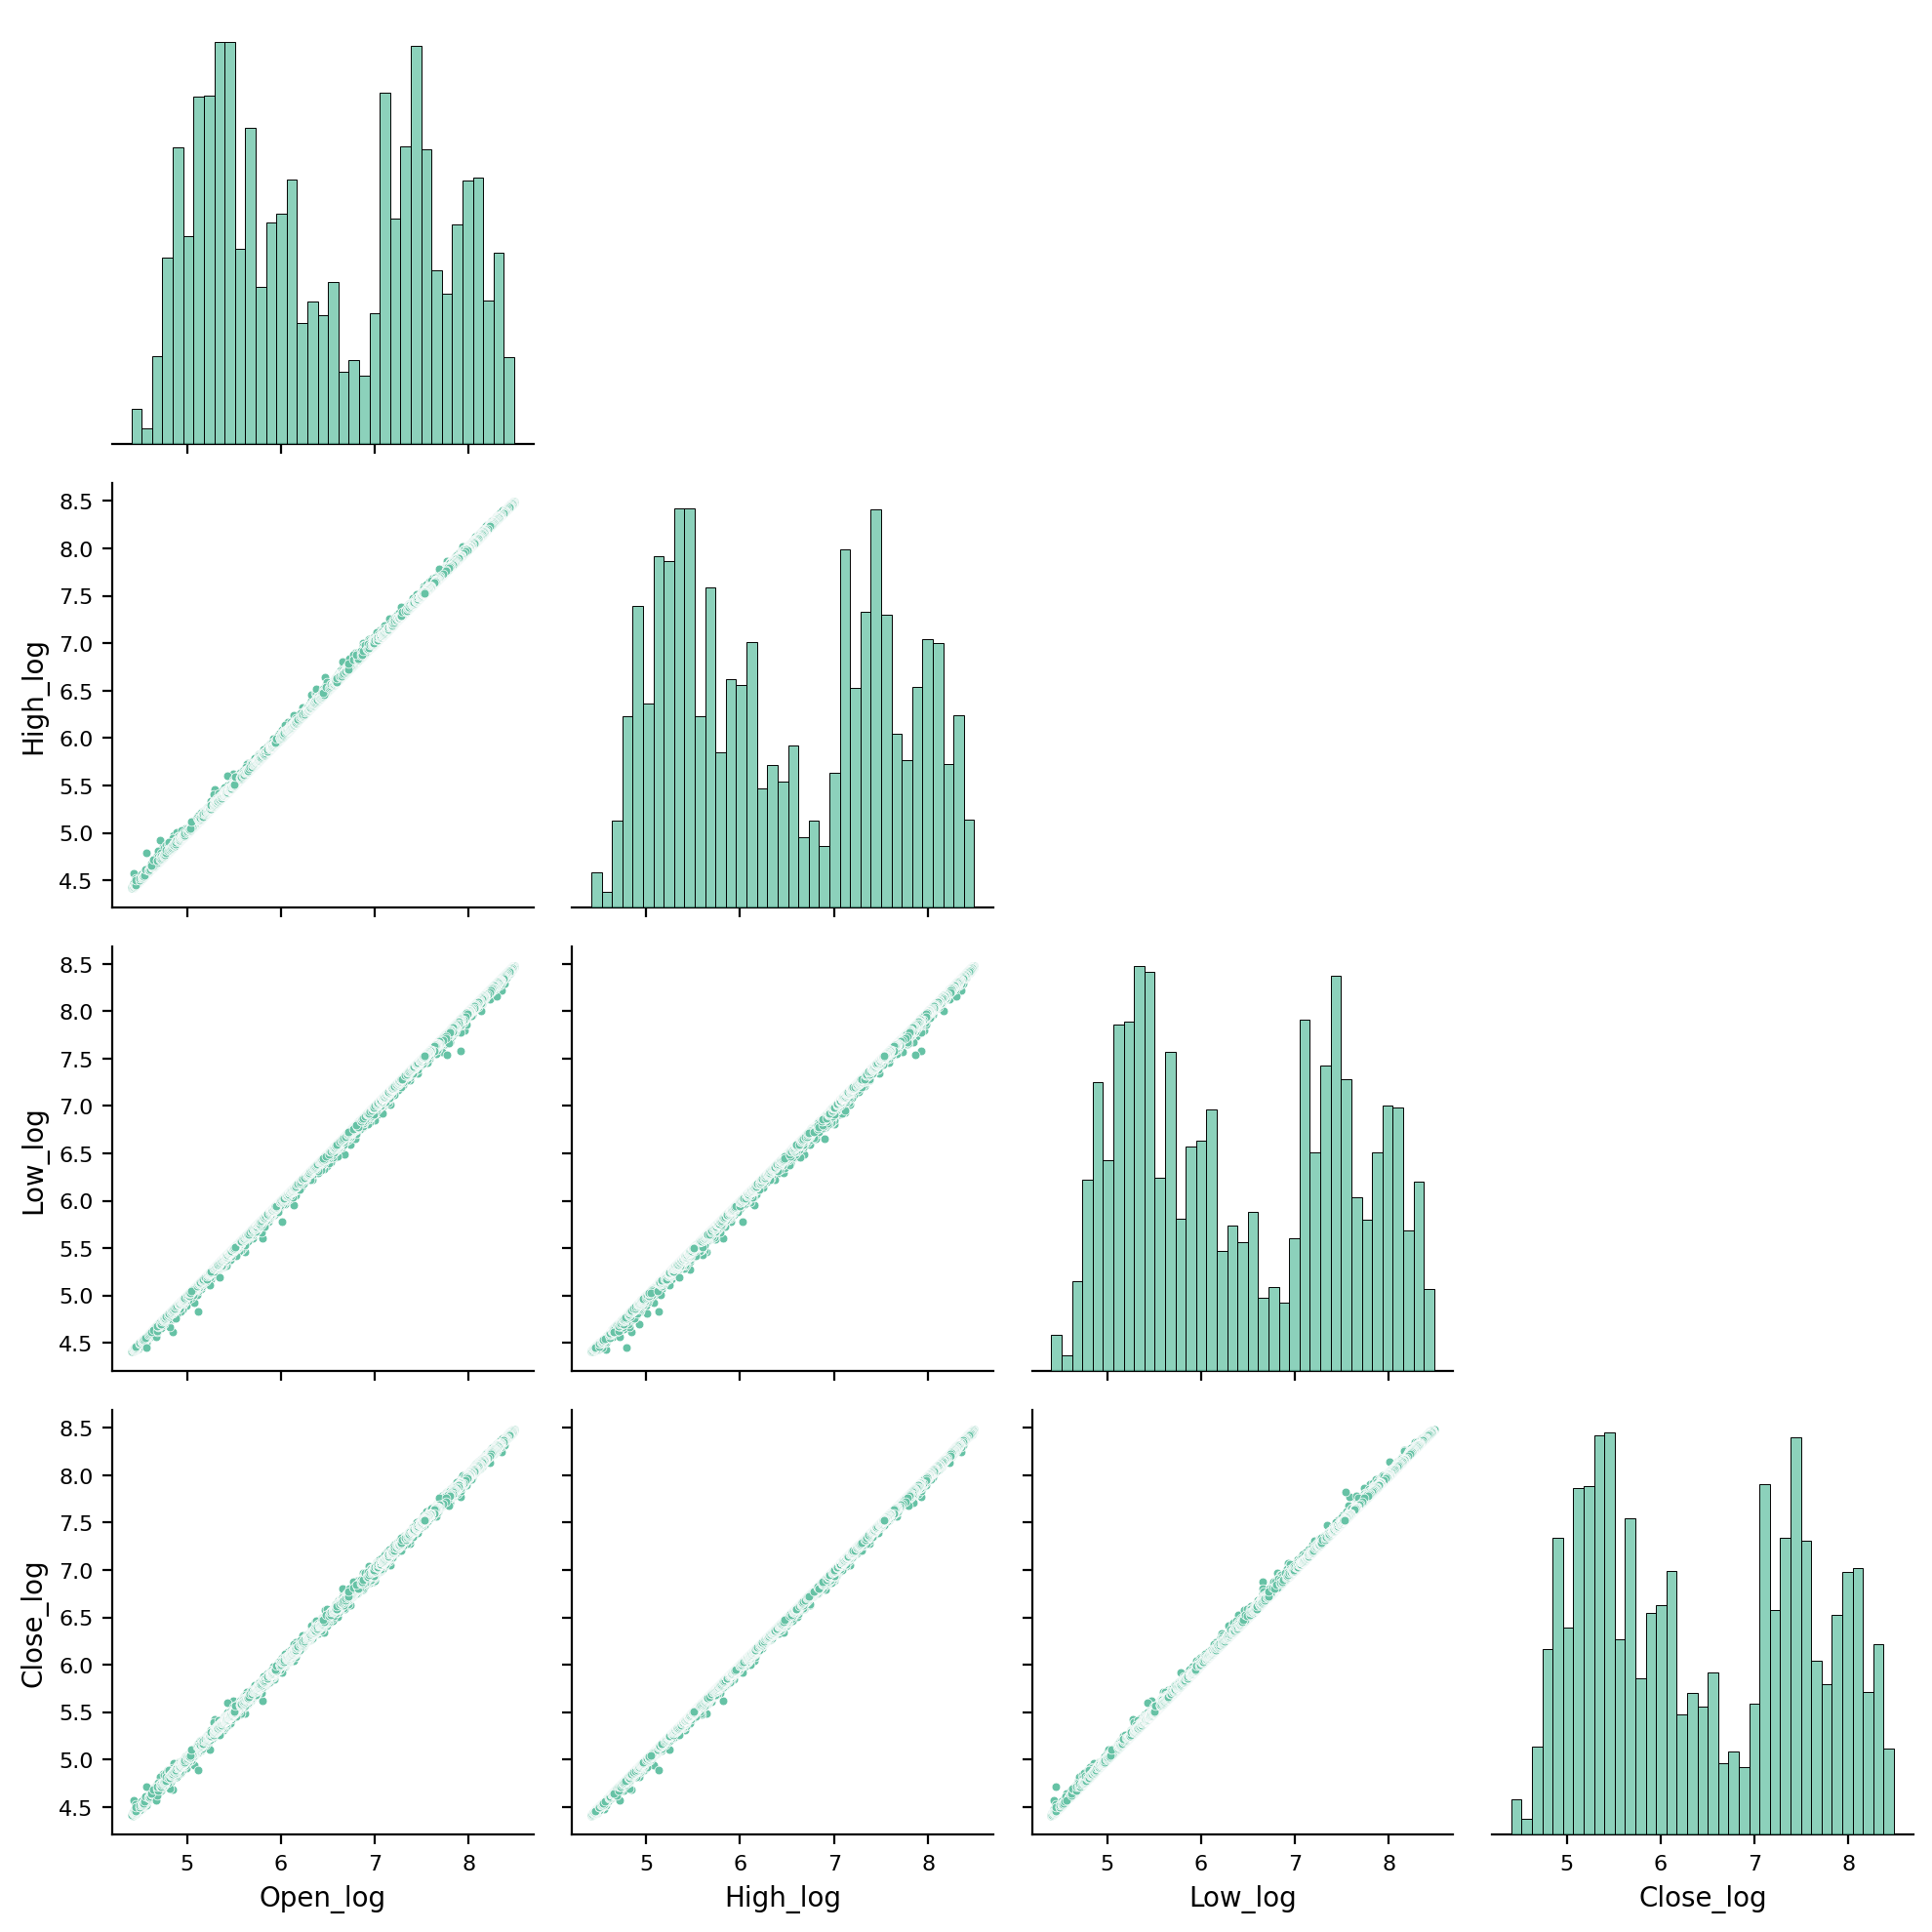

In [43]:
hd.plot_corr_heatmap(log_price_df)
hd.plot_pairplot(log_price_df)

Логарифмированные ценовые признаки все так же демонстрируют мультиколлинеарность которая подтверждается идеальной линейной связью на scatterplots. 

Тут лишь изменились распределения, они стали бимодальными.

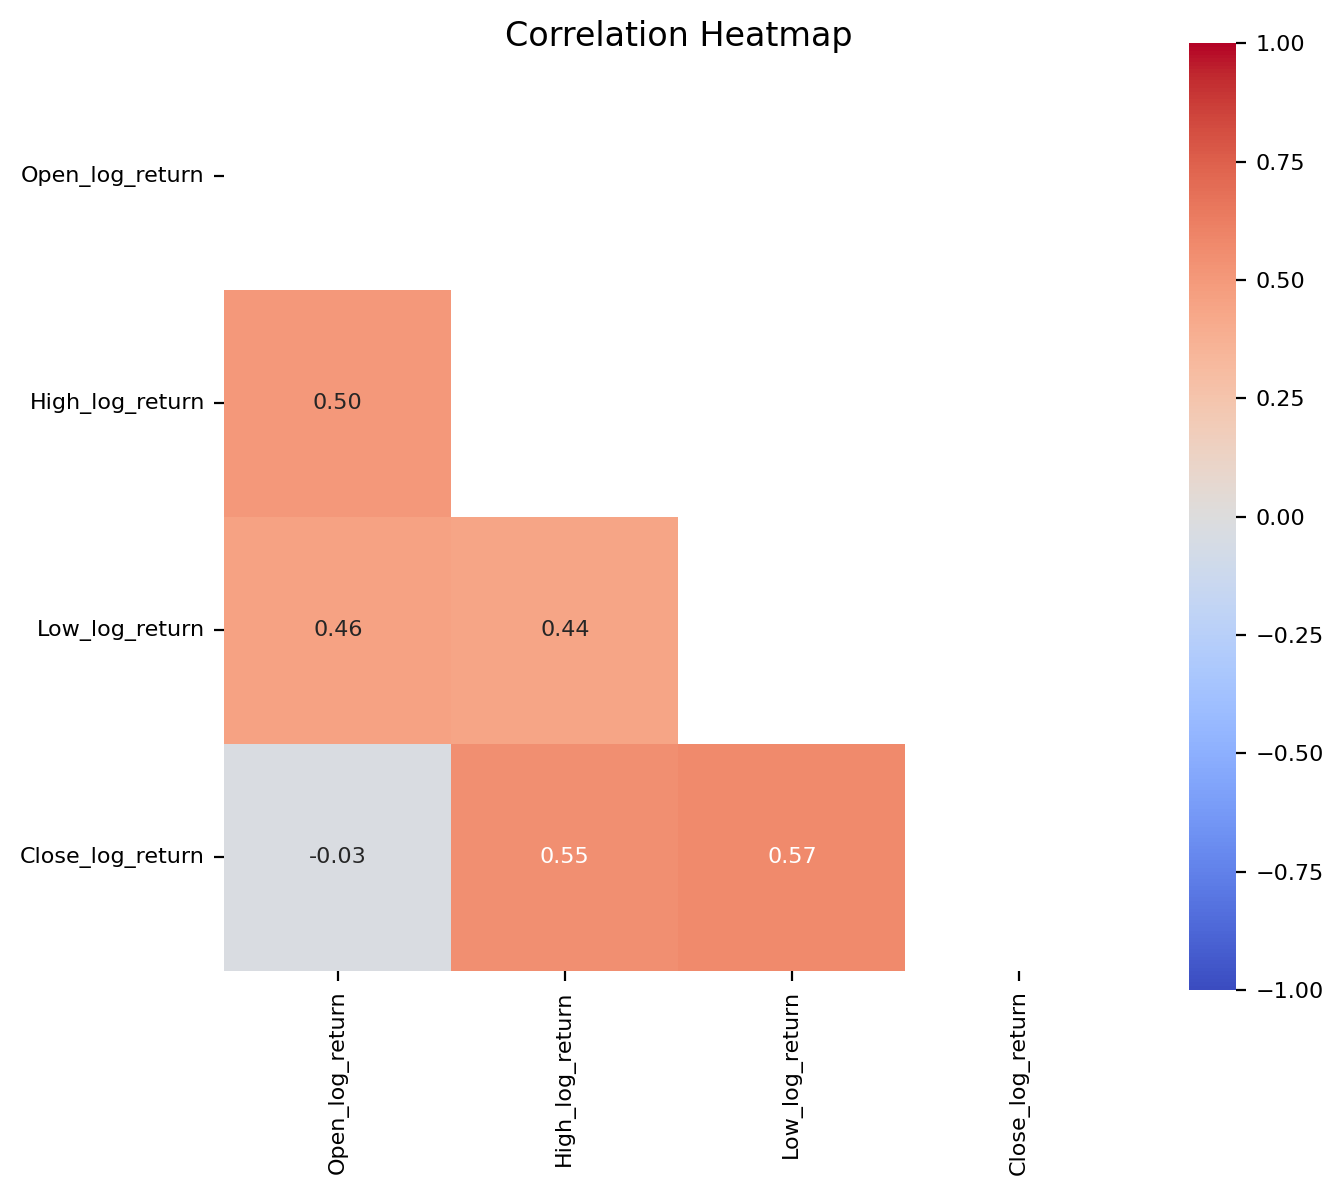

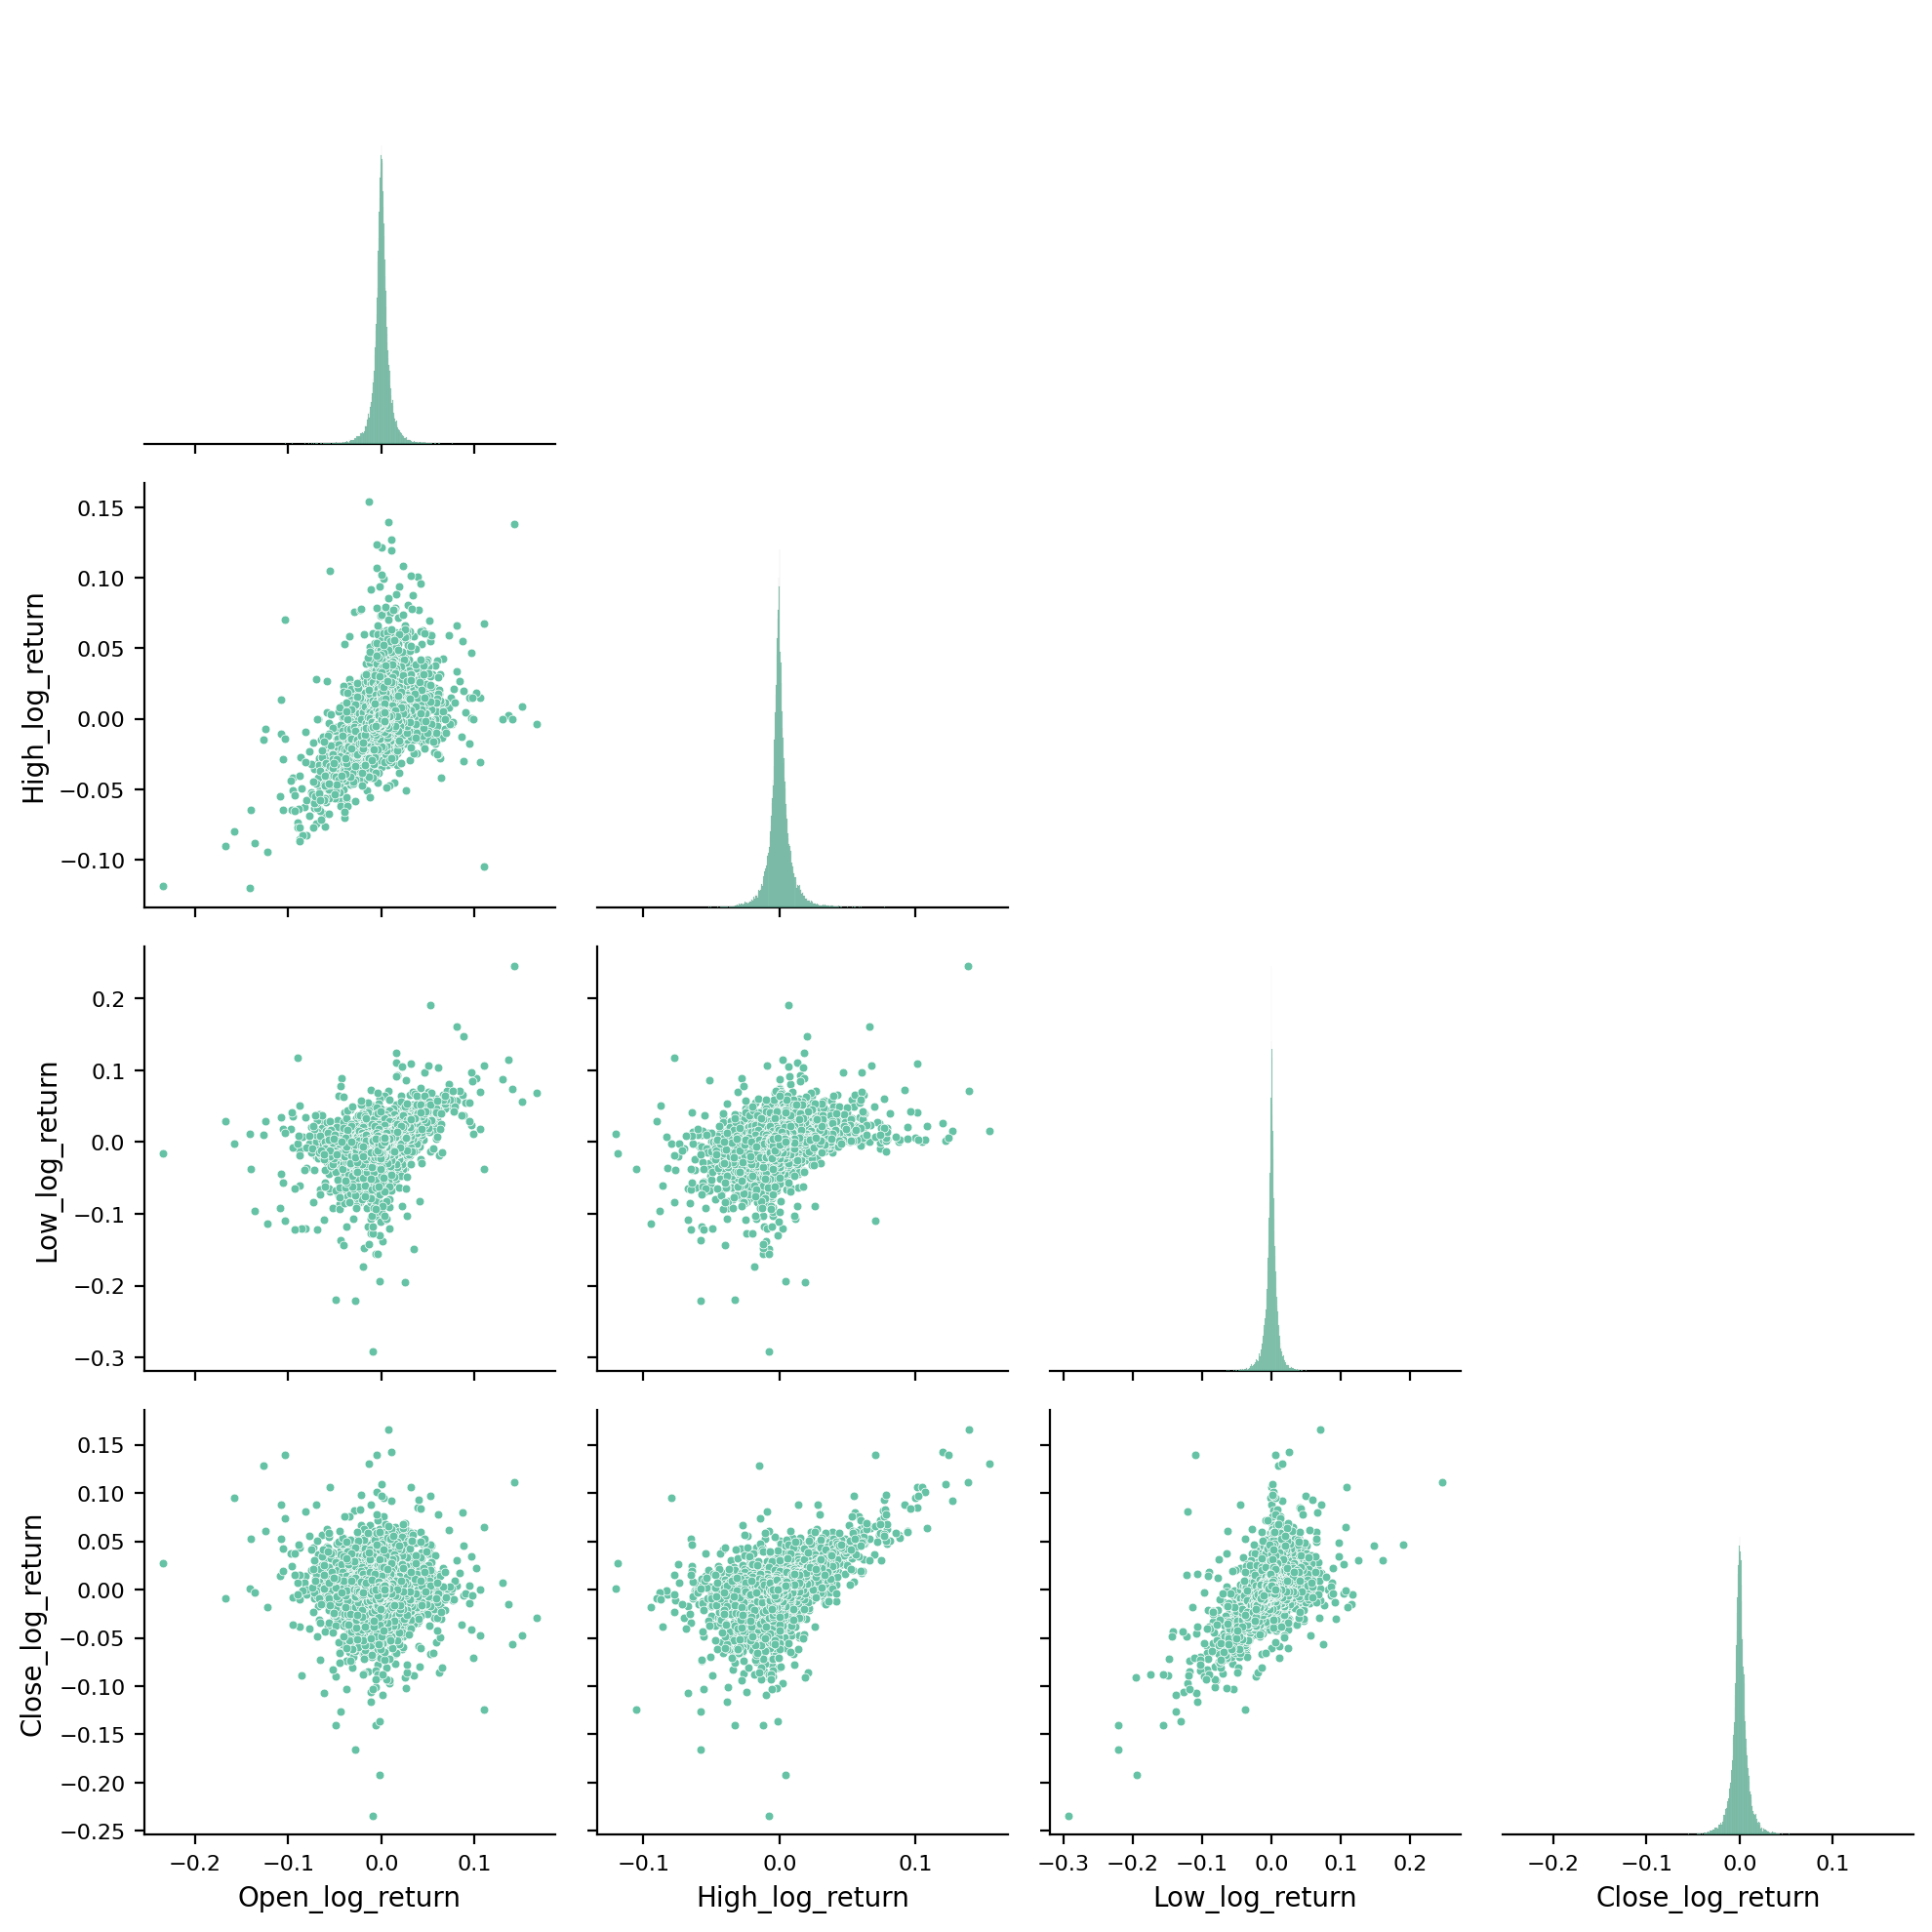

In [44]:
hd.plot_corr_heatmap(log_return_df)
hd.plot_pairplot(log_return_df)

Преобразование признаков к log return существенно изменило показатели. 

Мультиколлинеарности теперь нет, максимальное значение корреляции 0.55.

А скаттерплоты не показывают очевидных линейных зависисмостей между признаками.

# Подготовка к разметке данных
- Необходимо создать целевой признак для применения алгоритмов обучения с учителем, т.е. произвести разметку данных.
- Задачу прогнозирования цены свожу к задаче бинарной классофикации:
    * 1 - финансовый инструмент на текущем периоде значительно вырастет - нужно покупать и держать максимум до конца данного периода.
    * 0 - финансовый инструмент на текущем периоде не вырастет значительно или упадет - ничего не делаю, сделки не совершаю.
- Биржевые инструменты как правило большую часть времени торгуются в узком диапазоне и достаточно редко происходят крупные импульсные движения. От накопления к распределению и так циклично повторяется. Отсюда крайне длинные ховсты на диаграмах распределения.
- Базовая гипотеза заключается в том, что бы постараться предсказать периоды, когда цена совсем незначительно после открытия периода движется вниз (с открытия падает) и более значительно движется в верх (с открытия растет).
- Падаение на текущем периоде это движение от открытия до минимальной цены `down_move`
- Рост это движение от открытия до максимальной цены `up_move`

In [26]:
def create_price_features(df):
    """
    Enhances the input DataFrame with calculated price features based on log-transformed prices.

    Parameters:
    - df: Input DataFrame containing log-transformed price data with columns 
          'High_log', 'Open_log', 'Close_log', and 'Low_log'.

    Returns:
    - DataFrame with additional columns: 'up_move', 'down_move', 'up_shadow', and 'down_shadow'.

    Note:
    - Assumes the input DataFrame already has the necessary log-transformed price columns.
      Ensure these are present before calling this function.
    """

    # Calculate the up move and down move from the open price
    df["up_move"] = df["High_log"] - df["Open_log"]
    df["down_move"] = df["Open_log"] - df["Low_log"]

    # Calculate the body of the candlestick (difference between open and close prices)
    body = df["Close_log"] - df['Open_log']

    # Calculate up and down shadows of the candlestick
    df["up_shadow"] = np.where(body >= 0, df["High_log"] - df["Close_log"], df["High_log"] - df["Open_log"])
    df["down_shadow"] = np.where(body < 0, df["Close_log"] - df["Low_log"], df["Open_log"] - df["Low_log"])

    return df

In [27]:
df = create_price_features(df)

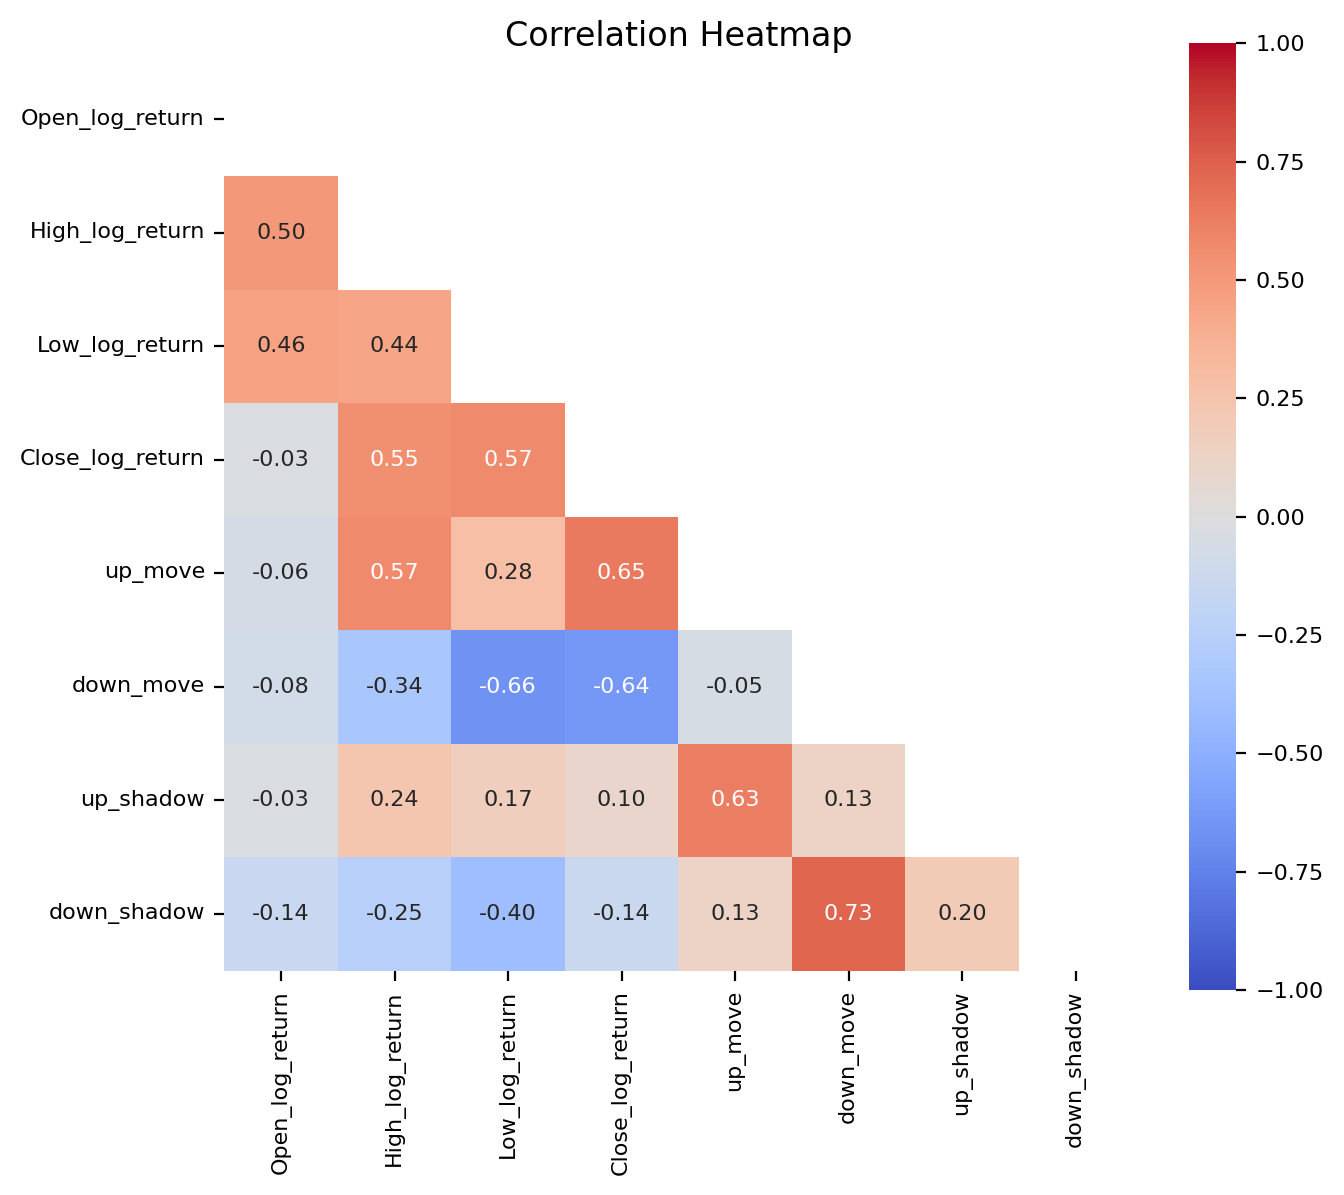

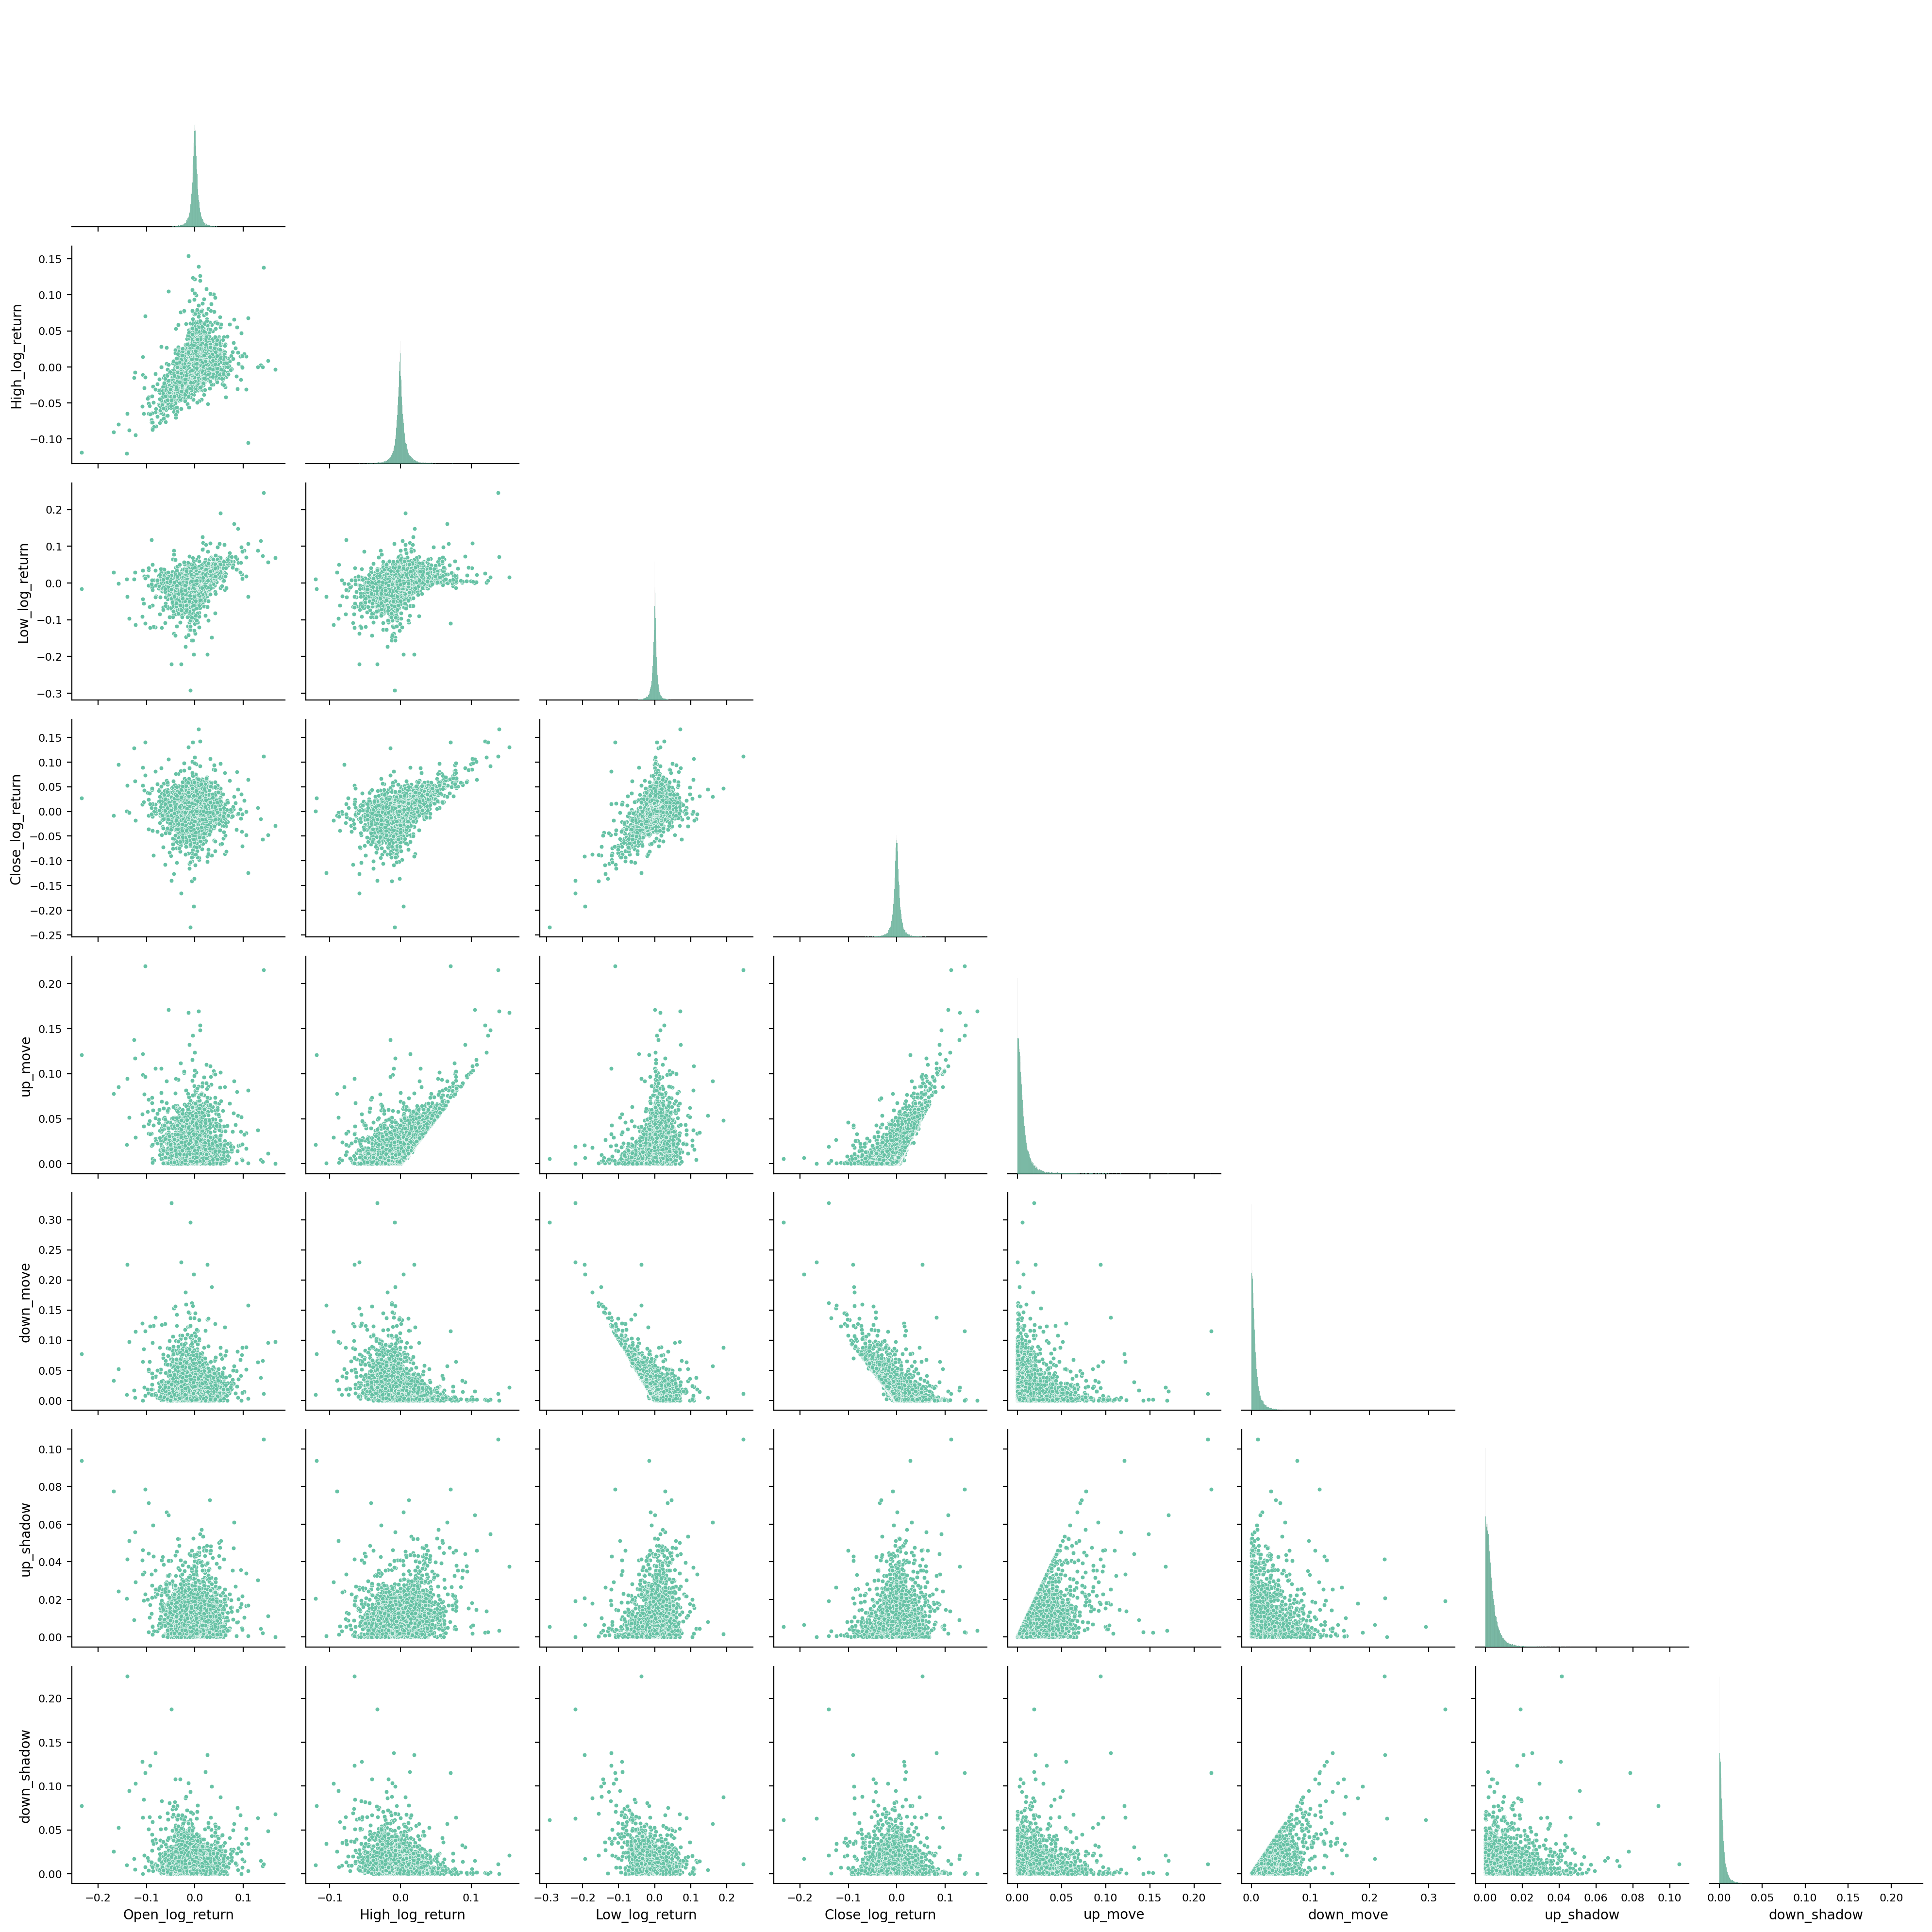

In [52]:
cols_to_plot = ['Open_log_return', 'High_log_return', 'Low_log_return', 'Close_log_return', 'up_move', 'down_move', 'up_shadow', 'down_shadow']
hd.plot_corr_heatmap(df[cols_to_plot])
hd.plot_pairplot(df[cols_to_plot])

Корреляции для вновь образованных признаков местами достаточно высокие (макс 0.73) но не запредельные.

Scattrplots показывают подобия линейных зависимостей с четкими ограничениями.

Видны очетливые связи между `up_move` и `up_shadow`, `down_move` и `down_shadow`. Вероятно стоит оставить только по одому признаку из пары.

### Признаки на основе даты и времени

In [28]:
def create_datetime_features(df, as_category=True):
    """
    Create date-time related features from the index of the dataframe.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame with datetime index.
    - as_category (bool, default=True): If True, convert the generated features to category type.
    
    Returns:
    - pandas.DataFrame: DataFrame with new date-time features.
    
    Note:
    - It is assumed that the provided DataFrame has a datetime index.
    """
    
    # Extract datetime from index
    date_time = df.index
    
    # Extract features from datetime
    df['Month'] = date_time.month
    df['Week_of_Year'] = date_time.isocalendar().week
    df['Day_of_Month'] = date_time.day
    df['Day_of_Week'] = date_time.weekday
    df['Hour'] = date_time.hour
    
    # Convert features to category type if as_category is True
    if as_category:
        cols_to_convert = ['Month', 'Week_of_Year', 'Day_of_Month', 'Day_of_Week', 'Hour']
        for col in cols_to_convert:
            df[col] = df[col].astype('category')
        
    return df

In [29]:
df = create_datetime_features(df, as_category=True)

# Create TARGET
### Создание целевого бинарного категориального признака `Long`
Задаю уровень риска в лог величинах `risk_level`

и коэффициент доходность/риск в виде множителя `risk_factor`

Базовый вариант:
* risk_level = 0.0025
* risk_factor = 4
* profit_level = risk_level * profit_factor

Т.е. на текущем периоде с открытия в течении часа цена уходила ниже меньше чем на 0.25%, но при этом росла на 1% и более
- тогда Long = 1
- иначе Long = 0

В ситуации, когда на основе прогноза модели совершаются сделки на бирже, каждая сделка это риск, то необходимо сосредоточится на ошибке первого рода, False Positive исходы будут генерировать реальные убытки.

В качестве метрики в данном случае необходимо применять F1, Precision. Необходимо максимально снижать количество ложных срабатываний.


### Матожидание торговой системы для разных уровней Precision
- при Precision = 0.5
    
    МО = 4 * 0.5 - 1 * 0.5 = 2 - 0.5 = 1.5 от риска на сделку матожидание

    Получается на длинной дистанции с точносью всего 50% в среднем сделка будет приность 1.5 * `risk_level` в среднем на каждую совершенную сделку.


- Рассчитаю точка безубытка когда МО = 0, где x - Precision
 
    0 = 4 * x - 1 * (1 - x)

    4х -1 + х = 0

    5х = 1

    x = 0.2

    Т.е. при Precision = 0.2 торговая система будет в нуле (без учета комиссии и проскальзывания)

- А при соотношении доходность/риск как 5к1

    5х - 1 + х = 0
    
    x = 0.166

    Т.е. уровень безубыточности опускается до значения Precision = 0.166

In [34]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = "Long"

In [35]:
zero_mo = hd.profit_margin_for_zero_mo(profit_factor)
print("Метрика Precision должна быть выше:", zero_mo)

Метрика Precision должна быть выше: 0.2


In [36]:
df[TARGET] = np.where((df["up_move"] >= profit_level) & (df["down_move"] < risk_level), 1, 0)

### Другой вариант разметки
- период (бар) закрывается в +, неважно какое было движение внутри бара (выход из позиции по закрытию бара)
- снижение на текущем баре `down_move` < risk_level

В такой ситуации классы уже не так сильно перекошены, 27 на 73 всего.

In [114]:
# df[TARGET] = np.where(
#     (df["Close_log"] - df["Open_log"] > 0) & (df["down_move"] < risk_level), 1, 0
# )

In [37]:
def class_distribution(df, col):
    """
    Display the distribution of a categorical column both numerically and graphically.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe containing the data.
    col : str
        The name of the categorical column to visualize.

    Returns:
    --------
    None
        Displays the class distribution as a dataframe and a bar plot.
    """

    # Compute the percentage and count distribution of the categories
    class_df = pd.DataFrame(
        {
            "%": (df[col].value_counts(True) * 100).round(2),
            "Count": df[col].value_counts(),
        }
    )

    # Name the index and sort the dataframe by the index
    class_df.index.name = "Class"
    class_df.sort_index(ascending=False, inplace=True)

    # Display the distribution as a DataFrame
    display(class_df)

    # Plot the distribution as a bar chart
    sns.countplot(data=df, x=col)
    plt.ylabel("Count", fontsize=10)
    plt.xlabel("Class", fontsize=10)
    plt.title(f"Distribution of '{col}'")

    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    plt.show()

%  Count
Class              
1       9.48   4690
0      90.52  44774

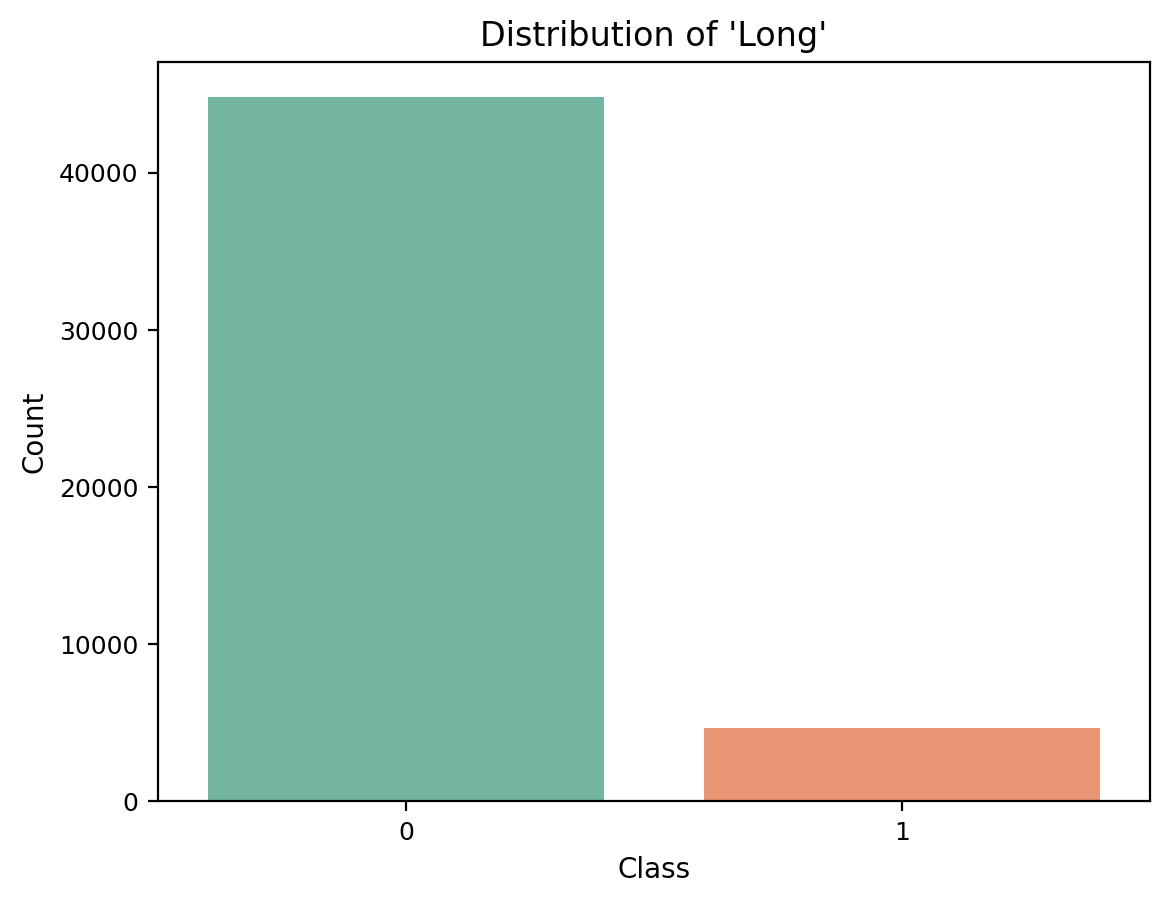

In [38]:
class_distribution(df, TARGET)

Виден сильный дисбаланс классов.

### Визуализирую исходный признак цены закрытия и целевой признак

In [39]:
def plot_close_and_traget(
    df, start_from_date=None, show_rows=None, format_xlabel=True, linewidth=1
):
    if start_from_date is None:
        data = df
    else:
        data = df[df.index >= start_from_date]

    if show_rows is not None:
        data = data.iloc[:show_rows]

    fig, ax = plt.subplots(
        2, 1, figsize=(14, 8), gridspec_kw={"height_ratios": [4, 1]}, sharex=True
    )

    ax[0].plot(data.index, data["Close"], color="blue", linewidth=linewidth)
    ax[0].set_title("Close")
    ax[0].set_ylabel("")

    ax[1].vlines(data.index, 0, data[TARGET], color="green", linewidth=0.1)
    ax[1].set_title(
        f"Target: {TARGET}. up_shadow >= {profit_level:.2%}, down_shadow < {risk_level:.2%}"
    )
    ax[1].set_ylabel("")

    # Rotate x-axis tick labels to 90 degrees
    ax[1].tick_params(axis="x", rotation=90, labelsize=8)

    if format_xlabel:
        # Set x-axis tick labels every month
        ax[1].xaxis.set_major_locator(
            mdates.MonthLocator()
        )  # Set ticks for every month
        ax[1].xaxis.set_major_formatter(
            mdates.DateFormatter("%b %y")
        )  # Format as 'Jan 2022'

        # Calculate the total range of your dates
        date_range = data.index.max() - data.index.min()
        buffer = date_range * 0.01  # Calculate 1% of the range

        # Adjust the start and end dates
        adjusted_start_date = data.index.min() - buffer
        adjusted_end_date = data.index.max() + buffer

        # Set the adjusted x-axis limits
        for axis in ax:
            axis.set_xlim(adjusted_start_date, adjusted_end_date)

    plt.xlabel("Date", fontsize=10)
    plt.tight_layout()
    plt.show()

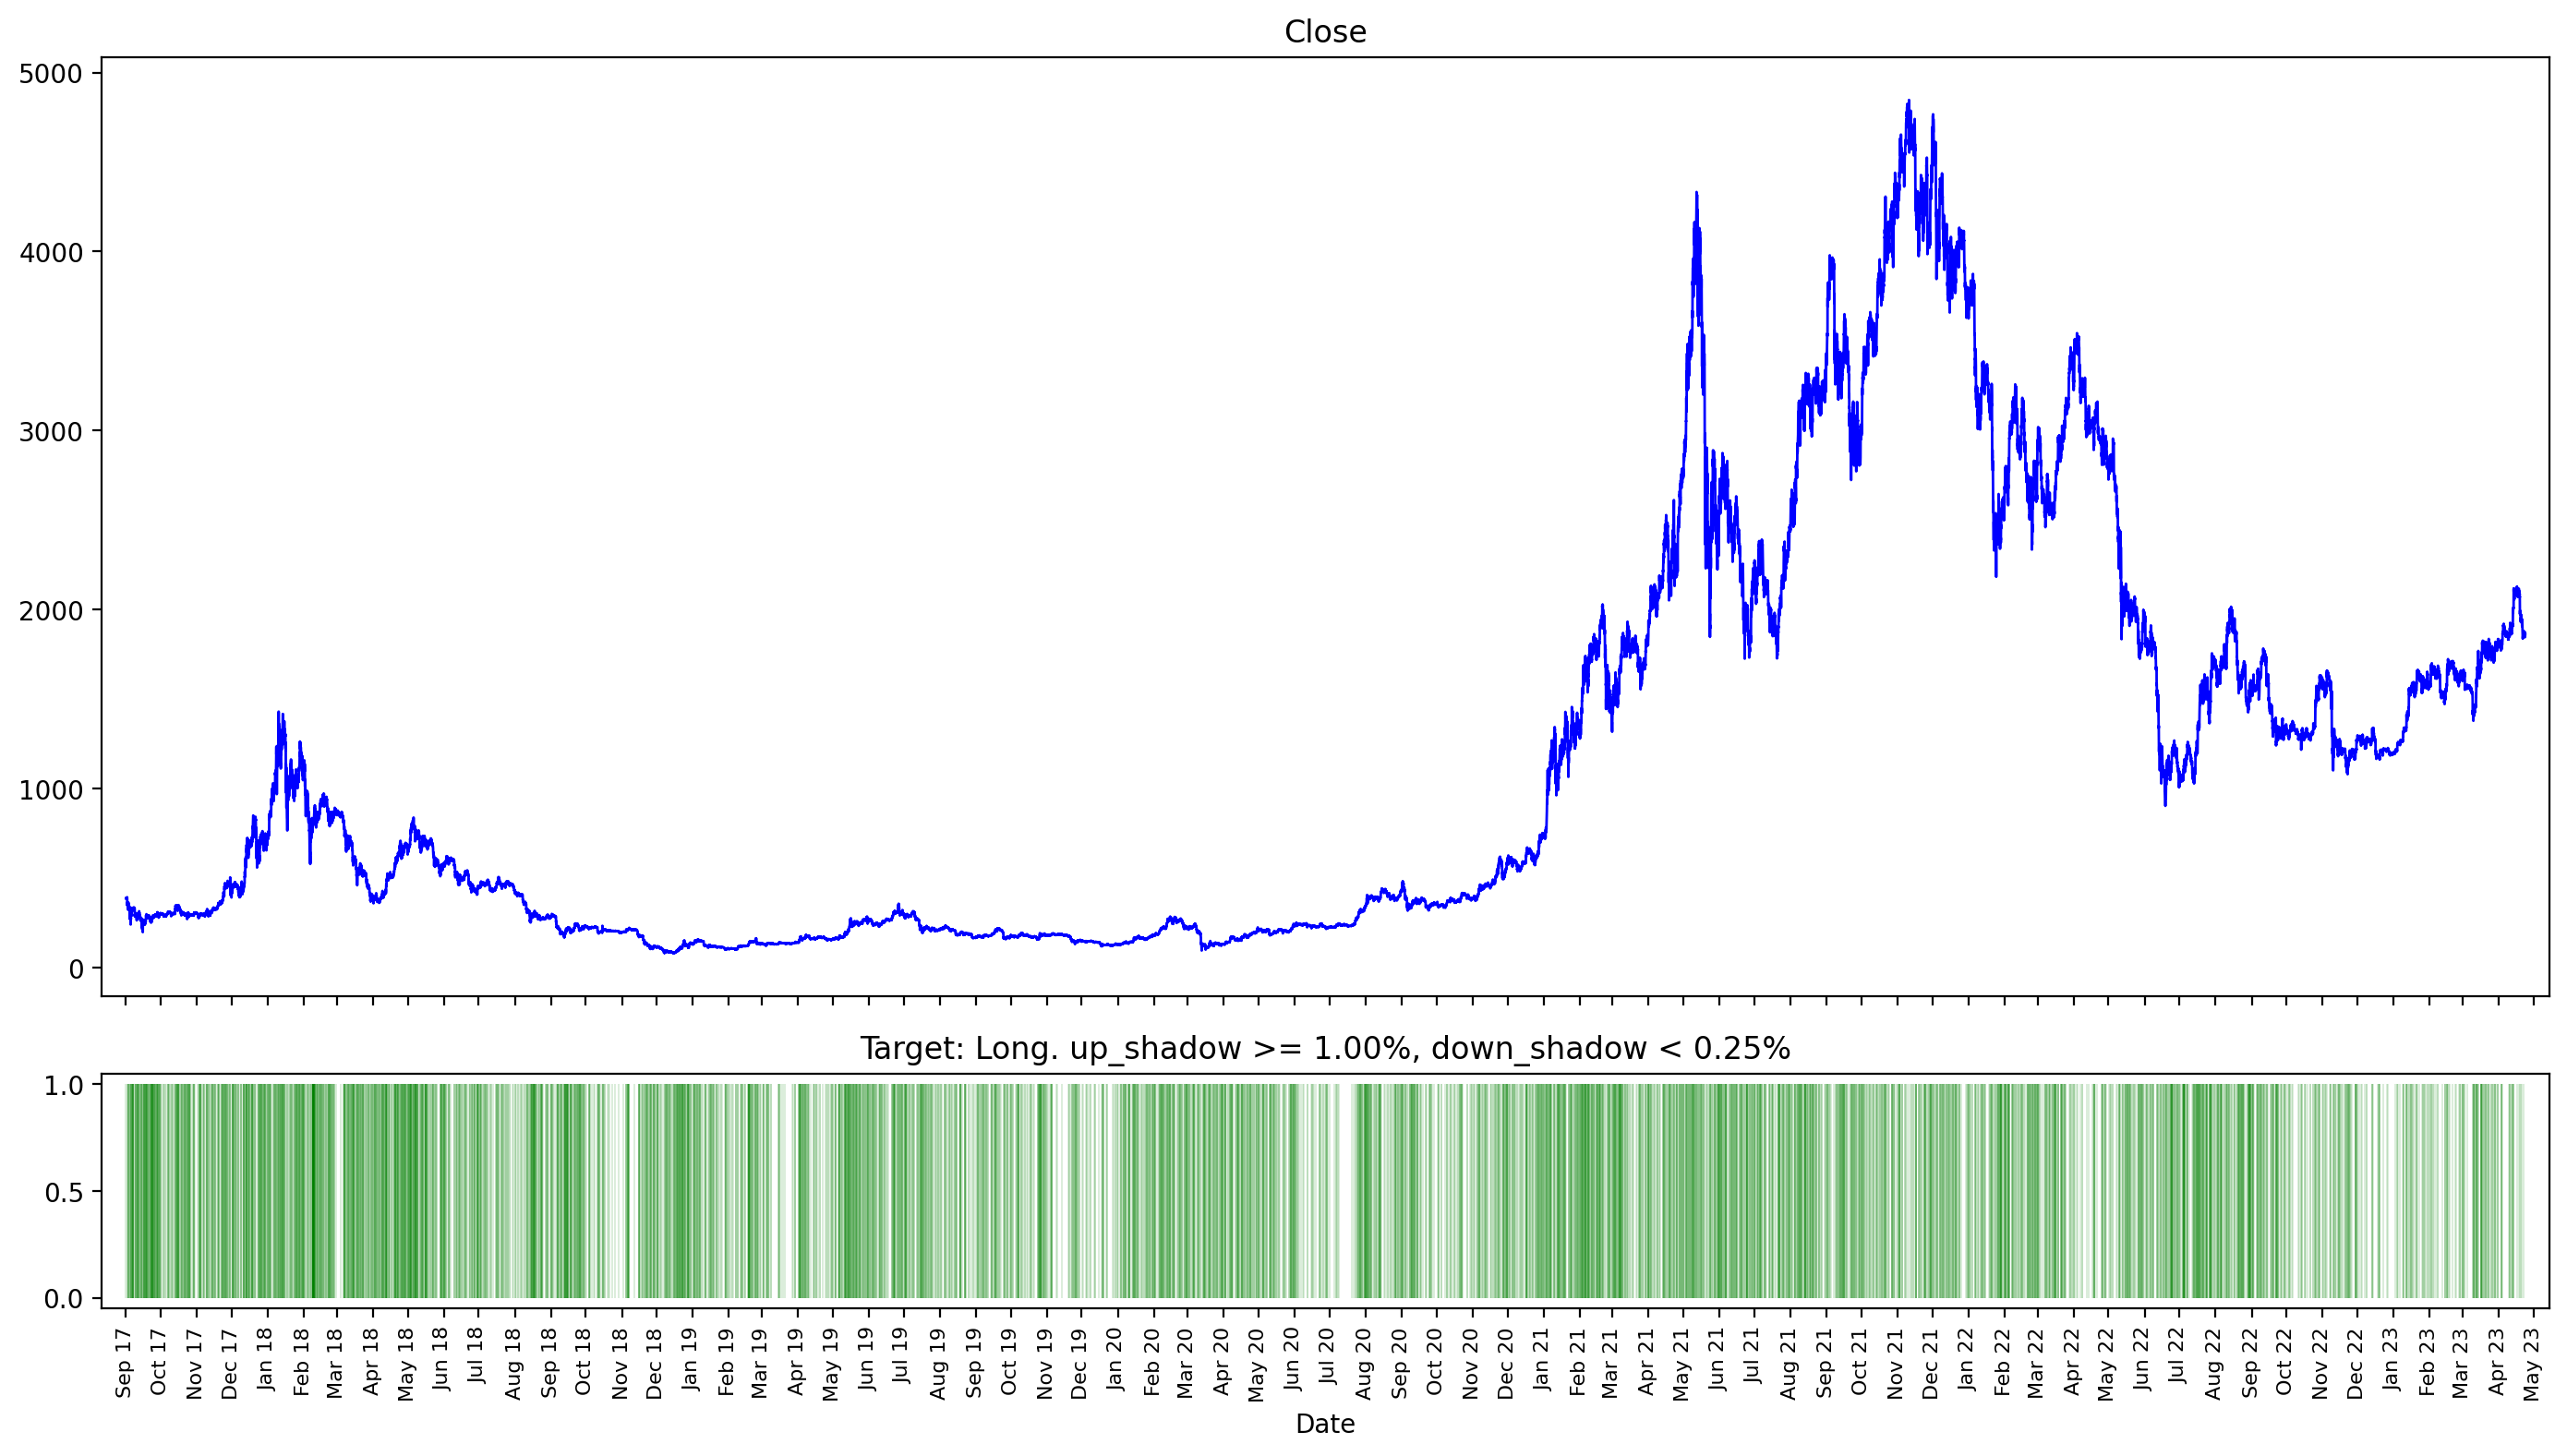

In [40]:
plot_close_and_traget(df)

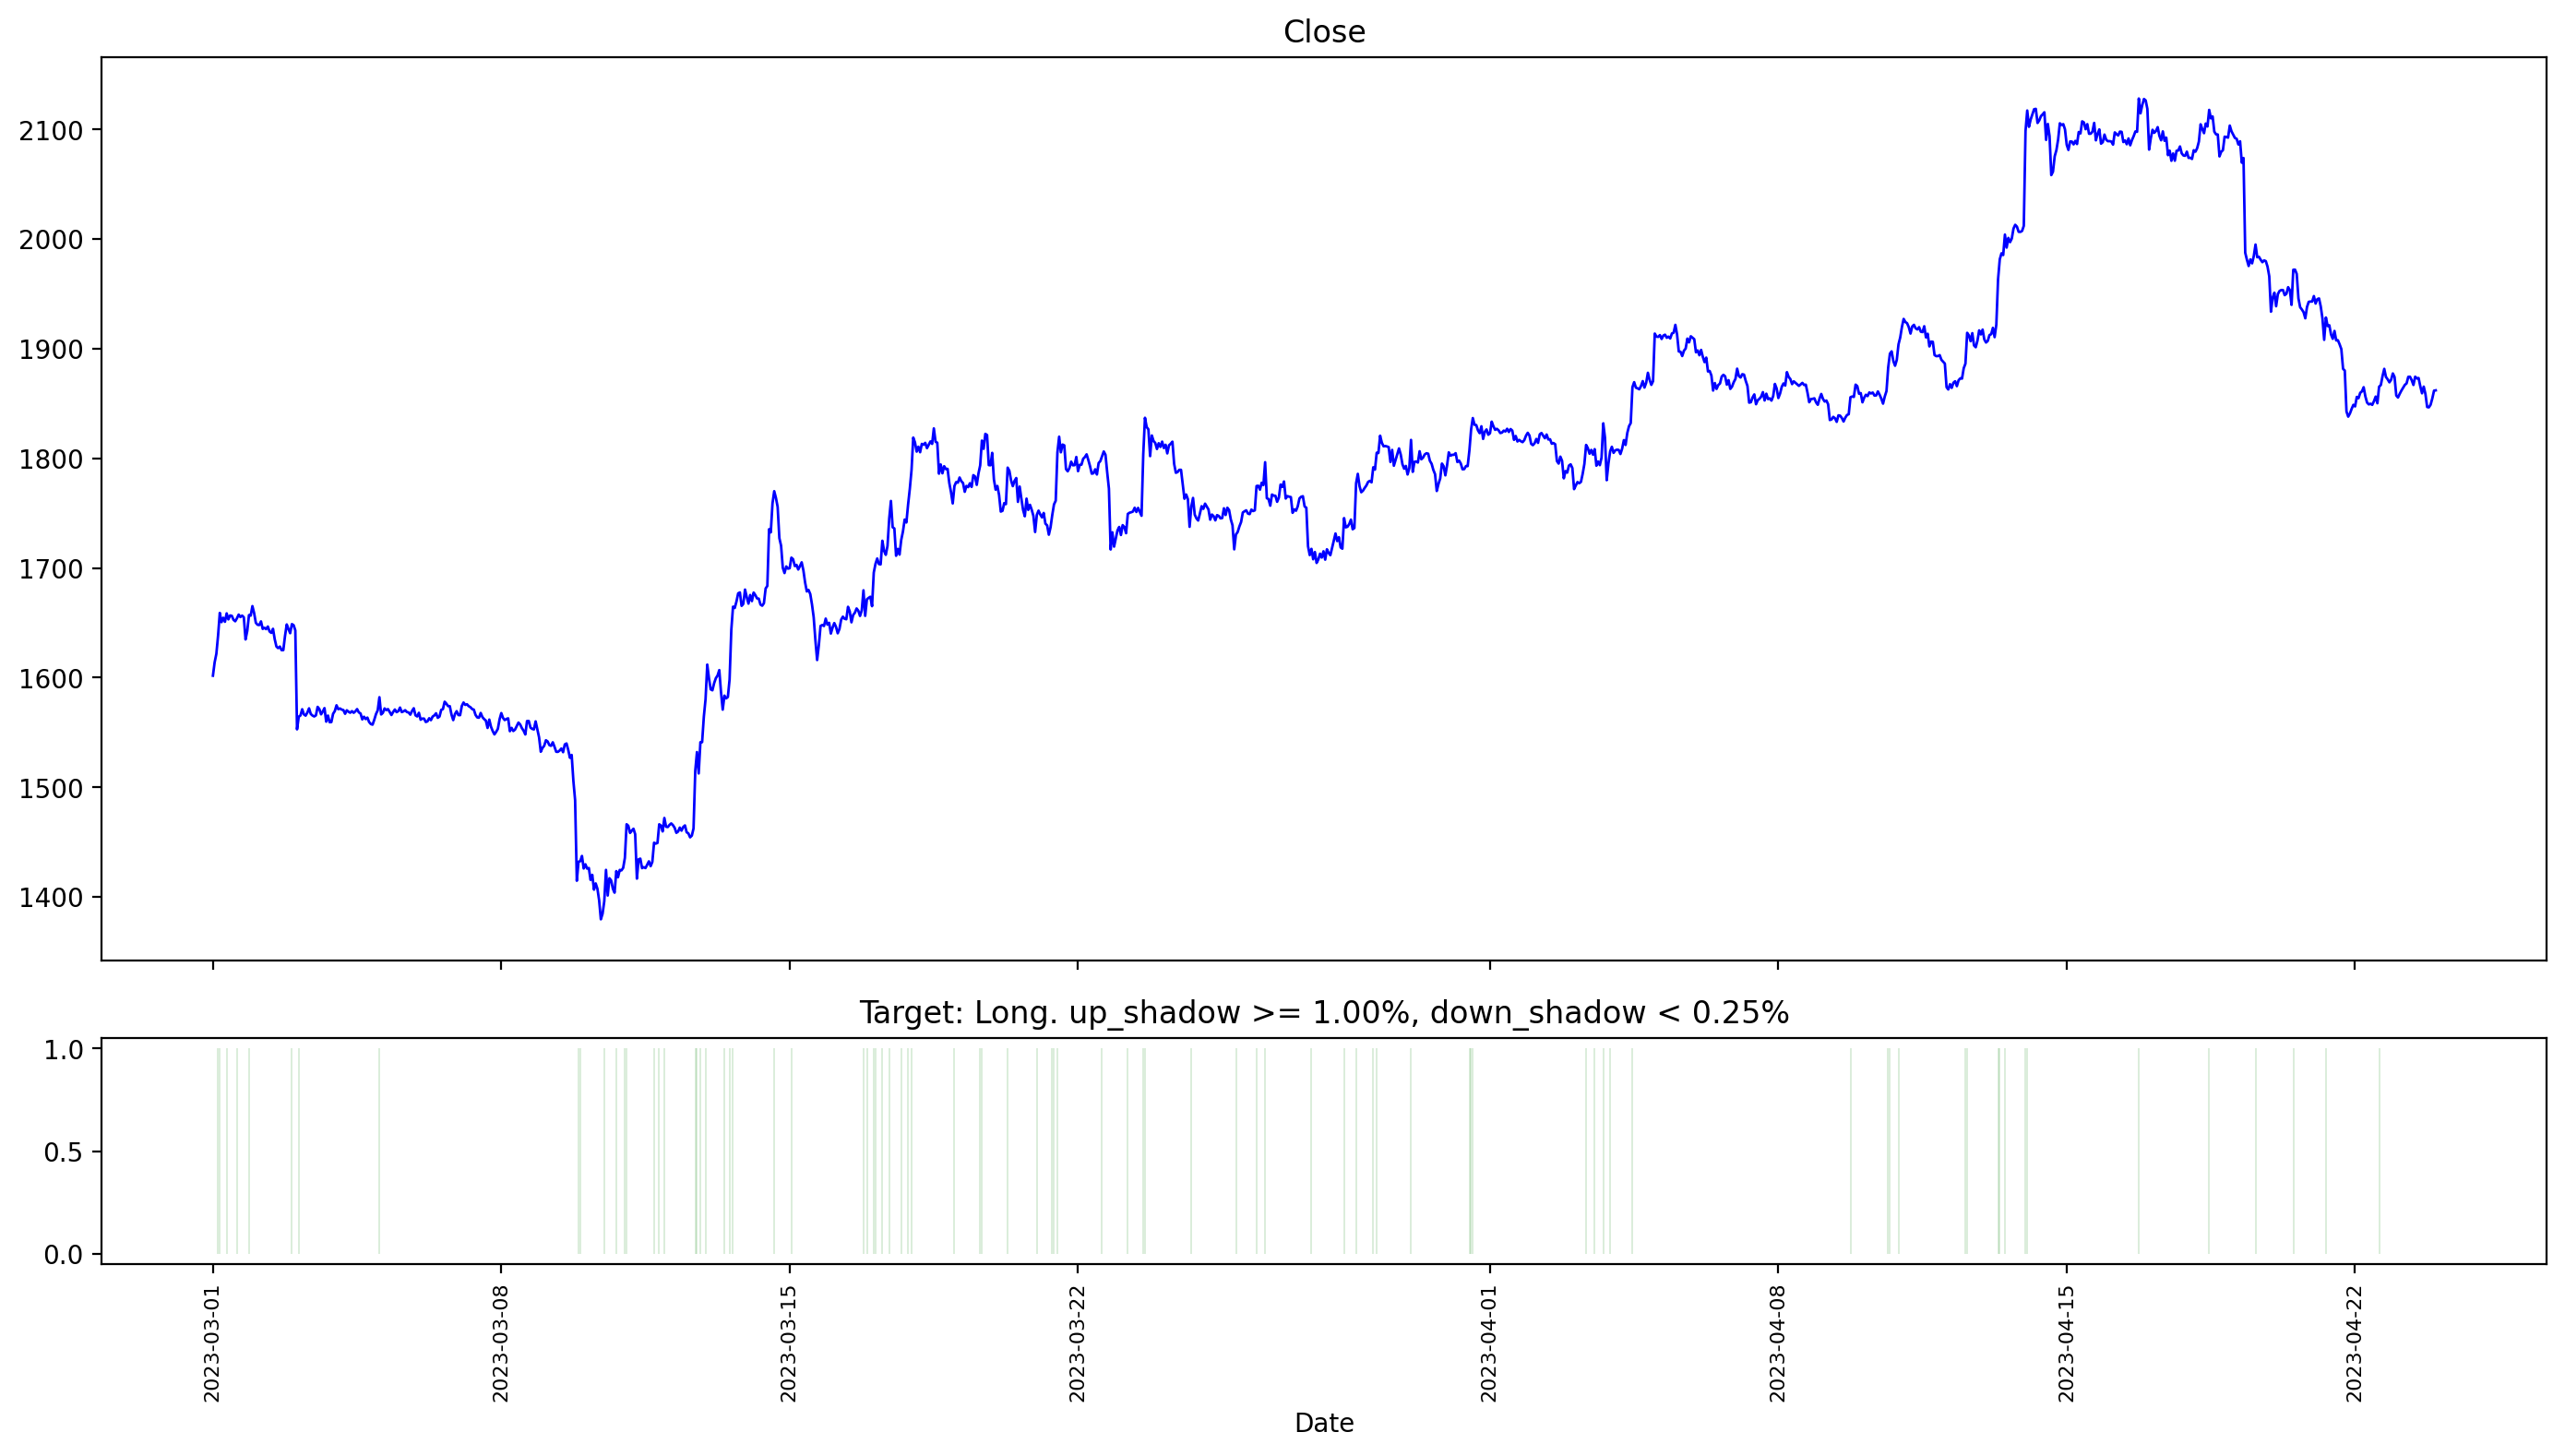

In [41]:
plot_close_and_traget(df, "2023-03-01", format_xlabel=False)

Как часто появляются целевые бары относительно всей истории?

In [42]:
full_day_duration = (df.index[-1] - df.index[0]).days
print(f"В среднем целевые бары появляются {df[TARGET].sum() / full_day_duration:.1f} раза в день.")

В среднем целевые бары появляются 2.3 раза в день.


Сохраняю обработанную историю

In [43]:
df.to_parquet("../data/ETH-Full-1H_prepared.parquet")